In [1]:
import ROOT

Module libc not found.


Welcome to JupyROOT 6.30/09


In [2]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from os.path import exists

import read_config_utils as cu

In [4]:
import sys
import time

import gc

import pickle

import os.path


## Generate some toy data to fit

In [5]:
ndim = 6

n_samples = 500

random_seed = 1

ngen_mc = 10000



In [6]:
##-------------

if ndim == 6 :

    mc_mu = [ 1.,  0.,  -0.5,   0.5, -1., 0.3 ]

    mc_rho = [ 
                  [0.0, 0.0, -0.3, 0.2, 0.1],  #0
                  [0.1, 0.3, -0.2, 0.0 ],   #1
                  [0.3, -0.2, 0.1   ],  #2
                  [0.0, 0.1],  #3
                  [0.7],  #4
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8, 1.2, 1.4 ]
    

##-------------

if ndim == 4 :
    
    mc_mu = [ 1.,  0.,  -0.5,   0.5 ]

    mc_rho = [ 
                  [0.3, -0.2, 0.1   ],  #0
                  [0.0, 0.1],  #1
                  [0.7],  #2
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8 ]
    
    

##-------------

if ndim == 2 :
    
    mc_mu = [ 0.0, 1.0 ]

    mc_rho = [ [-0.6] ]

    mc_sig = [ 1.0, 1.5 ]


    
##-------------

if ndim == 1 :

    ##-------------

    mc_mu = [ 0.0 ]

    mc_rho = [ [0.0] ]

    mc_sig = [ 1.0 ]




##=====================

In [7]:
mc_cov = np.zeros( shape=(ndim,ndim) )

print("\n\n\n mc covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            mc_cov[i][j] = mc_sig[i] * mc_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, mc_cov[i][j]))
        else :
            k = ndim - j - 1
            mc_cov[i][j] = mc_sig[i] * mc_sig[j] * mc_rho[i][k]
            mc_cov[j][i] = mc_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, mc_sig[i], mc_sig[j], mc_rho[i][k], mc_cov[i][j]))
            




 mc covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    0.700 *    0.100 =   0.0700
   0,  2 :              1.000 *    1.100 *    0.200 =   0.2200
   0,  3 :              1.000 *    0.800 *   -0.300 =  -0.2400
   0,  4 :              1.000 *    1.200 *    0.000 =   0.0000
   0,  5 :              1.000 *    1.400 *    0.000 =   0.0000
   1,  1 : diagonal    0.4900
   1,  2 :              0.700 *    1.100 *    0.000 =   0.0000
   1,  3 :              0.700 *    0.800 *   -0.200 =  -0.1120
   1,  4 :              0.700 *    1.200 *    0.300 =   0.2520
   1,  5 :              0.700 *    1.400 *    0.100 =   0.0980
   2,  2 : diagonal    1.2100
   2,  3 :              1.100 *    0.800 *    0.100 =   0.0880
   2,  4 :              1.100 *    1.200 *   -0.200 =  -0.2640
   2,  5 :              1.100 *    1.400 *    0.300 =   0.4620
   3,  3 : diagonal    0.6400
   3,  4 :              0.800 *    1.200 *    0.100 =   0.0960
   3,  5 :              0.800 *    1.400 *

In [8]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * mc_pts[:,fi1] )
    wx2 = np.sum( weights * mc_pts[:,fi2] )
    wx1x2 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi1] )
        wx2x2 = np.sum( weights * mc_pts[:,fi2] * mc_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [9]:
all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )

all_weight_sum = np.zeros( n_samples )






for si in range(n_samples) :
        
    print('\n----- sample %4d ' % si )

    np.random.seed( random_seed*10000+si )

    mc_pts = np.random.multivariate_normal(mc_mu, mc_cov, size=ngen_mc)

    dummy_weights = np.ones( shape=ngen_mc )

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            mean_cov = calc_mean_cov( dummy_weights, fi1, fi2 )
            all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
            all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
            if ( fi1 == fi2 ) :
                print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                      (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                all_mean[fi1,si] = mean_cov["mean_x1"]
                all_rms[fi1,si] = mean_cov["rms1"]
            else :
                print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                      (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                all_rho[fi1,fi2,si] = mean_cov["rho12"]
                all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        

        


----- sample    0 
  0 0  :  mean =   1.0223, RMS =   0.9993, cov =   0.9986
  0 1  :  rho =   0.1015,  cov =   0.0709
  0 2  :  rho =   0.2110,  cov =   0.2337
  0 3  :  rho =  -0.3092,  cov =  -0.2488
  0 4  :  rho =  -0.0047,  cov =  -0.0057
  0 5  :  rho =   0.0014,  cov =   0.0019
  1 1  :  mean =  -0.0014, RMS =   0.6990, cov =   0.4886
  1 2  :  rho =   0.0045,  cov =   0.0035
  1 3  :  rho =  -0.1959,  cov =  -0.1102
  1 4  :  rho =   0.3060,  cov =   0.2572
  1 5  :  rho =   0.1073,  cov =   0.1056
  2 2  :  mean =  -0.4908, RMS =   1.1082, cov =   1.2282
  2 3  :  rho =   0.0963,  cov =   0.0860
  2 4  :  rho =  -0.1879,  cov =  -0.2503
  2 5  :  rho =   0.3233,  cov =   0.5044
  3 3  :  mean =   0.4973, RMS =   0.8050, cov =   0.6481
  3 4  :  rho =   0.1094,  cov =   0.1059
  3 5  :  rho =   0.0138,  cov =   0.0156
  4 4  :  mean =  -0.9977, RMS =   1.2024, cov =   1.4458
  4 5  :  rho =   0.6985,  cov =   1.1824
  5 5  :  mean =   0.3000, RMS =   1.4078, cov =   1.9820

-

  0 0  :  mean =   0.9943, RMS =   1.0145, cov =   1.0292
  0 1  :  rho =   0.1070,  cov =   0.0763
  0 2  :  rho =   0.2048,  cov =   0.2297
  0 3  :  rho =  -0.2964,  cov =  -0.2414
  0 4  :  rho =  -0.0157,  cov =  -0.0193
  0 5  :  rho =  -0.0208,  cov =  -0.0296
  1 1  :  mean =   0.0028, RMS =   0.7028, cov =   0.4939
  1 2  :  rho =  -0.0118,  cov =  -0.0092
  1 3  :  rho =  -0.2027,  cov =  -0.1144
  1 4  :  rho =   0.2982,  cov =   0.2525
  1 5  :  rho =   0.0882,  cov =   0.0869
  2 2  :  mean =  -0.5130, RMS =   1.1054, cov =   1.2218
  2 3  :  rho =   0.0972,  cov =   0.0863
  2 4  :  rho =  -0.2126,  cov =  -0.2831
  2 5  :  rho =   0.2887,  cov =   0.4474
  3 3  :  mean =   0.5028, RMS =   0.8029, cov =   0.6446
  3 4  :  rho =   0.1157,  cov =   0.1120
  3 5  :  rho =   0.0147,  cov =   0.0165
  4 4  :  mean =  -0.9836, RMS =   1.2049, cov =   1.4519
  4 5  :  rho =   0.6963,  cov =   1.1761
  5 5  :  mean =   0.3071, RMS =   1.4018, cov =   1.9650

----- sample   14 
  

  0 0  :  mean =   0.9904, RMS =   1.0026, cov =   1.0051
  0 1  :  rho =   0.1184,  cov =   0.0828
  0 2  :  rho =   0.2056,  cov =   0.2278
  0 3  :  rho =  -0.3164,  cov =  -0.2519
  0 4  :  rho =   0.0048,  cov =   0.0057
  0 5  :  rho =   0.0098,  cov =   0.0138
  1 1  :  mean =   0.0080, RMS =   0.6970, cov =   0.4858
  1 2  :  rho =   0.0023,  cov =   0.0017
  1 3  :  rho =  -0.1916,  cov =  -0.1060
  1 4  :  rho =   0.3116,  cov =   0.2603
  1 5  :  rho =   0.1070,  cov =   0.1049
  2 2  :  mean =  -0.4972, RMS =   1.1052, cov =   1.2216
  2 3  :  rho =   0.0855,  cov =   0.0750
  2 4  :  rho =  -0.2000,  cov =  -0.2649
  2 5  :  rho =   0.3033,  cov =   0.4715
  3 3  :  mean =   0.5001, RMS =   0.7941, cov =   0.6307
  3 4  :  rho =   0.0869,  cov =   0.0828
  3 5  :  rho =  -0.0119,  cov =  -0.0133
  4 4  :  mean =  -1.0040, RMS =   1.1985, cov =   1.4365
  4 5  :  rho =   0.7030,  cov =   1.1851
  5 5  :  mean =   0.2931, RMS =   1.4066, cov =   1.9785

----- sample   30 
  

  0 4  :  rho =  -0.0139,  cov =  -0.0167
  0 5  :  rho =  -0.0092,  cov =  -0.0129
  1 1  :  mean =   0.0022, RMS =   0.6992, cov =   0.4888
  1 2  :  rho =  -0.0124,  cov =  -0.0095
  1 3  :  rho =  -0.2094,  cov =  -0.1188
  1 4  :  rho =   0.3012,  cov =   0.2511
  1 5  :  rho =   0.1003,  cov =   0.0974
  2 2  :  mean =  -0.5029, RMS =   1.0981, cov =   1.2057
  2 3  :  rho =   0.1064,  cov =   0.0947
  2 4  :  rho =  -0.1998,  cov =  -0.2616
  2 5  :  rho =   0.2948,  cov =   0.4495
  3 3  :  mean =   0.4981, RMS =   0.8111, cov =   0.6579
  3 4  :  rho =   0.0954,  cov =   0.0923
  3 5  :  rho =   0.0018,  cov =   0.0020
  4 4  :  mean =  -1.0005, RMS =   1.1924, cov =   1.4219
  4 5  :  rho =   0.7018,  cov =   1.1622
  5 5  :  mean =   0.2931, RMS =   1.3888, cov =   1.9286

----- sample   44 
  0 0  :  mean =   1.0175, RMS =   0.9982, cov =   0.9964
  0 1  :  rho =   0.0710,  cov =   0.0492
  0 2  :  rho =   0.2129,  cov =   0.2360
  0 3  :  rho =  -0.2917,  cov =  -0.2333
  

  0 0  :  mean =   1.0104, RMS =   1.0017, cov =   1.0033
  0 1  :  rho =   0.0978,  cov =   0.0683
  0 2  :  rho =   0.1933,  cov =   0.2132
  0 3  :  rho =  -0.2997,  cov =  -0.2396
  0 4  :  rho =   0.0030,  cov =   0.0037
  0 5  :  rho =  -0.0054,  cov =  -0.0075
  1 1  :  mean =  -0.0027, RMS =   0.6976, cov =   0.4867
  1 2  :  rho =   0.0030,  cov =   0.0023
  1 3  :  rho =  -0.1967,  cov =  -0.1095
  1 4  :  rho =   0.3084,  cov =   0.2606
  1 5  :  rho =   0.1019,  cov =   0.0995
  2 2  :  mean =  -0.5008, RMS =   1.1010, cov =   1.2122
  2 3  :  rho =   0.1069,  cov =   0.0939
  2 4  :  rho =  -0.2046,  cov =  -0.2728
  2 5  :  rho =   0.2953,  cov =   0.4550
  3 3  :  mean =   0.5007, RMS =   0.7983, cov =   0.6372
  3 4  :  rho =   0.1091,  cov =   0.1055
  3 5  :  rho =   0.0223,  cov =   0.0250
  4 4  :  mean =  -0.9841, RMS =   1.2108, cov =   1.4661
  4 5  :  rho =   0.6999,  cov =   1.1861
  5 5  :  mean =   0.3143, RMS =   1.3995, cov =   1.9586

----- sample   60 
  

  0 2  :  rho =   0.1867,  cov =   0.2015
  0 3  :  rho =  -0.2961,  cov =  -0.2360
  0 4  :  rho =  -0.0228,  cov =  -0.0271
  0 5  :  rho =  -0.0224,  cov =  -0.0311
  1 1  :  mean =  -0.0039, RMS =   0.7047, cov =   0.4966
  1 2  :  rho =   0.0017,  cov =   0.0013
  1 3  :  rho =  -0.2064,  cov =  -0.1172
  1 4  :  rho =   0.2992,  cov =   0.2533
  1 5  :  rho =   0.1055,  cov =   0.1045
  2 2  :  mean =  -0.5186, RMS =   1.0911, cov =   1.1904
  2 3  :  rho =   0.1069,  cov =   0.0940
  2 4  :  rho =  -0.1989,  cov =  -0.2607
  2 5  :  rho =   0.2879,  cov =   0.4415
  3 3  :  mean =   0.4997, RMS =   0.8059, cov =   0.6495
  3 4  :  rho =   0.1063,  cov =   0.1029
  3 5  :  rho =  -0.0046,  cov =  -0.0053
  4 4  :  mean =  -1.0077, RMS =   1.2014, cov =   1.4434
  4 5  :  rho =   0.7061,  cov =   1.1925
  5 5  :  mean =   0.2868, RMS =   1.4057, cov =   1.9761

----- sample   74 
  0 0  :  mean =   1.0026, RMS =   0.9993, cov =   0.9987
  0 1  :  rho =   0.0941,  cov =   0.0663
  

  2 3  :  rho =   0.0910,  cov =   0.0793
  2 4  :  rho =  -0.2066,  cov =  -0.2758
  2 5  :  rho =   0.2964,  cov =   0.4593
  3 3  :  mean =   0.4764, RMS =   0.7900, cov =   0.6241
  3 4  :  rho =   0.0858,  cov =   0.0821
  3 5  :  rho =  -0.0123,  cov =  -0.0137
  4 4  :  mean =  -0.9840, RMS =   1.2110, cov =   1.4665
  4 5  :  rho =   0.7041,  cov =   1.1984
  5 5  :  mean =   0.3354, RMS =   1.4055, cov =   1.9753

----- sample   90 
  0 0  :  mean =   1.0152, RMS =   1.0009, cov =   1.0018
  0 1  :  rho =   0.0860,  cov =   0.0610
  0 2  :  rho =   0.1899,  cov =   0.2070
  0 3  :  rho =  -0.3021,  cov =  -0.2409
  0 4  :  rho =  -0.0094,  cov =  -0.0114
  0 5  :  rho =  -0.0176,  cov =  -0.0247
  1 1  :  mean =   0.0013, RMS =   0.7091, cov =   0.5028
  1 2  :  rho =   0.0103,  cov =   0.0079
  1 3  :  rho =  -0.1949,  cov =  -0.1101
  1 4  :  rho =   0.2926,  cov =   0.2496
  1 5  :  rho =   0.0915,  cov =   0.0912
  2 2  :  mean =  -0.4977, RMS =   1.0890, cov =   1.1860
  

  0 0  :  mean =   1.0076, RMS =   1.0096, cov =   1.0193
  0 1  :  rho =   0.0956,  cov =   0.0671
  0 2  :  rho =   0.2071,  cov =   0.2321
  0 3  :  rho =  -0.3104,  cov =  -0.2510
  0 4  :  rho =   0.0118,  cov =   0.0140
  0 5  :  rho =   0.0177,  cov =   0.0250
  1 1  :  mean =  -0.0137, RMS =   0.6957, cov =   0.4839
  1 2  :  rho =  -0.0007,  cov =  -0.0005
  1 3  :  rho =  -0.1975,  cov =  -0.1101
  1 4  :  rho =   0.2924,  cov =   0.2398
  1 5  :  rho =   0.0941,  cov =   0.0916
  2 2  :  mean =  -0.5125, RMS =   1.1100, cov =   1.2320
  2 3  :  rho =   0.1092,  cov =   0.0971
  2 4  :  rho =  -0.1850,  cov =  -0.2421
  2 5  :  rho =   0.3173,  cov =   0.4927
  3 3  :  mean =   0.5056, RMS =   0.8011, cov =   0.6417
  3 4  :  rho =   0.0810,  cov =   0.0765
  3 5  :  rho =  -0.0095,  cov =  -0.0107
  4 4  :  mean =  -1.0040, RMS =   1.1786, cov =   1.3892
  4 5  :  rho =   0.6982,  cov =   1.1513
  5 5  :  mean =   0.2975, RMS =   1.3991, cov =   1.9574

----- sample  105 
  


----- sample  120 
  0 0  :  mean =   1.0169, RMS =   1.0084, cov =   1.0169
  0 1  :  rho =   0.1103,  cov =   0.0776
  0 2  :  rho =   0.2006,  cov =   0.2216
  0 3  :  rho =  -0.3149,  cov =  -0.2549
  0 4  :  rho =  -0.0006,  cov =  -0.0008
  0 5  :  rho =   0.0049,  cov =   0.0070
  1 1  :  mean =   0.0045, RMS =   0.6971, cov =   0.4860
  1 2  :  rho =   0.0203,  cov =   0.0155
  1 3  :  rho =  -0.2162,  cov =  -0.1210
  1 4  :  rho =   0.2829,  cov =   0.2370
  1 5  :  rho =   0.0951,  cov =   0.0938
  2 2  :  mean =  -0.5100, RMS =   1.0955, cov =   1.2001
  2 3  :  rho =   0.0686,  cov =   0.0603
  2 4  :  rho =  -0.1828,  cov =  -0.2405
  2 5  :  rho =   0.3161,  cov =   0.4899
  3 3  :  mean =   0.4860, RMS =   0.8026, cov =   0.6442
  3 4  :  rho =   0.1167,  cov =   0.1125
  3 5  :  rho =   0.0047,  cov =   0.0053
  4 4  :  mean =  -1.0138, RMS =   1.2014, cov =   1.4434
  4 5  :  rho =   0.7017,  cov =   1.1927
  5 5  :  mean =   0.2878, RMS =   1.4147, cov =   2.0014

-

  0 4  :  rho =  -0.0011,  cov =  -0.0013
  0 5  :  rho =  -0.0026,  cov =  -0.0036
  1 1  :  mean =   0.0119, RMS =   0.6937, cov =   0.4813
  1 2  :  rho =  -0.0019,  cov =  -0.0015
  1 3  :  rho =  -0.2016,  cov =  -0.1116
  1 4  :  rho =   0.3083,  cov =   0.2546
  1 5  :  rho =   0.1092,  cov =   0.1062
  2 2  :  mean =  -0.5108, RMS =   1.1060, cov =   1.2232
  2 3  :  rho =   0.1116,  cov =   0.0985
  2 4  :  rho =  -0.1964,  cov =  -0.2586
  2 5  :  rho =   0.3097,  cov =   0.4803
  3 3  :  mean =   0.4957, RMS =   0.7982, cov =   0.6372
  3 4  :  rho =   0.0788,  cov =   0.0749
  3 5  :  rho =  -0.0142,  cov =  -0.0159
  4 4  :  mean =  -0.9943, RMS =   1.1904, cov =   1.4171
  4 5  :  rho =   0.6939,  cov =   1.1584
  5 5  :  mean =   0.2861, RMS =   1.4023, cov =   1.9665

----- sample  135 
  0 0  :  mean =   0.9969, RMS =   1.0029, cov =   1.0059
  0 1  :  rho =   0.0920,  cov =   0.0648
  0 2  :  rho =   0.2073,  cov =   0.2302
  0 3  :  rho =  -0.2927,  cov =  -0.2348
  

  1 4  :  rho =   0.2997,  cov =   0.2493
  1 5  :  rho =   0.1041,  cov =   0.1008
  2 2  :  mean =  -0.4889, RMS =   1.1058, cov =   1.2227
  2 3  :  rho =   0.0698,  cov =   0.0612
  2 4  :  rho =  -0.2054,  cov =  -0.2698
  2 5  :  rho =   0.2971,  cov =   0.4543
  3 3  :  mean =   0.4897, RMS =   0.7923, cov =   0.6278
  3 4  :  rho =   0.1036,  cov =   0.0975
  3 5  :  rho =  -0.0109,  cov =  -0.0119
  4 4  :  mean =  -1.0164, RMS =   1.1880, cov =   1.4114
  4 5  :  rho =   0.6999,  cov =   1.1497
  5 5  :  mean =   0.2853, RMS =   1.3826, cov =   1.9116

----- sample  151 
  0 0  :  mean =   0.9985, RMS =   1.0038, cov =   1.0076
  0 1  :  rho =   0.1084,  cov =   0.0772
  0 2  :  rho =   0.2011,  cov =   0.2201
  0 3  :  rho =  -0.3072,  cov =  -0.2445
  0 4  :  rho =   0.0074,  cov =   0.0089
  0 5  :  rho =   0.0025,  cov =   0.0035
  1 1  :  mean =  -0.0020, RMS =   0.7090, cov =   0.5027
  1 2  :  rho =   0.0011,  cov =   0.0009
  1 3  :  rho =  -0.2109,  cov =  -0.1186
  

  0 0  :  mean =   1.0161, RMS =   0.9941, cov =   0.9883
  0 1  :  rho =   0.0877,  cov =   0.0611
  0 2  :  rho =   0.1901,  cov =   0.2082
  0 3  :  rho =  -0.2993,  cov =  -0.2377
  0 4  :  rho =  -0.0035,  cov =  -0.0042
  0 5  :  rho =  -0.0040,  cov =  -0.0056
  1 1  :  mean =   0.0028, RMS =   0.7005, cov =   0.4906
  1 2  :  rho =  -0.0016,  cov =  -0.0012
  1 3  :  rho =  -0.1977,  cov =  -0.1107
  1 4  :  rho =   0.3024,  cov =   0.2541
  1 5  :  rho =   0.1054,  cov =   0.1029
  2 2  :  mean =  -0.5098, RMS =   1.1021, cov =   1.2146
  2 3  :  rho =   0.1222,  cov =   0.1076
  2 4  :  rho =  -0.1994,  cov =  -0.2635
  2 5  :  rho =   0.2967,  cov =   0.4559
  3 3  :  mean =   0.5010, RMS =   0.7989, cov =   0.6383
  3 4  :  rho =   0.0943,  cov =   0.0903
  3 5  :  rho =  -0.0030,  cov =  -0.0034
  4 4  :  mean =  -1.0003, RMS =   1.1994, cov =   1.4386
  4 5  :  rho =   0.6992,  cov =   1.1693
  5 5  :  mean =   0.2909, RMS =   1.3943, cov =   1.9441

----- sample  166 
  

  0 0  :  mean =   1.0038, RMS =   1.0056, cov =   1.0113
  0 1  :  rho =   0.1129,  cov =   0.0796
  0 2  :  rho =   0.1967,  cov =   0.2173
  0 3  :  rho =  -0.3014,  cov =  -0.2426
  0 4  :  rho =   0.0048,  cov =   0.0058
  0 5  :  rho =  -0.0015,  cov =  -0.0021
  1 1  :  mean =  -0.0016, RMS =   0.7011, cov =   0.4916
  1 2  :  rho =  -0.0018,  cov =  -0.0014
  1 3  :  rho =  -0.2088,  cov =  -0.1172
  1 4  :  rho =   0.3024,  cov =   0.2543
  1 5  :  rho =   0.0976,  cov =   0.0961
  2 2  :  mean =  -0.5050, RMS =   1.0987, cov =   1.2070
  2 3  :  rho =   0.0991,  cov =   0.0871
  2 4  :  rho =  -0.1960,  cov =  -0.2582
  2 5  :  rho =   0.2925,  cov =   0.4512
  3 3  :  mean =   0.4923, RMS =   0.8003, cov =   0.6405
  3 4  :  rho =   0.0888,  cov =   0.0852
  3 5  :  rho =  -0.0099,  cov =  -0.0111
  4 4  :  mean =  -1.0102, RMS =   1.1991, cov =   1.4377
  4 5  :  rho =   0.7044,  cov =   1.1859
  5 5  :  mean =   0.2929, RMS =   1.4040, cov =   1.9713

----- sample  182 
  

  3 3  :  mean =   0.5049, RMS =   0.7954, cov =   0.6327
  3 4  :  rho =   0.1238,  cov =   0.1189
  3 5  :  rho =   0.0042,  cov =   0.0048
  4 4  :  mean =  -1.0031, RMS =   1.2074, cov =   1.4577
  4 5  :  rho =   0.6947,  cov =   1.1815
  5 5  :  mean =   0.2697, RMS =   1.4085, cov =   1.9839

----- sample  196 
  0 0  :  mean =   1.0037, RMS =   0.9895, cov =   0.9792
  0 1  :  rho =   0.1079,  cov =   0.0748
  0 2  :  rho =   0.2007,  cov =   0.2199
  0 3  :  rho =  -0.3161,  cov =  -0.2504
  0 4  :  rho =  -0.0056,  cov =  -0.0067
  0 5  :  rho =  -0.0006,  cov =  -0.0009
  1 1  :  mean =   0.0054, RMS =   0.7010, cov =   0.4913
  1 2  :  rho =   0.0215,  cov =   0.0167
  1 3  :  rho =  -0.2151,  cov =  -0.1207
  1 4  :  rho =   0.2980,  cov =   0.2513
  1 5  :  rho =   0.1209,  cov =   0.1182
  2 2  :  mean =  -0.4786, RMS =   1.1074, cov =   1.2262
  2 3  :  rho =   0.0797,  cov =   0.0707
  2 4  :  rho =  -0.2110,  cov =  -0.2810
  2 5  :  rho =   0.2926,  cov =   0.4518
  

  1 2  :  rho =  -0.0012,  cov =  -0.0010
  1 3  :  rho =  -0.2054,  cov =  -0.1158
  1 4  :  rho =   0.3037,  cov =   0.2584
  1 5  :  rho =   0.1056,  cov =   0.1035
  2 2  :  mean =  -0.4943, RMS =   1.1105, cov =   1.2331
  2 3  :  rho =   0.1058,  cov =   0.0941
  2 4  :  rho =  -0.2174,  cov =  -0.2922
  2 5  :  rho =   0.2910,  cov =   0.4504
  3 3  :  mean =   0.4919, RMS =   0.8014, cov =   0.6423
  3 4  :  rho =   0.1062,  cov =   0.1030
  3 5  :  rho =   0.0191,  cov =   0.0214
  4 4  :  mean =  -0.9816, RMS =   1.2103, cov =   1.4648
  4 5  :  rho =   0.7002,  cov =   1.1812
  5 5  :  mean =   0.3147, RMS =   1.3938, cov =   1.9428

----- sample  212 
  0 0  :  mean =   1.0004, RMS =   1.0010, cov =   1.0019
  0 1  :  rho =   0.0991,  cov =   0.0693
  0 2  :  rho =   0.1848,  cov =   0.2028
  0 3  :  rho =  -0.3012,  cov =  -0.2414
  0 4  :  rho =   0.0031,  cov =   0.0037
  0 5  :  rho =  -0.0103,  cov =  -0.0145
  1 1  :  mean =  -0.0008, RMS =   0.6981, cov =   0.4874
  

  5 5  :  mean =   0.2879, RMS =   1.4174, cov =   2.0089

----- sample  226 
  0 0  :  mean =   0.9950, RMS =   1.0071, cov =   1.0142
  0 1  :  rho =   0.1119,  cov =   0.0789
  0 2  :  rho =   0.2273,  cov =   0.2533
  0 3  :  rho =  -0.3035,  cov =  -0.2451
  0 4  :  rho =   0.0128,  cov =   0.0155
  0 5  :  rho =   0.0233,  cov =   0.0331
  1 1  :  mean =   0.0076, RMS =   0.7004, cov =   0.4905
  1 2  :  rho =   0.0241,  cov =   0.0187
  1 3  :  rho =  -0.2018,  cov =  -0.1133
  1 4  :  rho =   0.2925,  cov =   0.2468
  1 5  :  rho =   0.1041,  cov =   0.1027
  2 2  :  mean =  -0.4953, RMS =   1.1065, cov =   1.2244
  2 3  :  rho =   0.0852,  cov =   0.0756
  2 4  :  rho =  -0.1956,  cov =  -0.2607
  2 5  :  rho =   0.3057,  cov =   0.4766
  3 3  :  mean =   0.5087, RMS =   0.8019, cov =   0.6431
  3 4  :  rho =   0.0972,  cov =   0.0939
  3 5  :  rho =  -0.0032,  cov =  -0.0036
  4 4  :  mean =  -0.9938, RMS =   1.2048, cov =   1.4515
  4 5  :  rho =   0.7035,  cov =   1.1945
  

  3 5  :  rho =  -0.0048,  cov =  -0.0053
  4 4  :  mean =  -1.0012, RMS =   1.2002, cov =   1.4406
  4 5  :  rho =   0.6988,  cov =   1.1660
  5 5  :  mean =   0.3103, RMS =   1.3903, cov =   1.9330

----- sample  242 
  0 0  :  mean =   0.9853, RMS =   0.9967, cov =   0.9933
  0 1  :  rho =   0.0946,  cov =   0.0667
  0 2  :  rho =   0.1815,  cov =   0.1981
  0 3  :  rho =  -0.3011,  cov =  -0.2423
  0 4  :  rho =  -0.0021,  cov =  -0.0025
  0 5  :  rho =  -0.0155,  cov =  -0.0218
  1 1  :  mean =   0.0015, RMS =   0.7074, cov =   0.5005
  1 2  :  rho =  -0.0164,  cov =  -0.0127
  1 3  :  rho =  -0.2082,  cov =  -0.1189
  1 4  :  rho =   0.3108,  cov =   0.2635
  1 5  :  rho =   0.0876,  cov =   0.0874
  2 2  :  mean =  -0.5064, RMS =   1.0949, cov =   1.1989
  2 3  :  rho =   0.1001,  cov =   0.0885
  2 4  :  rho =  -0.2013,  cov =  -0.2642
  2 5  :  rho =   0.2957,  cov =   0.4567
  3 3  :  mean =   0.5024, RMS =   0.8076, cov =   0.6522
  3 4  :  rho =   0.0988,  cov =   0.0956
  

  0 0  :  mean =   0.9979, RMS =   1.0050, cov =   1.0101
  0 1  :  rho =   0.1024,  cov =   0.0711
  0 2  :  rho =   0.2034,  cov =   0.2244
  0 3  :  rho =  -0.2951,  cov =  -0.2389
  0 4  :  rho =   0.0058,  cov =   0.0071
  0 5  :  rho =   0.0044,  cov =   0.0062
  1 1  :  mean =   0.0139, RMS =   0.6901, cov =   0.4763
  1 2  :  rho =  -0.0072,  cov =  -0.0054
  1 3  :  rho =  -0.2001,  cov =  -0.1112
  1 4  :  rho =   0.3132,  cov =   0.2602
  1 5  :  rho =   0.1126,  cov =   0.1090
  2 2  :  mean =  -0.5019, RMS =   1.0977, cov =   1.2049
  2 3  :  rho =   0.0963,  cov =   0.0852
  2 4  :  rho =  -0.2055,  cov =  -0.2715
  2 5  :  rho =   0.2964,  cov =   0.4562
  3 3  :  mean =   0.5005, RMS =   0.8056, cov =   0.6490
  3 4  :  rho =   0.0996,  cov =   0.0966
  3 5  :  rho =  -0.0073,  cov =  -0.0083
  4 4  :  mean =  -0.9920, RMS =   1.2036, cov =   1.4487
  4 5  :  rho =   0.6977,  cov =   1.1776
  5 5  :  mean =   0.3092, RMS =   1.4023, cov =   1.9666

----- sample  258 
  

  0 0  :  mean =   1.0078, RMS =   1.0068, cov =   1.0137
  0 1  :  rho =   0.0965,  cov =   0.0682
  0 2  :  rho =   0.1944,  cov =   0.2157
  0 3  :  rho =  -0.2960,  cov =  -0.2378
  0 4  :  rho =   0.0038,  cov =   0.0046
  0 5  :  rho =  -0.0009,  cov =  -0.0013
  1 1  :  mean =  -0.0090, RMS =   0.7022, cov =   0.4930
  1 2  :  rho =  -0.0072,  cov =  -0.0055
  1 3  :  rho =  -0.2125,  cov =  -0.1191
  1 4  :  rho =   0.3112,  cov =   0.2635
  1 5  :  rho =   0.1062,  cov =   0.1051
  2 2  :  mean =  -0.4903, RMS =   1.1019, cov =   1.2143
  2 3  :  rho =   0.1092,  cov =   0.0960
  2 4  :  rho =  -0.1960,  cov =  -0.2605
  2 5  :  rho =   0.3062,  cov =   0.4754
  3 3  :  mean =   0.4982, RMS =   0.7981, cov =   0.6370
  3 4  :  rho =   0.1019,  cov =   0.0981
  3 5  :  rho =   0.0151,  cov =   0.0170
  4 4  :  mean =  -1.0034, RMS =   1.2060, cov =   1.4544
  4 5  :  rho =   0.7021,  cov =   1.1931
  5 5  :  mean =   0.3018, RMS =   1.4090, cov =   1.9854

----- sample  273 
  

  1 1  :  mean =  -0.0030, RMS =   0.6926, cov =   0.4797
  1 2  :  rho =  -0.0103,  cov =  -0.0078
  1 3  :  rho =  -0.2063,  cov =  -0.1151
  1 4  :  rho =   0.2888,  cov =   0.2357
  1 5  :  rho =   0.0862,  cov =   0.0829
  2 2  :  mean =  -0.5056, RMS =   1.0958, cov =   1.2007
  2 3  :  rho =   0.0905,  cov =   0.0799
  2 4  :  rho =  -0.2197,  cov =  -0.2837
  2 5  :  rho =   0.2877,  cov =   0.4376
  3 3  :  mean =   0.4949, RMS =   0.8056, cov =   0.6491
  3 4  :  rho =   0.1108,  cov =   0.1052
  3 5  :  rho =   0.0053,  cov =   0.0059
  4 4  :  mean =  -1.0004, RMS =   1.1783, cov =   1.3884
  4 5  :  rho =   0.6953,  cov =   1.1371
  5 5  :  mean =   0.2929, RMS =   1.3879, cov =   1.9264

----- sample  288 
  0 0  :  mean =   0.9825, RMS =   0.9983, cov =   0.9966
  0 1  :  rho =   0.1193,  cov =   0.0833
  0 2  :  rho =   0.1843,  cov =   0.2045
  0 3  :  rho =  -0.3039,  cov =  -0.2433
  0 4  :  rho =   0.0032,  cov =   0.0039
  0 5  :  rho =  -0.0067,  cov =  -0.0094
  

  1 5  :  rho =   0.0904,  cov =   0.0876
  2 2  :  mean =  -0.4867, RMS =   1.0979, cov =   1.2054
  2 3  :  rho =   0.0950,  cov =   0.0836
  2 4  :  rho =  -0.2041,  cov =  -0.2693
  2 5  :  rho =   0.2894,  cov =   0.4472
  3 3  :  mean =   0.4971, RMS =   0.8007, cov =   0.6412
  3 4  :  rho =   0.0855,  cov =   0.0822
  3 5  :  rho =  -0.0214,  cov =  -0.0241
  4 4  :  mean =  -0.9757, RMS =   1.2018, cov =   1.4443
  4 5  :  rho =   0.7020,  cov =   1.1873
  5 5  :  mean =   0.3384, RMS =   1.4073, cov =   1.9806

----- sample  303 
  0 0  :  mean =   0.9878, RMS =   0.9993, cov =   0.9986
  0 1  :  rho =   0.1082,  cov =   0.0761
  0 2  :  rho =   0.2196,  cov =   0.2384
  0 3  :  rho =  -0.2960,  cov =  -0.2360
  0 4  :  rho =   0.0077,  cov =   0.0093
  0 5  :  rho =   0.0167,  cov =   0.0233
  1 1  :  mean =  -0.0093, RMS =   0.7042, cov =   0.4959
  1 2  :  rho =   0.0033,  cov =   0.0026
  1 3  :  rho =  -0.1968,  cov =  -0.1106
  1 4  :  rho =   0.2984,  cov =   0.2521
  

  0 0  :  mean =   0.9956, RMS =   1.0142, cov =   1.0285
  0 1  :  rho =   0.0886,  cov =   0.0626
  0 2  :  rho =   0.2086,  cov =   0.2328
  0 3  :  rho =  -0.3158,  cov =  -0.2586
  0 4  :  rho =  -0.0019,  cov =  -0.0023
  0 5  :  rho =   0.0138,  cov =   0.0198
  1 1  :  mean =  -0.0038, RMS =   0.6962, cov =   0.4847
  1 2  :  rho =  -0.0258,  cov =  -0.0197
  1 3  :  rho =  -0.2186,  cov =  -0.1229
  1 4  :  rho =   0.2963,  cov =   0.2518
  1 5  :  rho =   0.0926,  cov =   0.0914
  2 2  :  mean =  -0.4942, RMS =   1.1004, cov =   1.2109
  2 3  :  rho =   0.1096,  cov =   0.0974
  2 4  :  rho =  -0.2033,  cov =  -0.2732
  2 5  :  rho =   0.2976,  cov =   0.4640
  3 3  :  mean =   0.5076, RMS =   0.8074, cov =   0.6519
  3 4  :  rho =   0.0927,  cov =   0.0914
  3 5  :  rho =   0.0026,  cov =   0.0030
  4 4  :  mean =  -1.0432, RMS =   1.2208, cov =   1.4904
  4 5  :  rho =   0.7092,  cov =   1.2270
  5 5  :  mean =   0.2605, RMS =   1.4171, cov =   2.0082

----- sample  319 
  

  0 0  :  mean =   1.0123, RMS =   1.0010, cov =   1.0020
  0 1  :  rho =   0.1008,  cov =   0.0703
  0 2  :  rho =   0.2011,  cov =   0.2200
  0 3  :  rho =  -0.3065,  cov =  -0.2469
  0 4  :  rho =  -0.0137,  cov =  -0.0166
  0 5  :  rho =  -0.0149,  cov =  -0.0208
  1 1  :  mean =   0.0157, RMS =   0.6964, cov =   0.4850
  1 2  :  rho =   0.0131,  cov =   0.0100
  1 3  :  rho =  -0.1830,  cov =  -0.1025
  1 4  :  rho =   0.2972,  cov =   0.2509
  1 5  :  rho =   0.1018,  cov =   0.0992
  2 2  :  mean =  -0.5002, RMS =   1.0932, cov =   1.1950
  2 3  :  rho =   0.1131,  cov =   0.0995
  2 4  :  rho =  -0.1928,  cov =  -0.2555
  2 5  :  rho =   0.2931,  cov =   0.4485
  3 3  :  mean =   0.5045, RMS =   0.8047, cov =   0.6475
  3 4  :  rho =   0.1167,  cov =   0.1138
  3 5  :  rho =   0.0204,  cov =   0.0230
  4 4  :  mean =  -0.9915, RMS =   1.2124, cov =   1.4699
  4 5  :  rho =   0.7091,  cov =   1.2035
  5 5  :  mean =   0.2901, RMS =   1.3999, cov =   1.9597

----- sample  334 
  

  4 4  :  mean =  -1.0069, RMS =   1.2181, cov =   1.4839
  4 5  :  rho =   0.7055,  cov =   1.2170
  5 5  :  mean =   0.3000, RMS =   1.4162, cov =   2.0056

----- sample  349 
  0 0  :  mean =   1.0161, RMS =   0.9963, cov =   0.9926
  0 1  :  rho =   0.0977,  cov =   0.0681
  0 2  :  rho =   0.1837,  cov =   0.1999
  0 3  :  rho =  -0.2893,  cov =  -0.2303
  0 4  :  rho =  -0.0016,  cov =  -0.0019
  0 5  :  rho =  -0.0143,  cov =  -0.0201
  1 1  :  mean =   0.0104, RMS =   0.6995, cov =   0.4894
  1 2  :  rho =   0.0105,  cov =   0.0080
  1 3  :  rho =  -0.1988,  cov =  -0.1112
  1 4  :  rho =   0.2902,  cov =   0.2457
  1 5  :  rho =   0.0978,  cov =   0.0964
  2 2  :  mean =  -0.4853, RMS =   1.0921, cov =   1.1926
  2 3  :  rho =   0.1042,  cov =   0.0909
  2 4  :  rho =  -0.1980,  cov =  -0.2617
  2 5  :  rho =   0.2942,  cov =   0.4529
  3 3  :  mean =   0.4931, RMS =   0.7992, cov =   0.6386
  3 4  :  rho =   0.1135,  cov =   0.1098
  3 5  :  rho =   0.0172,  cov =   0.0194
  

  2 2  :  mean =  -0.4902, RMS =   1.1010, cov =   1.2121
  2 3  :  rho =   0.1001,  cov =   0.0882
  2 4  :  rho =  -0.1978,  cov =  -0.2611
  2 5  :  rho =   0.2991,  cov =   0.4636
  3 3  :  mean =   0.5099, RMS =   0.8005, cov =   0.6408
  3 4  :  rho =   0.0891,  cov =   0.0856
  3 5  :  rho =  -0.0130,  cov =  -0.0146
  4 4  :  mean =  -1.0068, RMS =   1.1991, cov =   1.4378
  4 5  :  rho =   0.7007,  cov =   1.1830
  5 5  :  mean =   0.2967, RMS =   1.4080, cov =   1.9824

----- sample  364 
  0 0  :  mean =   1.0000, RMS =   1.0035, cov =   1.0070
  0 1  :  rho =   0.1055,  cov =   0.0729
  0 2  :  rho =   0.2002,  cov =   0.2198
  0 3  :  rho =  -0.3050,  cov =  -0.2434
  0 4  :  rho =  -0.0042,  cov =  -0.0050
  0 5  :  rho =   0.0039,  cov =   0.0056
  1 1  :  mean =   0.0014, RMS =   0.6885, cov =   0.4740
  1 2  :  rho =   0.0213,  cov =   0.0161
  1 3  :  rho =  -0.2068,  cov =  -0.1132
  1 4  :  rho =   0.2900,  cov =   0.2390
  1 5  :  rho =   0.1041,  cov =   0.1007
  

  0 0  :  mean =   0.9917, RMS =   1.0024, cov =   1.0048
  0 1  :  rho =   0.0994,  cov =   0.0699
  0 2  :  rho =   0.1954,  cov =   0.2164
  0 3  :  rho =  -0.2985,  cov =  -0.2392
  0 4  :  rho =  -0.0022,  cov =  -0.0027
  0 5  :  rho =  -0.0085,  cov =  -0.0120
  1 1  :  mean =  -0.0087, RMS =   0.7010, cov =   0.4915
  1 2  :  rho =   0.0114,  cov =   0.0089
  1 3  :  rho =  -0.1956,  cov =  -0.1096
  1 4  :  rho =   0.2965,  cov =   0.2526
  1 5  :  rho =   0.1062,  cov =   0.1046
  2 2  :  mean =  -0.5041, RMS =   1.1044, cov =   1.2197
  2 3  :  rho =   0.0862,  cov =   0.0761
  2 4  :  rho =  -0.2065,  cov =  -0.2772
  2 5  :  rho =   0.3004,  cov =   0.4660
  3 3  :  mean =   0.5129, RMS =   0.7994, cov =   0.6391
  3 4  :  rho =   0.1187,  cov =   0.1153
  3 5  :  rho =   0.0093,  cov =   0.0104
  4 4  :  mean =  -1.0117, RMS =   1.2151, cov =   1.4766
  4 5  :  rho =   0.7005,  cov =   1.1957
  5 5  :  mean =   0.2839, RMS =   1.4047, cov =   1.9733

----- sample  380 
  

  1 5  :  rho =   0.0839,  cov =   0.0835
  2 2  :  mean =  -0.5189, RMS =   1.1159, cov =   1.2452
  2 3  :  rho =   0.1167,  cov =   0.1043
  2 4  :  rho =  -0.2011,  cov =  -0.2694
  2 5  :  rho =   0.3044,  cov =   0.4782
  3 3  :  mean =   0.4996, RMS =   0.8011, cov =   0.6418
  3 4  :  rho =   0.0977,  cov =   0.0940
  3 5  :  rho =   0.0063,  cov =   0.0071
  4 4  :  mean =  -0.9873, RMS =   1.2009, cov =   1.4421
  4 5  :  rho =   0.6977,  cov =   1.1798
  5 5  :  mean =   0.2956, RMS =   1.4081, cov =   1.9827

----- sample  394 
  0 0  :  mean =   0.9954, RMS =   1.0077, cov =   1.0155
  0 1  :  rho =   0.0934,  cov =   0.0654
  0 2  :  rho =   0.1938,  cov =   0.2145
  0 3  :  rho =  -0.2980,  cov =  -0.2388
  0 4  :  rho =   0.0085,  cov =   0.0104
  0 5  :  rho =   0.0027,  cov =   0.0038
  1 1  :  mean =   0.0057, RMS =   0.6949, cov =   0.4829
  1 2  :  rho =  -0.0149,  cov =  -0.0114
  1 3  :  rho =  -0.2011,  cov =  -0.1111
  1 4  :  rho =   0.2879,  cov =   0.2414
  

  0 0  :  mean =   0.9872, RMS =   1.0066, cov =   1.0132
  0 1  :  rho =   0.0818,  cov =   0.0578
  0 2  :  rho =   0.2100,  cov =   0.2334
  0 3  :  rho =  -0.2930,  cov =  -0.2342
  0 4  :  rho =  -0.0131,  cov =  -0.0158
  0 5  :  rho =  -0.0090,  cov =  -0.0127
  1 1  :  mean =   0.0075, RMS =   0.7014, cov =   0.4920
  1 2  :  rho =   0.0207,  cov =   0.0161
  1 3  :  rho =  -0.1833,  cov =  -0.1021
  1 4  :  rho =   0.3012,  cov =   0.2537
  1 5  :  rho =   0.1158,  cov =   0.1146
  2 2  :  mean =  -0.4921, RMS =   1.1041, cov =   1.2191
  2 3  :  rho =   0.0911,  cov =   0.0799
  2 4  :  rho =  -0.1916,  cov =  -0.2541
  2 5  :  rho =   0.3031,  cov =   0.4720
  3 3  :  mean =   0.5045, RMS =   0.7940, cov =   0.6305
  3 4  :  rho =   0.0844,  cov =   0.0805
  3 5  :  rho =  -0.0291,  cov =  -0.0326
  4 4  :  mean =  -0.9877, RMS =   1.2011, cov =   1.4426
  4 5  :  rho =   0.7037,  cov =   1.1921
  5 5  :  mean =   0.3073, RMS =   1.4104, cov =   1.9893

----- sample  410 
  

  0 1  :  rho =   0.0930,  cov =   0.0645
  0 2  :  rho =   0.1970,  cov =   0.2148
  0 3  :  rho =  -0.2871,  cov =  -0.2286
  0 4  :  rho =   0.0003,  cov =   0.0003
  0 5  :  rho =  -0.0080,  cov =  -0.0111
  1 1  :  mean =  -0.0117, RMS =   0.6961, cov =   0.4846
  1 2  :  rho =  -0.0164,  cov =  -0.0125
  1 3  :  rho =  -0.1915,  cov =  -0.1065
  1 4  :  rho =   0.3023,  cov =   0.2520
  1 5  :  rho =   0.0950,  cov =   0.0919
  2 2  :  mean =  -0.4883, RMS =   1.0943, cov =   1.1976
  2 3  :  rho =   0.1104,  cov =   0.0965
  2 4  :  rho =  -0.2035,  cov =  -0.2667
  2 5  :  rho =   0.2930,  cov =   0.4453
  3 3  :  mean =   0.4928, RMS =   0.7993, cov =   0.6389
  3 4  :  rho =   0.1001,  cov =   0.0958
  3 5  :  rho =   0.0064,  cov =   0.0071
  4 4  :  mean =  -1.0236, RMS =   1.1977, cov =   1.4345
  4 5  :  rho =   0.7009,  cov =   1.1660
  5 5  :  mean =   0.2929, RMS =   1.3889, cov =   1.9291

----- sample  425 
  0 0  :  mean =   0.9962, RMS =   1.0039, cov =   1.0078
  

  2 5  :  rho =   0.2940,  cov =   0.4461
  3 3  :  mean =   0.4898, RMS =   0.8025, cov =   0.6441
  3 4  :  rho =   0.0756,  cov =   0.0727
  3 5  :  rho =  -0.0191,  cov =  -0.0212
  4 4  :  mean =  -1.0112, RMS =   1.1975, cov =   1.4340
  4 5  :  rho =   0.7004,  cov =   1.1587
  5 5  :  mean =   0.2954, RMS =   1.3814, cov =   1.9083

----- sample  440 
  0 0  :  mean =   0.9970, RMS =   0.9989, cov =   0.9978
  0 1  :  rho =   0.0974,  cov =   0.0676
  0 2  :  rho =   0.1976,  cov =   0.2173
  0 3  :  rho =  -0.3022,  cov =  -0.2412
  0 4  :  rho =   0.0037,  cov =   0.0044
  0 5  :  rho =   0.0088,  cov =   0.0123
  1 1  :  mean =  -0.0074, RMS =   0.6954, cov =   0.4836
  1 2  :  rho =   0.0034,  cov =   0.0026
  1 3  :  rho =  -0.2122,  cov =  -0.1179
  1 4  :  rho =   0.2956,  cov =   0.2447
  1 5  :  rho =   0.1057,  cov =   0.1027
  2 2  :  mean =  -0.5114, RMS =   1.1005, cov =   1.2111
  2 3  :  rho =   0.1141,  cov =   0.1004
  2 4  :  rho =  -0.1836,  cov =  -0.2404
  

  0 2  :  rho =   0.2052,  cov =   0.2286
  0 3  :  rho =  -0.3023,  cov =  -0.2423
  0 4  :  rho =  -0.0089,  cov =  -0.0107
  0 5  :  rho =  -0.0055,  cov =  -0.0077
  1 1  :  mean =   0.0001, RMS =   0.6969, cov =   0.4857
  1 2  :  rho =   0.0147,  cov =   0.0113
  1 3  :  rho =  -0.1998,  cov =  -0.1106
  1 4  :  rho =   0.2706,  cov =   0.2261
  1 5  :  rho =   0.0749,  cov =   0.0723
  2 2  :  mean =  -0.4816, RMS =   1.1036, cov =   1.2180
  2 3  :  rho =   0.0891,  cov =   0.0780
  2 4  :  rho =  -0.1961,  cov =  -0.2594
  2 5  :  rho =   0.3076,  cov =   0.4701
  3 3  :  mean =   0.4969, RMS =   0.7939, cov =   0.6303
  3 4  :  rho =   0.1176,  cov =   0.1120
  3 5  :  rho =   0.0132,  cov =   0.0145
  4 4  :  mean =  -0.9985, RMS =   1.1987, cov =   1.4368
  4 5  :  rho =   0.6958,  cov =   1.1550
  5 5  :  mean =   0.3042, RMS =   1.3848, cov =   1.9177

----- sample  455 
  0 0  :  mean =   0.9916, RMS =   1.0001, cov =   1.0002
  0 1  :  rho =   0.1041,  cov =   0.0731
  

  0 0  :  mean =   1.0023, RMS =   1.0098, cov =   1.0196
  0 1  :  rho =   0.0952,  cov =   0.0668
  0 2  :  rho =   0.2041,  cov =   0.2253
  0 3  :  rho =  -0.2981,  cov =  -0.2419
  0 4  :  rho =  -0.0091,  cov =  -0.0109
  0 5  :  rho =  -0.0041,  cov =  -0.0058
  1 1  :  mean =  -0.0002, RMS =   0.6948, cov =   0.4827
  1 2  :  rho =   0.0015,  cov =   0.0012
  1 3  :  rho =  -0.2079,  cov =  -0.1161
  1 4  :  rho =   0.2914,  cov =   0.2409
  1 5  :  rho =   0.1004,  cov =   0.0974
  2 2  :  mean =  -0.5204, RMS =   1.0934, cov =   1.1954
  2 3  :  rho =   0.1138,  cov =   0.1000
  2 4  :  rho =  -0.1984,  cov =  -0.2581
  2 5  :  rho =   0.2888,  cov =   0.4413
  3 3  :  mean =   0.4978, RMS =   0.8036, cov =   0.6457
  3 4  :  rho =   0.0831,  cov =   0.0794
  3 5  :  rho =  -0.0186,  cov =  -0.0208
  4 4  :  mean =  -0.9772, RMS =   1.1898, cov =   1.4157
  4 5  :  rho =   0.7059,  cov =   1.1739
  5 5  :  mean =   0.3105, RMS =   1.3975, cov =   1.9530

----- sample  471 
  

  0 4  :  rho =  -0.0096,  cov =  -0.0115
  0 5  :  rho =  -0.0040,  cov =  -0.0056
  1 1  :  mean =   0.0091, RMS =   0.7061, cov =   0.4986
  1 2  :  rho =  -0.0027,  cov =  -0.0021
  1 3  :  rho =  -0.1905,  cov =  -0.1081
  1 4  :  rho =   0.3024,  cov =   0.2562
  1 5  :  rho =   0.0998,  cov =   0.0978
  2 2  :  mean =  -0.5009, RMS =   1.0989, cov =   1.2075
  2 3  :  rho =   0.0913,  cov =   0.0806
  2 4  :  rho =  -0.2120,  cov =  -0.2794
  2 5  :  rho =   0.2961,  cov =   0.4518
  3 3  :  mean =   0.4871, RMS =   0.8037, cov =   0.6459
  3 4  :  rho =   0.1002,  cov =   0.0966
  3 5  :  rho =  -0.0086,  cov =  -0.0096
  4 4  :  mean =  -1.0070, RMS =   1.1997, cov =   1.4392
  4 5  :  rho =   0.6957,  cov =   1.1587
  5 5  :  mean =   0.2929, RMS =   1.3883, cov =   1.9274

----- sample  485 
  0 0  :  mean =   1.0159, RMS =   0.9986, cov =   0.9971
  0 1  :  rho =   0.0985,  cov =   0.0693
  0 2  :  rho =   0.2097,  cov =   0.2307
  0 3  :  rho =  -0.3026,  cov =  -0.2423
  

<function matplotlib.pyplot.show(close=None, block=None)>

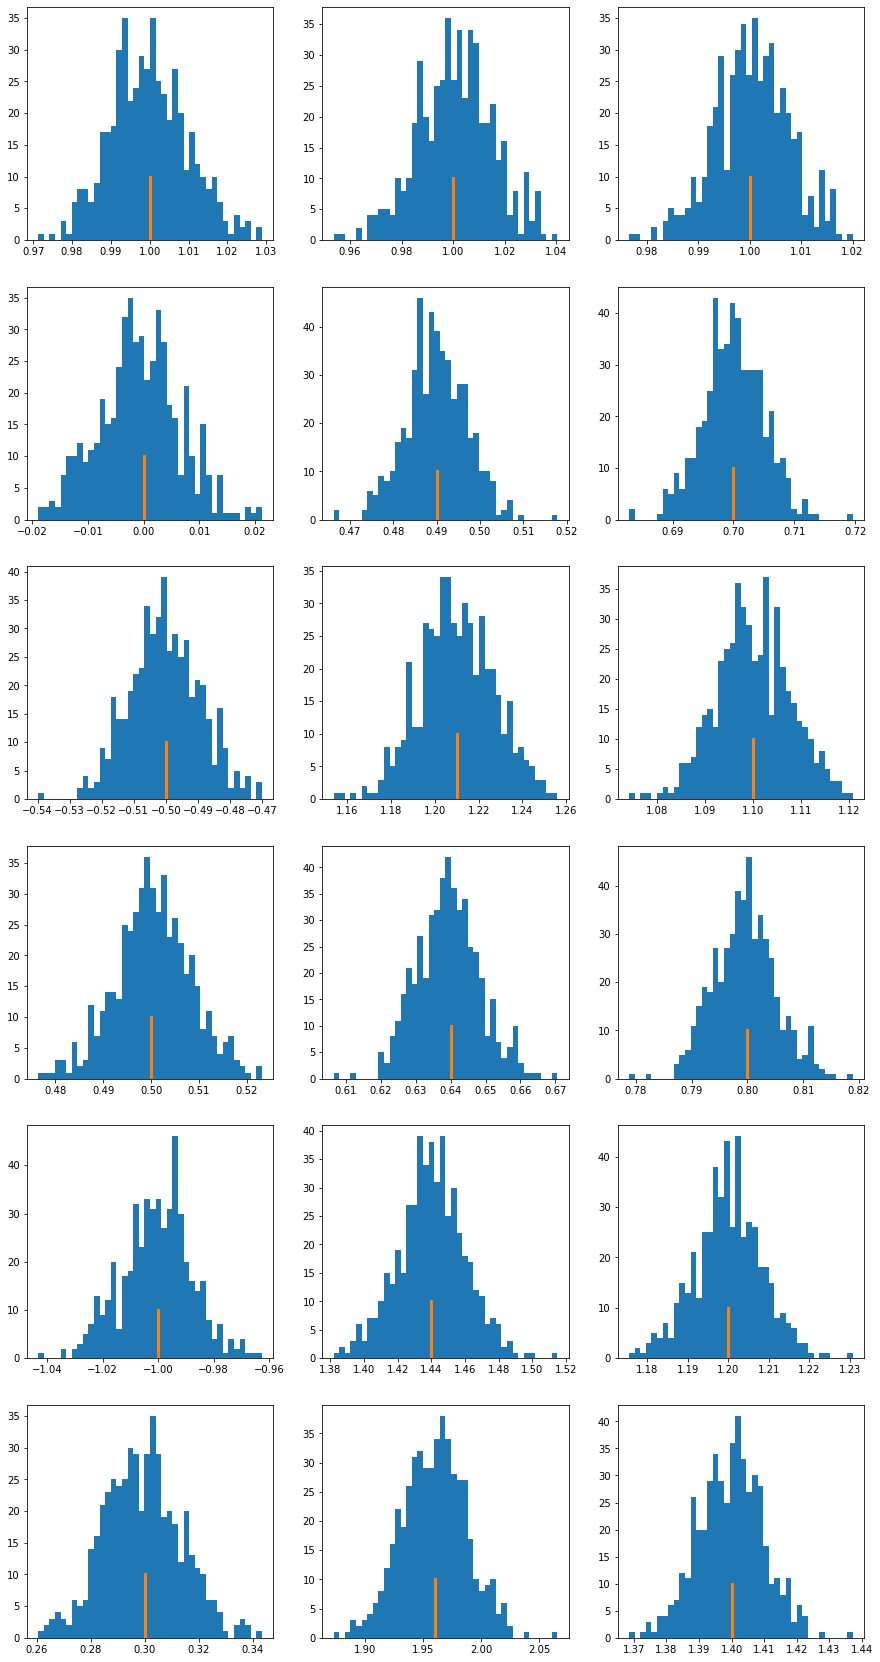

In [10]:
fig,ax = plt.subplots( ndim, 3, figsize=(3*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    thisax.hist( all_mean[i], bins=40)
    thisax.plot( (mc_mu[i], mc_mu[i]), (0,ymax), linewidth=3 )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    thisax.hist( all_cov[i][i], bins=40)
    thisax.plot( (mc_cov[i][i], mc_cov[i][i]), (0,ymax), linewidth=3 )


    
    if ndim > 1 :
        thisax = ax[i][2]
    else :
        thisax = ax[2]    
    thisax.hist( all_rms[i], bins=40)
    thisax.plot( (mc_sig[i], mc_sig[i]), (0,ymax), linewidth=3 )    
    
    
plt.show

In [11]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )
rms_mean_err = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )
rms_cov_err = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    rms_mean_err[fi] = rms_mean[fi] / np.sqrt(2*n_samples)
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" % 
          (fi, ave_mean[fi], mc_mu[fi], rms_mean[fi], rms_mean_err[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, mc_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, mc_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        rms_cov_err[fi1,fi2] = rms_cov[fi1,fi2]/np.sqrt(2*n_samples)
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" %
              (fi1, fi2, ave_cov[fi1,fi2], mc_cov[fi1,fi2], rms_cov[fi1,fi2], rms_cov_err[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.9998  (true   1.0000), rms  0.00984 +/- 0.00031
  feature 1  :  mean   ave  -0.0007  (true   0.0000), rms  0.00717 +/- 0.00023
  feature 2  :  mean   ave  -0.5003  (true  -0.5000), rms  0.01096 +/- 0.00035
  feature 3  :  mean   ave   0.5005  (true   0.5000), rms  0.00794 +/- 0.00025
  feature 4  :  mean   ave  -1.0005  (true  -1.0000), rms  0.01265 +/- 0.00040
  feature 5  :  mean   ave   0.2991  (true   0.3000), rms  0.01423 +/- 0.00045


  feature 0  :  RMS    ave   1.0005  (true   1.0000), rms   0.0072
  feature 1  :  RMS    ave   0.6999  (true   0.7000), rms   0.0050
  feature 2  :  RMS    ave   1.1000  (true   1.1000), rms   0.0077
  feature 3  :  RMS    ave   0.7996  (true   0.8000), rms   0.0056
  feature 4  :  RMS    ave   1.2001  (true   1.2000), rms   0.0083
  feature 5  :  RMS    ave   1.3998  (true   1.4000), rms   0.0100


  feature 0, 1  :  rho    ave   0.0997  (true   0.1000), rms   0.0101
  feature 0, 2  :  rho    ave   0.1996  (true   

In [12]:
sc_ave_mean_val = ave_mean
sc_ave_mean_rms = rms_mean
sc_ave_cov_val = ave_cov
sc_ave_cov_rms = rms_cov

In [13]:
sc_ave_cov_val

array([[ 1.00096544e+00,  6.98052211e-02,  2.19660326e-01,
        -2.39576272e-01, -4.84567440e-04, -1.34651711e-03],
       [ 0.00000000e+00,  4.89936993e-01, -1.95509029e-04,
        -1.11822165e-01,  2.51970517e-01,  9.76663082e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.20998426e+00,
         8.87185611e-02, -2.64587826e-01,  4.60991045e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.39328085e-01,  9.57363548e-02,  3.44220511e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.44021705e+00,  1.17628858e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.95950538e+00]])

In [14]:
print('\n\n')
print('  Simple direct calculation results from the bootstrap samples.\n')

for fi in range(ndim) :
    print('  feature %d  mean:   %8.4f  (true %8.4f) RMS  %8.4f'
         % (fi, sc_ave_mean_val[fi], mc_mu[fi], sc_ave_mean_rms[fi]) )
    
print('\n')

for i in range(ndim) :
    for j in range(i,ndim) :
        print('   %d, %d  cov:   %8.4f  (true %8.4f) RMS  %8.4f'
              % ( i, j, sc_ave_cov_val[i][j], mc_cov[i,j], sc_ave_cov_rms[i][j]) )

print('\n\n')




  Simple direct calculation results from the bootstrap samples.

  feature 0  mean:     0.9998  (true   1.0000) RMS    0.0098
  feature 1  mean:    -0.0007  (true   0.0000) RMS    0.0072
  feature 2  mean:    -0.5003  (true  -0.5000) RMS    0.0110
  feature 3  mean:     0.5005  (true   0.5000) RMS    0.0079
  feature 4  mean:    -1.0005  (true  -1.0000) RMS    0.0127
  feature 5  mean:     0.2991  (true   0.3000) RMS    0.0142


   0, 0  cov:     1.0010  (true   1.0000) RMS    0.0144
   0, 1  cov:     0.0698  (true   0.0700) RMS    0.0072
   0, 2  cov:     0.2197  (true   0.2200) RMS    0.0107
   0, 3  cov:    -0.2396  (true  -0.2400) RMS    0.0082
   0, 4  cov:    -0.0005  (true   0.0000) RMS    0.0119
   0, 5  cov:    -0.0013  (true   0.0000) RMS    0.0138
   1, 1  cov:     0.4899  (true   0.4900) RMS    0.0070
   1, 2  cov:    -0.0002  (true   0.0000) RMS    0.0075
   1, 3  cov:    -0.1118  (true  -0.1120) RMS    0.0057
   1, 4  cov:     0.2520  (true   0.2520) RMS    0.0085
   1

In [15]:
width_factor_mean = 10
width_factor_cov = 10

###  Do it this way to keep all the RooRealVars in memory in separate objects (different elements in the dictionary).

In [16]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = sc_ave_cov_val[i][j]
        minval = sc_ave_cov_val[i][j] - width_factor_cov * sc_ave_cov_rms[i][j]
        maxval = sc_ave_cov_val[i][j] + width_factor_cov * sc_ave_cov_rms[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        


 parameter cov00  min   0.8568, max   1.1451
 parameter cov01  min  -0.0025, max   0.1421
 parameter cov02  min   0.1125, max   0.3268
 parameter cov03  min  -0.3219, max  -0.1573
 parameter cov04  min  -0.1196, max   0.1186
 parameter cov05  min  -0.1390, max   0.1363
 parameter cov11  min   0.4202, max   0.5597
 parameter cov12  min  -0.0754, max   0.0750
 parameter cov13  min  -0.1693, max  -0.0544
 parameter cov14  min   0.1666, max   0.3373
 parameter cov15  min   0.0019, max   0.1934
 parameter cov22  min   1.0408, max   1.3791
 parameter cov23  min  -0.0015, max   0.1790
 parameter cov24  min  -0.3911, max  -0.1381
 parameter cov25  min   0.3022, max   0.6198
 parameter cov33  min   0.5492, max   0.7295
 parameter cov34  min  -0.0051, max   0.1966
 parameter cov35  min  -0.1136, max   0.1143
 parameter cov44  min   1.2398, max   1.6406
 parameter cov45  min   0.9730, max   1.3795
 parameter cov55  min   1.6801, max   2.2389
RooRealVar::cov00 = 1.00097  L(0.856782 - 1.14515) 
Roo

In [17]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [18]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     1.001
  0, 1 :   1 :  cov01     0.070
  0, 2 :   2 :  cov02     0.220
  0, 3 :   3 :  cov03    -0.240
  0, 4 :   4 :  cov04    -0.000
  0, 5 :   5 :  cov05    -0.001
  1, 1 :   6 :  cov11     0.490
  1, 2 :   7 :  cov12    -0.000
  1, 3 :   8 :  cov13    -0.112
  1, 4 :   9 :  cov14     0.252
  1, 5 :  10 :  cov15     0.098
  2, 2 :  11 :  cov22     1.210
  2, 3 :  12 :  cov23     0.089
  2, 4 :  13 :  cov24    -0.265
  2, 5 :  14 :  cov25     0.461
  3, 3 :  15 :  cov33     0.639
  3, 4 :  16 :  cov34     0.096
  3, 5 :  17 :  cov35     0.000
  4, 4 :  18 :  cov44     1.440
  4, 5 :  19 :  cov45     1.176
  5, 5 :  20 :  cov55     1.960


### The Dict keeps the variables defined in memory

In [19]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = sc_ave_mean_val[i]
    minval = sc_ave_mean_val[i] - width_factor_mean * sc_ave_mean_rms[i]
    maxval = sc_ave_mean_val[i] + width_factor_mean * sc_ave_mean_rms[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min   0.9013, max   1.0982
  feature 1  mean :  min  -0.0724, max   0.0710
  feature 2  mean :  min  -0.6099, max  -0.3907
  feature 3  mean :  min   0.4210, max   0.5799
  feature 4  mean :  min  -1.1270, max  -0.8740
  feature 5  mean :  min   0.1568, max   0.4415
RooRealVar::mu_x0 = 0.999765  L(0.901335 - 1.09819) 
RooRealVar::mu_x1 = -0.000714045  L(-0.072418 - 0.0709899) 
RooRealVar::mu_x2 = -0.500314  L(-0.609911 - -0.390718) 
RooRealVar::mu_x3 = 0.500463  L(0.421049 - 0.579877) 
RooRealVar::mu_x4 = -1.00049  L(-1.12701 - -0.873979) 
RooRealVar::mu_x5 = 0.299147  L(0.15684 - 0.441454) 


In [20]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 1.000965
  Setting _prevCovVals[1] to 0.069805
  Setting _prevCovVals[2] to 0.219660
  Setting _prevCovVals[3] to -0.239576
  Setting _prevCovVals[4] to -0.000485
  Setting _prevCovVals[5] to -0.001347
  Setting _prevCovVals[6] to 0.489937
  Setting _prevCovVals[7] to -0.000196
  Setting _prevCovVals[8] to -0.111822
  Setting _prevCovVals[9] to 0.251971
  Setting _prevCovVals[10] to 0.097666
  Setting _prevCovVals[11] to 1.209984
  Setting _prevCovVals[12] to 0.088719
  Setting _prevCovVals[13] to -0.264588
  Setting _prevCovVals[14] to 0.460991
  Setting _prevCovVals[15] to 0.639328
  Setting _prevCovVals[16] to 0.095736
  Setting _prevCovVals[17] to 0.000344
  Setting _prevCovVals[18] to 1.440217
  Setting _prevCovVals[19] to 1.176289
  Setting _prevCovVals[20] to 1.959505
 i,j = 0,0
 i,j = 0,1
 i,j = 0,2
 i,j = 0,3
 i,j = 0,4
 i,j = 0,5
 i,j = 1,1
 i,j = 1,2
 i,j = 1,3
 i,j = 1,4
 i,j = 1,5
 i,j = 2,2
 i,j = 2,3
 i,j = 2,4
 i,j = 2,5
 i,j = 3,3
 i,j = 3,

In [21]:
xVec.Print("V")

  1) RooRealVar:: x0 = 0
  2) RooRealVar:: x1 = 0
  3) RooRealVar:: x2 = 0
  4) RooRealVar:: x3 = 0
  5) RooRealVar:: x4 = 0
  6) RooRealVar:: x5 = 0


In [22]:
data_test = ROOT.RooDataSet( "data_test", "data_test", ROOT.RooArgSet(xVec, weight) , ROOT.RooFit.WeightVar("weight"))
ROOT.SetOwnership( data_test, True )

In [23]:
%%time

for i in range( len(dummy_weights) ) :
    if i % (len(dummy_weights)/100 ) == 0 : print( " %9d / %9d  (%6.0f)%%" % (i, len(dummy_weights), 100*i/len(dummy_weights)))
    for j in range( ndim ) :
        xVec[j].setVal( mc_pts[i,j] )
    weight.setVal( dummy_weights[i])
    data_test.add( ROOT.RooArgSet(xVec, weight), weight.getVal() )

         0 /     10000  (     0)%
       100 /     10000  (     1)%
       200 /     10000  (     2)%
       300 /     10000  (     3)%
       400 /     10000  (     4)%
       500 /     10000  (     5)%
       600 /     10000  (     6)%
       700 /     10000  (     7)%
       800 /     10000  (     8)%
       900 /     10000  (     9)%
      1000 /     10000  (    10)%
      1100 /     10000  (    11)%
      1200 /     10000  (    12)%
      1300 /     10000  (    13)%
      1400 /     10000  (    14)%
      1500 /     10000  (    15)%
      1600 /     10000  (    16)%
      1700 /     10000  (    17)%
      1800 /     10000  (    18)%
      1900 /     10000  (    19)%
      2000 /     10000  (    20)%
      2100 /     10000  (    21)%
      2200 /     10000  (    22)%
      2300 /     10000  (    23)%
      2400 /     10000  (    24)%
      2500 /     10000  (    25)%
      2600 /     10000  (    26)%
      2700 /     10000  (    27)%
      2800 /     10000  (    28)%
      2900 /  

In [24]:
data_test

In [25]:
data_test.Print("V")

DataStore data_test (data_test)
  Contains 10000 entries
  Observables: 
    1)  x0 = 1.12894  L(-10 - 10)  "x0"
    2)  x1 = 1.03913  L(-10 - 10)  "x1"
    3)  x2 = -1.03602  L(-10 - 10)  "x2"
    4)  x3 = 0.393288  L(-10 - 10)  "x3"
    5)  x4 = 0.0304313  L(-10 - 10)  "x4"
    6)  x5 = 0.167032  L(-10 - 10)  "x5"
  Dataset variable "weight" is interpreted as the event weight


In [26]:
data_test.get(0).Print("V")

  1) RooRealVar:: x0 = 2.26633
  2) RooRealVar:: x1 = 0.127458
  3) RooRealVar:: x2 = 0.437208
  4) RooRealVar:: x3 = 1.39764
  5) RooRealVar:: x4 = -0.186416
  6) RooRealVar:: x5 = 0.755385


In [27]:

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        if ( i == j ) : continue
        vname = "cov%d%d" % (i,j)
        #########covRAL.find(vname).setConstant()

In [28]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 1.00097
  2) RooRealVar:: cov01 = 0.0698052
  3) RooRealVar:: cov02 = 0.21966
  4) RooRealVar:: cov03 = -0.239576
  5) RooRealVar:: cov04 = -0.000484567
  6) RooRealVar:: cov05 = -0.00134652
  7) RooRealVar:: cov11 = 0.489937
  8) RooRealVar:: cov12 = -0.000195509
  9) RooRealVar:: cov13 = -0.111822
 10) RooRealVar:: cov14 = 0.251971
 11) RooRealVar:: cov15 = 0.0976663
 12) RooRealVar:: cov22 = 1.20998
 13) RooRealVar:: cov23 = 0.0887186
 14) RooRealVar:: cov24 = -0.264588
 15) RooRealVar:: cov25 = 0.460991
 16) RooRealVar:: cov33 = 0.639328
 17) RooRealVar:: cov34 = 0.0957364
 18) RooRealVar:: cov35 = 0.000344221
 19) RooRealVar:: cov44 = 1.44022
 20) RooRealVar:: cov45 = 1.17629
 21) RooRealVar:: cov55 = 1.95951


In [29]:
covRAL.find("cov00").isConstant()

False

In [30]:
%%time

rfr = rmvg.fitTo( data_test, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
ROOT.SetOwnership( rfr, True )


CPU times: user 308 ms, sys: 880 ms, total: 1.19 s
Wall time: 2.11 s
  copy constructor, Setting _prevCovVals[0] to 1.000965
  copy constructor, Setting _prevCovVals[1] to 0.069805
  copy constructor, Setting _prevCovVals[2] to 0.219660
  copy constructor, Setting _prevCovVals[3] to -0.239576
  copy constructor, Setting _prevCovVals[4] to -0.000485
  copy constructor, Setting _prevCovVals[5] to -0.001347
  copy constructor, Setting _prevCovVals[6] to 0.489937
  copy constructor, Setting _prevCovVals[7] to -0.000196
  copy constructor, Setting _prevCovVals[8] to -0.111822
  copy constructor, Setting _prevCovVals[9] to 0.251971
  copy constructor, Setting _prevCovVals[10] to 0.097666
  copy constructor, Setting _prevCovVals[11] to 1.209984
  copy constructor, Setting _prevCovVals[12] to 0.088719
  copy constructor, Setting _prevCovVals[13] to -0.264588
  copy constructor, Setting _prevCovVals[14] to 0.460991
  copy constructor, Setting _prevCovVals[15] to 0.639328
  copy constructor, Set

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       85089.19755 Edm =  -8.156806196e-06 NCalls =    113
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 76297.5328
  Edm           : 12.07719452
  Internal parameters:	[    0.03169297658                0 -6.478107981e-17                0  2.862293735e-17  2.677979366e-17                0  3.599551213e-17  -1.20780122e-16                0....                 0]	
  Internal gradient  :	[   -0.02386133877     -19.17917327      2.402891797     0.7352916038      22.82939997     -15.11220787      13.53051517     -5.062382807      11.41654106     -44.35047566....       16.40936266]	
  Internal covariance matrix:
[[     0.01197081              0              0              0              0              0    

In [31]:
rfr.Print()


  RooFitResult: minimized FCN value: 76284.6, estimated distance to minimum: 0.000358325
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                 cov00    1.0145e+00 +/-  1.43e-02
                 cov01    8.4007e-02 +/-  7.09e-03
                 cov02    2.3556e-01 +/-  1.14e-02
                 cov03   -2.4664e-01 +/-  8.29e-03
                 cov04   -1.2006e-02 +/-  1.22e-02
                 cov05   -1.1373e-02 +/-  1.39e-02
                 cov11    4.9251e-01 +/-  6.97e-03
                 cov12   -2.8757e-03 +/-  7.70e-03
                 cov13   -1.1690e-01 +/-  5.65e-03
                 cov14    2.5178e-01 +/-  8.86e-03
                 cov15    8.1762e-02 +/-  9.76e-03
                 cov22    1.2117e+00 +/-  1.70e-02
                 cov23    7.9243e-02 +/-  8.89e-03
                 cov24 

In [32]:
rfr.status()

0

In [33]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 1.01448 +/- 0.0142978
  2) RooRealVar:: cov01 = 0.0840074 +/- 0.00709284
  3) RooRealVar:: cov02 = 0.235561 +/- 0.0114192
  4) RooRealVar:: cov03 = -0.246637 +/- 0.00828551
  5) RooRealVar:: cov04 = -0.0120058 +/- 0.012171
  6) RooRealVar:: cov05 = -0.0113733 +/- 0.0139498
  7) RooRealVar:: cov11 = 0.49251 +/- 0.00696734
  8) RooRealVar:: cov12 = -0.00287565 +/- 0.00770282
  9) RooRealVar:: cov13 = -0.116905 +/- 0.00565158
 10) RooRealVar:: cov14 = 0.251777 +/- 0.00886209
 11) RooRealVar:: cov15 = 0.0817618 +/- 0.00976362
 12) RooRealVar:: cov22 = 1.2117 +/- 0.0169927
 13) RooRealVar:: cov23 = 0.0792427 +/- 0.00888934
 14) RooRealVar:: cov24 = -0.268946 +/- 0.0124923
 15) RooRealVar:: cov25 = 0.444698 +/- 0.0157448
 16) RooRealVar:: cov33 = 0.630751 +/- 0.00885066
 17) RooRealVar:: cov34 = 0.100833 +/- 0.00969152
 18) RooRealVar:: cov35 = 0.016121 +/- 0.0109301
 19) RooRealVar:: cov44 = 1.43251 +/- 0.0192463
 20) RooRealVar:: cov45 = 1.16966 +/- 0.0198256
 21)

In [34]:
for i in range(ndim) :
    fit_mean = muDict["mu_x%d" % i].getVal()
    fit_mean_err = muDict["mu_x%d" % i].getError()
    print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
          (i, fit_mean, mc_mu[i], fit_mean_err, (fit_mean-mc_mu[i]), (fit_mean-mc_mu[i])/fit_mean_err) )

print("\n")

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        fit_cov = covdict["cov%d%d" % (i,j)].getVal()
        fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
        print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i,j, fit_cov, mc_cov[i][j], fit_cov_err, 
               (fit_cov-mc_cov[i][j]), (fit_cov-mc_cov[i][j])/fit_cov_err)  )

   0 :  mu =   1.0052   (true   1.0000) err   0.0101  diff   0.0052   diff/err   0.51
   1 :  mu =   0.0002   (true   0.0000) err   0.0070  diff   0.0002   diff/err   0.03
   2 :  mu =  -0.4982   (true  -0.5000) err   0.0110  diff   0.0018   diff/err   0.17
   3 :  mu =   0.4998   (true   0.5000) err   0.0079  diff  -0.0002   diff/err  -0.03
   4 :  mu =  -0.9995   (true  -1.0000) err   0.0120  diff   0.0005   diff/err   0.04
   5 :  mu =   0.2950   (true   0.3000) err   0.0139  diff  -0.0050   diff/err  -0.36


  0,  0 :  cov    1.0145  (true   1.0000) err   0.0143  diff   0.0145   diff/err   1.01
  0,  1 :  cov    0.0840  (true   0.0700) err   0.0071  diff   0.0140   diff/err   1.97
  0,  2 :  cov    0.2356  (true   0.2200) err   0.0114  diff   0.0156   diff/err   1.36
  0,  3 :  cov   -0.2466  (true  -0.2400) err   0.0083  diff  -0.0066   diff/err  -0.80
  0,  4 :  cov   -0.0120  (true   0.0000) err   0.0122  diff  -0.0120   diff/err  -0.99
  0,  5 :  cov   -0.0114  (true   0.0000) 

In [35]:

del data_test
del rfr
gc.collect()

45

In [36]:
#n_samples = np.min( [n_samples,50] )

In [37]:
fit_results_mean_val = np.zeros( shape=(ndim, n_samples ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_samples ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_samples ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_samples ) )
fit_status = np.zeros( n_samples )

In [38]:
%%time



for bi in range( n_samples ) :
    
    print("\n\n ---  sample %3d" % bi, flush=True )
    sys.stdout.flush()

    np.random.seed( random_seed*10000+bi )
    
    mc_pts = np.random.multivariate_normal(mc_mu, mc_cov, size=ngen_mc)
    
    dummy_weights = np.ones( shape=ngen_mc )
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(dummy_weights) )
    for i in range( len(dummy_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( mc_pts[i,j] )
        weight.setVal( dummy_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print('Initializing values of fit parameters.')
    for i in range(ndim) :
        muDict["mu_x%d" % i].setVal( sc_ave_mean_val[i] )
        muDict["mu_x%d" % i].Print()
    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            covdict["cov%d%d" % (i,j)].setVal( sc_ave_cov_val[i,j] )
            covdict["cov%d%d" % (i,j)].Print()
    print('')
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, mc_mu[i], fit_mean_err, (fit_mean-mc_mu[i]), (fit_mean-mc_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, mc_cov[i][j], fit_cov_err, 
                   (fit_cov-mc_cov[i][j]), (fit_cov-mc_cov[i][j])/fit_cov_err)  )
    
    fit_status[bi] = rfr.status()
    
    print('\n Fit status: %d \n' % fit_status[bi])
    print("Cleaning up.")
    del dummy_weights
    del data_weighted
    del rfr
    gc.collect()
        
        



 ---  sample   0
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0223   (true   1.0000) err   0.0100  diff   0.0223   diff/err   2.24
   1 :  mu =  -0.0014   (true   0.0000) err   0.0070  diff  -0.0014   diff/err  -0.20
   2 :  mu =  -0.4908   (true  -0.5000) err   0.0111  diff   0.0092   diff/err   0.83
   3 :  mu =   0.4973   (true   0.5000) err   0.0080  diff  -0.0027   diff/err  -0.33
   4 :  mu =  -0.9977   (true  -1.0000) err   0.0120  diff   0.0023   diff/err   0.19
   5 :  mu =   0.3000   (true   0.3000) err   0.0141  diff  -0.0000   diff/err  -0.00


  0,  0 :  cov    0.9987  (true   1.0000) err   0.0141  diff  -0.0013   diff/err  -0.09
  0,  1 :  cov    0.0709  (true   0.0700) err   0.0070  diff   0.0009   diff/err   0.13
  0,  2 :  cov    0.2337  (true   0.2200) err   0.0114  diff   0.0137   diff/err   1.20
  0,  3 :  cov   -0.2488  (true  -0.2400) err   0.0083  diff  -0.0088   diff/err  -1.05
  0,  4 :  cov   

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0049   (true   1.0000) err   0.0099  diff   0.0049   diff/err   0.49
   1 :  mu =   0.0000   (true   0.0000) err   0.0070  diff   0.0000   diff/err   0.00
   2 :  mu =  -0.5153   (true  -0.5000) err   0.0110  diff  -0.0153   diff/err  -1.39
   3 :  mu =   0.4956   (true   0.5000) err   0.0080  diff  -0.0044   diff/err  -0.54
   4 :  mu =  -0.9902   (true  -1.0000) err   0.0118  diff   0.0098   diff/err   0.83
   5 :  mu =   0.2979   (true   0.3000) err   0.0139  diff  -0.0021   diff/err  -0.15


  0,  0 :  cov    0.9929  (true   1.0000) err   0.0140  diff  -0.0071   diff/err  -0.51
  0,  1 :  cov    0.0725  (true   0.0700) err   0.0070  diff   0.0025   diff/err   0.35
  0,  2 :  cov    0.2156  (true   0.2200) err   0.0112  diff  -0.0044   diff/err  -0.39
  0,  3 :  cov   -0.2478  (true  -0.2400) err   0.0083  diff  -0.0078   diff/err  -0.94
  0,  4 :  cov    0.0003  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0145   (true   1.0000) err   0.0100  diff   0.0145   diff/err   1.45
   1 :  mu =  -0.0078   (true   0.0000) err   0.0070  diff  -0.0078   diff/err  -1.11
   2 :  mu =  -0.4705   (true  -0.5000) err   0.0110  diff   0.0295   diff/err   2.69
   3 :  mu =   0.4964   (true   0.5000) err   0.0080  diff  -0.0036   diff/err  -0.45
   4 :  mu =  -1.0026   (true  -1.0000) err   0.0121  diff  -0.0026   diff/err  -0.22
   5 :  mu =   0.3203   (true   0.3000) err   0.0141  diff   0.0203   diff/err   1.45


  0,  0 :  cov    1.0122  (true   1.0000) err   0.0143  diff   0.0122   diff/err   0.85
  0,  1 :  cov    0.0634  (true   0.0700) err   0.0071  diff  -0.0066   diff/err  -0.93
  0,  2 :  cov    0.2100  (true   0.2200) err   0.0112  diff  -0.0100   diff/err  -0.89
  0,  3 :  cov   -0.2415  (true  -0.2400) err   0.0084  diff  -0.0015   diff/err  -0.18
  0,  4 :  cov   -0.0017  (true   0.

  1,  4 :  cov    0.2383  (true   0.2520) err   0.0087  diff  -0.0137   diff/err  -1.58
  1,  5 :  cov    0.0852  (true   0.0980) err   0.0097  diff  -0.0128   diff/err  -1.31
  2,  2 :  cov    1.2279  (true   1.2100) err   0.0173  diff   0.0179   diff/err   1.04
  2,  3 :  cov    0.0852  (true   0.0880) err   0.0089  diff  -0.0028   diff/err  -0.31
  2,  4 :  cov   -0.2779  (true  -0.2640) err   0.0133  diff  -0.0139   diff/err  -1.04
  2,  5 :  cov    0.4527  (true   0.4620) err   0.0160  diff  -0.0093   diff/err  -0.58
  3,  3 :  cov    0.6413  (true   0.6400) err   0.0090  diff   0.0013   diff/err   0.14
  3,  4 :  cov    0.1113  (true   0.0960) err   0.0096  diff   0.0153   diff/err   1.59
  3,  5 :  cov    0.0157  (true   0.0000) err   0.0111  diff   0.0157   diff/err   1.41
  4,  4 :  cov    1.4276  (true   1.4400) err   0.0202  diff  -0.0124   diff/err  -0.62
  4,  5 :  cov    1.1575  (true   1.1760) err   0.0203  diff  -0.0185   diff/err  -0.91
  5,  5 :  cov    1.9251  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9977   (true   1.0000) err   0.0100  diff  -0.0023   diff/err  -0.23
   1 :  mu =   0.0005   (true   0.0000) err   0.0070  diff   0.0005   diff/err   0.07
   2 :  mu =  -0.4993   (true  -0.5000) err   0.0110  diff   0.0007   diff/err   0.06
   3 :  mu =   0.5093   (true   0.5000) err   0.0079  diff   0.0093   diff/err   1.17
   4 :  mu =  -1.0014   (true  -1.0000) err   0.0119  diff  -0.0014   diff/err  -0.12
   5 :  mu =   0.2978   (true   0.3000) err   0.0140  diff  -0.0022   diff/err  -0.16


  0,  0 :  cov    0.9980  (true   1.0000) err   0.0141  diff  -0.0020   diff/err  -0.14
  0,  1 :  cov    0.0636  (true   0.0700) err   0.0070  diff  -0.0064   diff/err  -0.91
  0,  2 :  cov    0.2264  (true   0.2200) err   0.0114  diff   0.0064   diff/err   0.56
  0,  3 :  cov   -0.2271  (true  -0.2400) err   0.0082  diff   0.0129   diff/err   1.57
  0,  4 :  cov    0.0071  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0027   (true   1.0000) err   0.0100  diff   0.0027   diff/err   0.27
   1 :  mu =  -0.0021   (true   0.0000) err   0.0069  diff  -0.0021   diff/err  -0.30
   2 :  mu =  -0.4772   (true  -0.5000) err   0.0111  diff   0.0228   diff/err   2.05
   3 :  mu =   0.4986   (true   0.5000) err   0.0080  diff  -0.0014   diff/err  -0.17
   4 :  mu =  -1.0077   (true  -1.0000) err   0.0119  diff  -0.0077   diff/err  -0.65
   5 :  mu =   0.3192   (true   0.3000) err   0.0139  diff   0.0192   diff/err   1.38


  0,  0 :  cov    1.0068  (true   1.0000) err   0.0142  diff   0.0068   diff/err   0.48
  0,  1 :  cov    0.0648  (true   0.0700) err   0.0070  diff  -0.0052   diff/err  -0.75
  0,  2 :  cov    0.2145  (true   0.2200) err   0.0114  diff  -0.0055   diff/err  -0.49
  0,  3 :  cov   -0.2285  (true  -0.2400) err   0.0083  diff   0.0115   diff/err   1.39
  0,  4 :  cov    0.0192  (true   0.

 ---  sample  23
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0055   (true   1.0000) err   0.0100  diff   0.0055   diff/err   0.55
   1 :  mu =  -0.0070   (true   0.0000) err   0.0070  diff  -0.0070   diff/err  -0.99
   2 :  mu =  -0.4940   (true  -0.5000) err   0.0111  diff   0.0060   diff/err   0.54
   3 :  mu =   0.4987   (true   0.5000) err   0.0081  diff  -0.0013   diff/err  -0.16
   4 :  mu =  -1.0187   (true  -1.0000) err   0.0120  diff  -0.0187   diff/err  -1.56
   5 :  mu =   0.2835   (true   0.3000) err   0.0139  diff  -0.0165   diff/err  -1.18


  0,  0 :  cov    0.9942  (true   1.0000) err   0.0140  diff  -0.0058   diff/err  -0.42
  0,  1 :  cov    0.0800  (true   0.0700) err   0.0071  diff   0.0100   diff/err   1.42
  0,  2 :  cov    0.2145  (true   0.2200) err   0.0113  diff  -0.0055   diff/err  -0.49
  0,  3 :  cov   -0.2432  (true  -0.2400) err   0.0084  diff  -0.0032   diff/err  -0.38
  0,  4 :  cov    0

  1,  2 :  cov   -0.0138  (true   0.0000) err   0.0077  diff  -0.0138   diff/err  -1.80
  1,  3 :  cov   -0.0985  (true  -0.1120) err   0.0056  diff   0.0135   diff/err   2.40
  1,  4 :  cov    0.2479  (true   0.2520) err   0.0089  diff  -0.0041   diff/err  -0.46
  1,  5 :  cov    0.0822  (true   0.0980) err   0.0098  diff  -0.0158   diff/err  -1.60
  2,  2 :  cov    1.2190  (true   1.2100) err   0.0172  diff   0.0090   diff/err   0.52
  2,  3 :  cov    0.0852  (true   0.0880) err   0.0089  diff  -0.0028   diff/err  -0.32
  2,  4 :  cov   -0.2837  (true  -0.2640) err   0.0137  diff  -0.0197   diff/err  -1.43
  2,  5 :  cov    0.4417  (true   0.4620) err   0.0161  diff  -0.0203   diff/err  -1.26
  3,  3 :  cov    0.6381  (true   0.6400) err   0.0090  diff  -0.0019   diff/err  -0.21
  3,  4 :  cov    0.1063  (true   0.0960) err   0.0099  diff   0.0103   diff/err   1.04
  3,  5 :  cov    0.0027  (true   0.0000) err   0.0112  diff   0.0027   diff/err   0.24
  4,  4 :  cov    1.4955  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0038   (true   1.0000) err   0.0100  diff   0.0038   diff/err   0.38
   1 :  mu =   0.0109   (true   0.0000) err   0.0070  diff   0.0109   diff/err   1.54
   2 :  mu =  -0.4833   (true  -0.5000) err   0.0109  diff   0.0167   diff/err   1.54
   3 :  mu =   0.4944   (true   0.5000) err   0.0080  diff  -0.0056   diff/err  -0.70
   4 :  mu =  -1.0044   (true  -1.0000) err   0.0119  diff  -0.0044   diff/err  -0.37
   5 :  mu =   0.3097   (true   0.3000) err   0.0139  diff   0.0097   diff/err   0.70


  0,  0 :  cov    0.9985  (true   1.0000) err   0.0141  diff  -0.0015   diff/err  -0.11
  0,  1 :  cov    0.0689  (true   0.0700) err   0.0071  diff  -0.0011   diff/err  -0.16
  0,  2 :  cov    0.2104  (true   0.2200) err   0.0111  diff  -0.0096   diff/err  -0.86
  0,  3 :  cov   -0.2392  (true  -0.2400) err   0.0084  diff   0.0008   diff/err   0.10
  0,  4 :  cov   -0.0070  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0018   (true   1.0000) err   0.0100  diff   0.0018   diff/err   0.18
   1 :  mu =  -0.0101   (true   0.0000) err   0.0070  diff  -0.0101   diff/err  -1.45
   2 :  mu =  -0.5011   (true  -0.5000) err   0.0110  diff  -0.0011   diff/err  -0.10
   3 :  mu =   0.4889   (true   0.5000) err   0.0079  diff  -0.0111   diff/err  -1.40
   4 :  mu =  -1.0268   (true  -1.0000) err   0.0120  diff  -0.0268   diff/err  -2.23
   5 :  mu =   0.2839   (true   0.3000) err   0.0139  diff  -0.0161   diff/err  -1.16


  0,  0 :  cov    0.9960  (true   1.0000) err   0.0141  diff  -0.0040   diff/err  -0.28
  0,  1 :  cov    0.0840  (true   0.0700) err   0.0070  diff   0.0140   diff/err   2.00
  0,  2 :  cov    0.2225  (true   0.2200) err   0.0113  diff   0.0025   diff/err   0.22
  0,  3 :  cov   -0.2252  (true  -0.2400) err   0.0082  diff   0.0148   diff/err   1.81
  0,  4 :  cov    0.0057  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0118   (true   1.0000) err   0.0099  diff   0.0118   diff/err   1.19
   1 :  mu =   0.0034   (true   0.0000) err   0.0070  diff   0.0034   diff/err   0.48
   2 :  mu =  -0.4838   (true  -0.5000) err   0.0108  diff   0.0162   diff/err   1.49
   3 :  mu =   0.5059   (true   0.5000) err   0.0080  diff   0.0059   diff/err   0.74
   4 :  mu =  -1.0080   (true  -1.0000) err   0.0120  diff  -0.0080   diff/err  -0.67
   5 :  mu =   0.2988   (true   0.3000) err   0.0139  diff  -0.0012   diff/err  -0.09


  0,  0 :  cov    0.9879  (true   1.0000) err   0.0139  diff  -0.0121   diff/err  -0.87
  0,  1 :  cov    0.0709  (true   0.0700) err   0.0070  diff   0.0009   diff/err   0.13
  0,  2 :  cov    0.2153  (true   0.2200) err   0.0110  diff  -0.0047   diff/err  -0.42
  0,  3 :  cov   -0.2283  (true  -0.2400) err   0.0082  diff   0.0117   diff/err   1.42
  0,  4 :  cov   -0.0041  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0136   (true   1.0000) err   0.0100  diff   0.0136   diff/err   1.37
   1 :  mu =  -0.0085   (true   0.0000) err   0.0070  diff  -0.0085   diff/err  -1.22
   2 :  mu =  -0.4954   (true  -0.5000) err   0.0110  diff   0.0046   diff/err   0.42
   3 :  mu =   0.5090   (true   0.5000) err   0.0080  diff   0.0090   diff/err   1.13
   4 :  mu =  -0.9964   (true  -1.0000) err   0.0120  diff   0.0036   diff/err   0.30
   5 :  mu =   0.3018   (true   0.3000) err   0.0139  diff   0.0018   diff/err   0.13


  0,  0 :  cov    0.9973  (true   1.0000) err   0.0140  diff  -0.0027   diff/err  -0.19
  0,  1 :  cov    0.0714  (true   0.0700) err   0.0070  diff   0.0014   diff/err   0.20
  0,  2 :  cov    0.2183  (true   0.2200) err   0.0113  diff  -0.0017   diff/err  -0.15
  0,  3 :  cov   -0.2480  (true  -0.2400) err   0.0083  diff  -0.0080   diff/err  -0.97
  0,  4 :  cov    0.0090  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9959   (true   1.0000) err   0.0100  diff  -0.0041   diff/err  -0.41
   1 :  mu =  -0.0021   (true   0.0000) err   0.0070  diff  -0.0021   diff/err  -0.29
   2 :  mu =  -0.4946   (true  -0.5000) err   0.0110  diff   0.0054   diff/err   0.50
   3 :  mu =   0.4805   (true   0.5000) err   0.0080  diff  -0.0195   diff/err  -2.44
   4 :  mu =  -1.0189   (true  -1.0000) err   0.0121  diff  -0.0189   diff/err  -1.56
   5 :  mu =   0.3088   (true   0.3000) err   0.0140  diff   0.0088   diff/err   0.63


  0,  0 :  cov    1.0099  (true   1.0000) err   0.0143  diff   0.0099   diff/err   0.70
  0,  1 :  cov    0.0755  (true   0.0700) err   0.0071  diff   0.0055   diff/err   0.77
  0,  2 :  cov    0.2074  (true   0.2200) err   0.0112  diff  -0.0126   diff/err  -1.13
  0,  3 :  cov   -0.2430  (true  -0.2400) err   0.0084  diff  -0.0030   diff/err  -0.36
  0,  4 :  cov    0.0020  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0143   (true   1.0000) err   0.0100  diff   0.0143   diff/err   1.44
   1 :  mu =   0.0028   (true   0.0000) err   0.0070  diff   0.0028   diff/err   0.41
   2 :  mu =  -0.4981   (true  -0.5000) err   0.0110  diff   0.0019   diff/err   0.17
   3 :  mu =   0.4983   (true   0.5000) err   0.0081  diff  -0.0017   diff/err  -0.20
   4 :  mu =  -1.0026   (true  -1.0000) err   0.0119  diff  -0.0026   diff/err  -0.22
   5 :  mu =   0.2977   (true   0.3000) err   0.0139  diff  -0.0023   diff/err  -0.16


  0,  0 :  cov    0.9958  (true   1.0000) err   0.0141  diff  -0.0042   diff/err  -0.30
  0,  1 :  cov    0.0763  (true   0.0700) err   0.0070  diff   0.0063   diff/err   0.89
  0,  2 :  cov    0.2137  (true   0.2200) err   0.0112  diff  -0.0063   diff/err  -0.56
  0,  3 :  cov   -0.2514  (true  -0.2400) err   0.0085  diff  -0.0114   diff/err  -1.34
  0,  4 :  cov   -0.0098  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0038   (true   1.0000) err   0.0101  diff   0.0038   diff/err   0.38
   1 :  mu =   0.0085   (true   0.0000) err   0.0070  diff   0.0085   diff/err   1.20
   2 :  mu =  -0.5108   (true  -0.5000) err   0.0111  diff  -0.0108   diff/err  -0.97
   3 :  mu =   0.4903   (true   0.5000) err   0.0080  diff  -0.0097   diff/err  -1.22
   4 :  mu =  -1.0030   (true  -1.0000) err   0.0120  diff  -0.0030   diff/err  -0.25
   5 :  mu =   0.2884   (true   0.3000) err   0.0141  diff  -0.0116   diff/err  -0.82


  0,  0 :  cov    1.0190  (true   1.0000) err   0.0144  diff   0.0190   diff/err   1.32
  0,  1 :  cov    0.0749  (true   0.0700) err   0.0072  diff   0.0049   diff/err   0.68
  0,  2 :  cov    0.2269  (true   0.2200) err   0.0114  diff   0.0069   diff/err   0.60
  0,  3 :  cov   -0.2432  (true  -0.2400) err   0.0084  diff  -0.0032   diff/err  -0.38
  0,  4 :  cov    0.0082  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9918   (true   1.0000) err   0.0100  diff  -0.0082   diff/err  -0.82
   1 :  mu =   0.0012   (true   0.0000) err   0.0069  diff   0.0012   diff/err   0.18
   2 :  mu =  -0.5164   (true  -0.5000) err   0.0111  diff  -0.0164   diff/err  -1.47
   3 :  mu =   0.4890   (true   0.5000) err   0.0079  diff  -0.0110   diff/err  -1.39
   4 :  mu =  -0.9916   (true  -1.0000) err   0.0119  diff   0.0084   diff/err   0.70
   5 :  mu =   0.2891   (true   0.3000) err   0.0140  diff  -0.0109   diff/err  -0.78


  0,  0 :  cov    0.9966  (true   1.0000) err   0.0141  diff  -0.0034   diff/err  -0.24
  0,  1 :  cov    0.0708  (true   0.0700) err   0.0070  diff   0.0008   diff/err   0.12
  0,  2 :  cov    0.2277  (true   0.2200) err   0.0113  diff   0.0077   diff/err   0.68
  0,  3 :  cov   -0.2309  (true  -0.2400) err   0.0082  diff   0.0091   diff/err   1.10
  0,  4 :  cov    0.0033  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9877   (true   1.0000) err   0.0101  diff  -0.0123   diff/err  -1.22
   1 :  mu =  -0.0036   (true   0.0000) err   0.0069  diff  -0.0036   diff/err  -0.52
   2 :  mu =  -0.5114   (true  -0.5000) err   0.0110  diff  -0.0114   diff/err  -1.03
   3 :  mu =   0.5062   (true   0.5000) err   0.0080  diff   0.0062   diff/err   0.78
   4 :  mu =  -1.0089   (true  -1.0000) err   0.0119  diff  -0.0089   diff/err  -0.75
   5 :  mu =   0.2892   (true   0.3000) err   0.0140  diff  -0.0108   diff/err  -0.77


  0,  0 :  cov    1.0319  (true   1.0000) err   0.0145  diff   0.0319   diff/err   2.19
  0,  1 :  cov    0.0732  (true   0.0700) err   0.0071  diff   0.0032   diff/err   0.45
  0,  2 :  cov    0.2183  (true   0.2200) err   0.0114  diff  -0.0017   diff/err  -0.15
  0,  3 :  cov   -0.2444  (true  -0.2400) err   0.0084  diff  -0.0044   diff/err  -0.52
  0,  4 :  cov    0.0067  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0028   (true   1.0000) err   0.0099  diff   0.0028   diff/err   0.28
   1 :  mu =  -0.0028   (true   0.0000) err   0.0070  diff  -0.0028   diff/err  -0.40
   2 :  mu =  -0.5090   (true  -0.5000) err   0.0110  diff  -0.0090   diff/err  -0.81
   3 :  mu =   0.4933   (true   0.5000) err   0.0080  diff  -0.0067   diff/err  -0.84
   4 :  mu =  -1.0094   (true  -1.0000) err   0.0120  diff  -0.0094   diff/err  -0.78
   5 :  mu =   0.2838   (true   0.3000) err   0.0138  diff  -0.0162   diff/err  -1.17


  0,  0 :  cov    0.9822  (true   1.0000) err   0.0139  diff  -0.0178   diff/err  -1.29
  0,  1 :  cov    0.0705  (true   0.0700) err   0.0069  diff   0.0005   diff/err   0.07
  0,  2 :  cov    0.2145  (true   0.2200) err   0.0111  diff  -0.0055   diff/err  -0.49
  0,  3 :  cov   -0.2319  (true  -0.2400) err   0.0083  diff   0.0081   diff/err   0.98
  0,  4 :  cov    0.0003  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9924   (true   1.0000) err   0.0100  diff  -0.0076   diff/err  -0.75
   1 :  mu =   0.0004   (true   0.0000) err   0.0069  diff   0.0004   diff/err   0.05
   2 :  mu =  -0.5089   (true  -0.5000) err   0.0110  diff  -0.0089   diff/err  -0.81
   3 :  mu =   0.4869   (true   0.5000) err   0.0079  diff  -0.0131   diff/err  -1.66
   4 :  mu =  -1.0191   (true  -1.0000) err   0.0121  diff  -0.0191   diff/err  -1.59
   5 :  mu =   0.2884   (true   0.3000) err   0.0140  diff  -0.0116   diff/err  -0.83


  0,  0 :  cov    1.0073  (true   1.0000) err   0.0142  diff   0.0073   diff/err   0.51
  0,  1 :  cov    0.0654  (true   0.0700) err   0.0070  diff  -0.0046   diff/err  -0.66
  0,  2 :  cov    0.2292  (true   0.2200) err   0.0112  diff   0.0092   diff/err   0.82
  0,  3 :  cov   -0.2434  (true  -0.2400) err   0.0083  diff  -0.0034   diff/err  -0.41
  0,  4 :  cov   -0.0026  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0026   (true   1.0000) err   0.0100  diff   0.0026   diff/err   0.26
   1 :  mu =  -0.0030   (true   0.0000) err   0.0070  diff  -0.0030   diff/err  -0.43
   2 :  mu =  -0.4958   (true  -0.5000) err   0.0111  diff   0.0042   diff/err   0.38
   3 :  mu =   0.5139   (true   0.5000) err   0.0080  diff   0.0139   diff/err   1.73
   4 :  mu =  -1.0018   (true  -1.0000) err   0.0120  diff  -0.0018   diff/err  -0.15
   5 :  mu =   0.2928   (true   0.3000) err   0.0140  diff  -0.0072   diff/err  -0.51


  0,  0 :  cov    0.9987  (true   1.0000) err   0.0141  diff  -0.0013   diff/err  -0.09
  0,  1 :  cov    0.0664  (true   0.0700) err   0.0071  diff  -0.0036   diff/err  -0.51
  0,  2 :  cov    0.2207  (true   0.2200) err   0.0113  diff   0.0007   diff/err   0.06
  0,  3 :  cov   -0.2420  (true  -0.2400) err   0.0084  diff  -0.0020   diff/err  -0.24
  0,  4 :  cov    0.0100  (true   0.

 ---  sample  78
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9973   (true   1.0000) err   0.0099  diff  -0.0027   diff/err  -0.27
   1 :  mu =  -0.0106   (true   0.0000) err   0.0070  diff  -0.0106   diff/err  -1.52
   2 :  mu =  -0.5082   (true  -0.5000) err   0.0110  diff  -0.0082   diff/err  -0.74
   3 :  mu =   0.4954   (true   0.5000) err   0.0080  diff  -0.0046   diff/err  -0.58
   4 :  mu =  -1.0043   (true  -1.0000) err   0.0120  diff  -0.0043   diff/err  -0.36
   5 :  mu =   0.3043   (true   0.3000) err   0.0140  diff   0.0043   diff/err   0.31


  0,  0 :  cov    0.9922  (true   1.0000) err   0.0140  diff  -0.0078   diff/err  -0.56
  0,  1 :  cov    0.0756  (true   0.0700) err   0.0070  diff   0.0056   diff/err   0.80
  0,  2 :  cov    0.2094  (true   0.2200) err   0.0112  diff  -0.0106   diff/err  -0.94
  0,  3 :  cov   -0.2352  (true  -0.2400) err   0.0082  diff   0.0048   diff/err   0.59
  0,  4 :  cov   -0

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0102   (true   1.0000) err   0.0098  diff   0.0102   diff/err   1.04
   1 :  mu =  -0.0050   (true   0.0000) err   0.0070  diff  -0.0050   diff/err  -0.72
   2 :  mu =  -0.4830   (true  -0.5000) err   0.0110  diff   0.0170   diff/err   1.55
   3 :  mu =   0.5014   (true   0.5000) err   0.0080  diff   0.0014   diff/err   0.18
   4 :  mu =  -1.0018   (true  -1.0000) err   0.0120  diff  -0.0018   diff/err  -0.15
   5 :  mu =   0.3119   (true   0.3000) err   0.0140  diff   0.0119   diff/err   0.85


  0,  0 :  cov    0.9719  (true   1.0000) err   0.0137  diff  -0.0281   diff/err  -2.05
  0,  1 :  cov    0.0710  (true   0.0700) err   0.0069  diff   0.0010   diff/err   0.14
  0,  2 :  cov    0.2271  (true   0.2200) err   0.0111  diff   0.0071   diff/err   0.64
  0,  3 :  cov   -0.2288  (true  -0.2400) err   0.0081  diff   0.0112   diff/err   1.37
  0,  4 :  cov   -0.0042  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0053   (true   1.0000) err   0.0099  diff   0.0053   diff/err   0.53
   1 :  mu =   0.0006   (true   0.0000) err   0.0070  diff   0.0006   diff/err   0.09
   2 :  mu =  -0.5110   (true  -0.5000) err   0.0111  diff  -0.0110   diff/err  -0.99
   3 :  mu =   0.5013   (true   0.5000) err   0.0080  diff   0.0013   diff/err   0.17
   4 :  mu =  -0.9836   (true  -1.0000) err   0.0120  diff   0.0164   diff/err   1.37
   5 :  mu =   0.2951   (true   0.3000) err   0.0141  diff  -0.0049   diff/err  -0.34


  0,  0 :  cov    0.9880  (true   1.0000) err   0.0139  diff  -0.0120   diff/err  -0.86
  0,  1 :  cov    0.0601  (true   0.0700) err   0.0069  diff  -0.0099   diff/err  -1.43
  0,  2 :  cov    0.2162  (true   0.2200) err   0.0113  diff  -0.0038   diff/err  -0.34
  0,  3 :  cov   -0.2390  (true  -0.2400) err   0.0083  diff   0.0010   diff/err   0.12
  0,  4 :  cov   -0.0058  (true   0.



 ---  sample  90
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0154   (true   1.0000) err   0.0100  diff   0.0154   diff/err   1.54
   1 :  mu =   0.0013   (true   0.0000) err   0.0071  diff   0.0013   diff/err   0.19
   2 :  mu =  -0.4974   (true  -0.5000) err   0.0109  diff   0.0026   diff/err   0.23
   3 :  mu =   0.4950   (true   0.5000) err   0.0080  diff  -0.0050   diff/err  -0.63
   4 :  mu =  -0.9859   (true  -1.0000) err   0.0120  diff   0.0141   diff/err   1.18
   5 :  mu =   0.3220   (true   0.3000) err   0.0140  diff   0.0220   diff/err   1.57


  0,  0 :  cov    1.0020  (true   1.0000) err   0.0141  diff   0.0020   diff/err   0.14
  0,  1 :  cov    0.0610  (true   0.0700) err   0.0071  diff  -0.0090   diff/err  -1.26
  0,  2 :  cov    0.2071  (true   0.2200) err   0.0111  diff  -0.0129   diff/err  -1.16
  0,  3 :  cov   -0.2409  (true  -0.2400) err   0.0083  diff  -0.0009   diff/err  -0.11
  0,  4 :  cov   

Cleaning up.


 ---  sample  94
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0169   (true   1.0000) err   0.0100  diff   0.0169   diff/err   1.69
   1 :  mu =   0.0028   (true   0.0000) err   0.0070  diff   0.0028   diff/err   0.40
   2 :  mu =  -0.4826   (true  -0.5000) err   0.0110  diff   0.0174   diff/err   1.58
   3 :  mu =   0.4973   (true   0.5000) err   0.0080  diff  -0.0027   diff/err  -0.34
   4 :  mu =  -0.9909   (true  -1.0000) err   0.0119  diff   0.0091   diff/err   0.76
   5 :  mu =   0.3208   (true   0.3000) err   0.0138  diff   0.0208   diff/err   1.51


  0,  0 :  cov    1.0023  (true   1.0000) err   0.0141  diff   0.0023   diff/err   0.16
  0,  1 :  cov    0.0674  (true   0.0700) err   0.0070  diff  -0.0026   diff/err  -0.37
  0,  2 :  cov    0.2302  (true   0.2200) err   0.0113  diff   0.0102   diff/err   0.90
  0,  3 :  cov   -0.2414  (true  -0.2400) err   0.0083  diff  -0.0014   diff/err  -0.17
  0,

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0066   (true   1.0000) err   0.0100  diff   0.0066   diff/err   0.66
   1 :  mu =   0.0022   (true   0.0000) err   0.0070  diff   0.0022   diff/err   0.32
   2 :  mu =  -0.5161   (true  -0.5000) err   0.0108  diff  -0.0161   diff/err  -1.48
   3 :  mu =   0.4926   (true   0.5000) err   0.0080  diff  -0.0074   diff/err  -0.92
   4 :  mu =  -0.9729   (true  -1.0000) err   0.0120  diff   0.0271   diff/err   2.25
   5 :  mu =   0.3145   (true   0.3000) err   0.0138  diff   0.0145   diff/err   1.05


  0,  0 :  cov    1.0019  (true   1.0000) err   0.0141  diff   0.0019   diff/err   0.13
  0,  1 :  cov    0.0793  (true   0.0700) err   0.0070  diff   0.0093   diff/err   1.32
  0,  2 :  cov    0.2050  (true   0.2200) err   0.0111  diff  -0.0150   diff/err  -1.35
  0,  3 :  cov   -0.2457  (true  -0.2400) err   0.0083  diff  -0.0057   diff/err  -0.69
  0,  4 :  cov   -0.0051  (true   0.

  1,  4 :  cov    0.2419  (true   0.2520) err   0.0087  diff  -0.0101   diff/err  -1.17
  1,  5 :  cov    0.0958  (true   0.0980) err   0.0098  diff  -0.0022   diff/err  -0.23
  2,  2 :  cov    1.1862  (true   1.2100) err   0.0169  diff  -0.0238   diff/err  -1.41
  2,  3 :  cov    0.0749  (true   0.0880) err   0.0089  diff  -0.0131   diff/err  -1.47
  2,  4 :  cov   -0.2345  (true  -0.2640) err   0.0131  diff   0.0295   diff/err   2.25
  2,  5 :  cov    0.4800  (true   0.4620) err   0.0168  diff   0.0180   diff/err   1.07
  3,  3 :  cov    0.6382  (true   0.6400) err   0.0090  diff  -0.0018   diff/err  -0.20
  3,  4 :  cov    0.0934  (true   0.0960) err   0.0097  diff  -0.0026   diff/err  -0.27
  3,  5 :  cov   -0.0029  (true   0.0000) err   0.0112  diff  -0.0029   diff/err  -0.26
  4,  4 :  cov    1.4342  (true   1.4400) err   0.0218  diff  -0.0058   diff/err  -0.27
  4,  5 :  cov    1.1904  (true   1.1760) err   0.0236  diff   0.0144   diff/err   0.61
  5,  5 :  cov    1.9753  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0049   (true   1.0000) err   0.0100  diff   0.0049   diff/err   0.49
   1 :  mu =   0.0062   (true   0.0000) err   0.0071  diff   0.0062   diff/err   0.87
   2 :  mu =  -0.4969   (true  -0.5000) err   0.0111  diff   0.0031   diff/err   0.28
   3 :  mu =   0.4987   (true   0.5000) err   0.0080  diff  -0.0013   diff/err  -0.16
   4 :  mu =  -0.9867   (true  -1.0000) err   0.0121  diff   0.0133   diff/err   1.10
   5 :  mu =   0.3031   (true   0.3000) err   0.0140  diff   0.0031   diff/err   0.22


  0,  0 :  cov    0.9978  (true   1.0000) err   0.0141  diff  -0.0022   diff/err  -0.15
  0,  1 :  cov    0.0792  (true   0.0700) err   0.0071  diff   0.0092   diff/err   1.29
  0,  2 :  cov    0.2303  (true   0.2200) err   0.0113  diff   0.0103   diff/err   0.91
  0,  3 :  cov   -0.2339  (true  -0.2400) err   0.0083  diff   0.0061   diff/err   0.74
  0,  4 :  cov    0.0171  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9993   (true   1.0000) err   0.0100  diff  -0.0007   diff/err  -0.07
   1 :  mu =  -0.0061   (true   0.0000) err   0.0070  diff  -0.0061   diff/err  -0.87
   2 :  mu =  -0.5130   (true  -0.5000) err   0.0110  diff  -0.0130   diff/err  -1.18
   3 :  mu =   0.5094   (true   0.5000) err   0.0080  diff   0.0094   diff/err   1.18
   4 :  mu =  -1.0012   (true  -1.0000) err   0.0120  diff  -0.0012   diff/err  -0.10
   5 :  mu =   0.3034   (true   0.3000) err   0.0140  diff   0.0034   diff/err   0.24


  0,  0 :  cov    0.9959  (true   1.0000) err   0.0141  diff  -0.0041   diff/err  -0.29
  0,  1 :  cov    0.0712  (true   0.0700) err   0.0070  diff   0.0012   diff/err   0.17
  0,  2 :  cov    0.2424  (true   0.2200) err   0.0113  diff   0.0224   diff/err   1.99
  0,  3 :  cov   -0.2384  (true  -0.2400) err   0.0083  diff   0.0016   diff/err   0.19
  0,  4 :  cov   -0.0117  (true   0.

  1,  5 :  cov    0.0922  (true   0.0980) err   0.0097  diff  -0.0058   diff/err  -0.60
  2,  2 :  cov    1.1862  (true   1.2100) err   0.0167  diff  -0.0238   diff/err  -1.42
  2,  3 :  cov    0.0868  (true   0.0880) err   0.0088  diff  -0.0012   diff/err  -0.14
  2,  4 :  cov   -0.2604  (true  -0.2640) err   0.0132  diff   0.0036   diff/err   0.28
  2,  5 :  cov    0.4532  (true   0.4620) err   0.0158  diff  -0.0088   diff/err  -0.56
  3,  3 :  cov    0.6490  (true   0.6400) err   0.0092  diff   0.0090   diff/err   0.98
  3,  4 :  cov    0.0962  (true   0.0960) err   0.0097  diff   0.0002   diff/err   0.02
  3,  5 :  cov   -0.0029  (true   0.0000) err   0.0112  diff  -0.0029   diff/err  -0.26
  4,  4 :  cov    1.4138  (true   1.4400) err   0.0200  diff  -0.0262   diff/err  -1.31
  4,  5 :  cov    1.1413  (true   1.1760) err   0.0201  diff  -0.0347   diff/err  -1.72
  5,  5 :  cov    1.9244  (true   1.9600) err   0.0272  diff  -0.0356   diff/err  -1.31

 Fit status: 0 

Cleaning up.



Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0029   (true   1.0000) err   0.0099  diff   0.0029   diff/err   0.29
   1 :  mu =  -0.0189   (true   0.0000) err   0.0070  diff  -0.0189   diff/err  -2.71
   2 :  mu =  -0.5094   (true  -0.5000) err   0.0111  diff  -0.0094   diff/err  -0.85
   3 :  mu =   0.4909   (true   0.5000) err   0.0080  diff  -0.0091   diff/err  -1.13
   4 :  mu =  -1.0228   (true  -1.0000) err   0.0121  diff  -0.0228   diff/err  -1.89
   5 :  mu =   0.2812   (true   0.3000) err   0.0141  diff  -0.0188   diff/err  -1.33


  0,  0 :  cov    0.9884  (true   1.0000) err   0.0139  diff  -0.0116   diff/err  -0.83
  0,  1 :  cov    0.0518  (true   0.0700) err   0.0070  diff  -0.0182   diff/err  -2.62
  0,  2 :  cov    0.2152  (true   0.2200) err   0.0112  diff  -0.0048   diff/err  -0.42
  0,  3 :  cov   -0.2356  (true  -0.2400) err   0.0083  diff   0.0044   diff/err   0.53
  0,  4 :  cov   -0.0263  (true   0.

  0,  1 :  cov    0.0775  (true   0.0700) err   0.0070  diff   0.0075   diff/err   1.07
  0,  2 :  cov    0.2063  (true   0.2200) err   0.0113  diff  -0.0137   diff/err  -1.22
  0,  3 :  cov   -0.2392  (true  -0.2400) err   0.0083  diff   0.0008   diff/err   0.09
  0,  4 :  cov    0.0164  (true   0.0000) err   0.0121  diff   0.0164   diff/err   1.36
  0,  5 :  cov   -0.0010  (true   0.0000) err   0.0138  diff  -0.0010   diff/err  -0.07
  1,  1 :  cov    0.4942  (true   0.4900) err   0.0070  diff   0.0042   diff/err   0.60
  1,  2 :  cov    0.0037  (true   0.0000) err   0.0078  diff   0.0037   diff/err   0.48
  1,  3 :  cov   -0.1133  (true  -0.1120) err   0.0057  diff  -0.0013   diff/err  -0.22
  1,  4 :  cov    0.2688  (true   0.2520) err   0.0092  diff   0.0168   diff/err   1.83
  1,  5 :  cov    0.1126  (true   0.0980) err   0.0101  diff   0.0146   diff/err   1.46
  2,  2 :  cov    1.2262  (true   1.2100) err   0.0173  diff   0.0162   diff/err   0.94
  2,  3 :  cov    0.0924  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9862   (true   1.0000) err   0.0099  diff  -0.0138   diff/err  -1.40
   1 :  mu =  -0.0007   (true   0.0000) err   0.0070  diff  -0.0007   diff/err  -0.10
   2 :  mu =  -0.5016   (true  -0.5000) err   0.0110  diff  -0.0016   diff/err  -0.14
   3 :  mu =   0.4914   (true   0.5000) err   0.0081  diff  -0.0086   diff/err  -1.06
   4 :  mu =  -1.0028   (true  -1.0000) err   0.0119  diff  -0.0028   diff/err  -0.23
   5 :  mu =   0.3047   (true   0.3000) err   0.0137  diff   0.0047   diff/err   0.34


  0,  0 :  cov    0.9881  (true   1.0000) err   0.0139  diff  -0.0119   diff/err  -0.85
  0,  1 :  cov    0.0637  (true   0.0700) err   0.0070  diff  -0.0063   diff/err  -0.91
  0,  2 :  cov    0.1943  (true   0.2200) err   0.0111  diff  -0.0257   diff/err  -2.31
  0,  3 :  cov   -0.2389  (true  -0.2400) err   0.0084  diff   0.0011   diff/err   0.13
  0,  4 :  cov   -0.0005  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9905   (true   1.0000) err   0.0101  diff  -0.0095   diff/err  -0.94
   1 :  mu =  -0.0099   (true   0.0000) err   0.0070  diff  -0.0099   diff/err  -1.41
   2 :  mu =  -0.5155   (true  -0.5000) err   0.0111  diff  -0.0155   diff/err  -1.40
   3 :  mu =   0.5035   (true   0.5000) err   0.0079  diff   0.0035   diff/err   0.45
   4 :  mu =  -0.9960   (true  -1.0000) err   0.0118  diff   0.0040   diff/err   0.34
   5 :  mu =   0.2838   (true   0.3000) err   0.0141  diff  -0.0162   diff/err  -1.15


  0,  0 :  cov    1.0172  (true   1.0000) err   0.0144  diff   0.0172   diff/err   1.20
  0,  1 :  cov    0.0768  (true   0.0700) err   0.0071  diff   0.0068   diff/err   0.96
  0,  2 :  cov    0.2383  (true   0.2200) err   0.0114  diff   0.0183   diff/err   1.60
  0,  3 :  cov   -0.2384  (true  -0.2400) err   0.0083  diff   0.0016   diff/err   0.20
  0,  4 :  cov    0.0049  (true   0.

Cleaning up.


 ---  sample 131
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0074   (true   1.0000) err   0.0100  diff   0.0074   diff/err   0.74
   1 :  mu =  -0.0022   (true   0.0000) err   0.0070  diff  -0.0022   diff/err  -0.31
   2 :  mu =  -0.5054   (true  -0.5000) err   0.0111  diff  -0.0054   diff/err  -0.49
   3 :  mu =   0.5114   (true   0.5000) err   0.0080  diff   0.0114   diff/err   1.41
   4 :  mu =  -1.0094   (true  -1.0000) err   0.0120  diff  -0.0094   diff/err  -0.78
   5 :  mu =   0.2841   (true   0.3000) err   0.0141  diff  -0.0159   diff/err  -1.13


  0,  0 :  cov    1.0006  (true   1.0000) err   0.0141  diff   0.0006   diff/err   0.04
  0,  1 :  cov    0.0723  (true   0.0700) err   0.0070  diff   0.0023   diff/err   0.33
  0,  2 :  cov    0.2048  (true   0.2200) err   0.0113  diff  -0.0152   diff/err  -1.35
  0,  3 :  cov   -0.2454  (true  -0.2400) err   0.0084  diff  -0.0054   diff/err  -0.64
  0,

  0,  1 :  cov    0.0691  (true   0.0700) err   0.0070  diff  -0.0009   diff/err  -0.13
  0,  2 :  cov    0.2339  (true   0.2200) err   0.0115  diff   0.0139   diff/err   1.21
  0,  3 :  cov   -0.2355  (true  -0.2400) err   0.0083  diff   0.0045   diff/err   0.54
  0,  4 :  cov   -0.0013  (true   0.0000) err   0.0121  diff  -0.0013   diff/err  -0.11
  0,  5 :  cov   -0.0036  (true   0.0000) err   0.0141  diff  -0.0036   diff/err  -0.26
  1,  1 :  cov    0.4812  (true   0.4900) err   0.0068  diff  -0.0088   diff/err  -1.28
  1,  2 :  cov   -0.0015  (true   0.0000) err   0.0077  diff  -0.0015   diff/err  -0.19
  1,  3 :  cov   -0.1116  (true  -0.1120) err   0.0056  diff   0.0004   diff/err   0.07
  1,  4 :  cov    0.2546  (true   0.2520) err   0.0088  diff   0.0026   diff/err   0.29
  1,  5 :  cov    0.1061  (true   0.0980) err   0.0099  diff   0.0081   diff/err   0.82
  2,  2 :  cov    1.2232  (true   1.2100) err   0.0174  diff   0.0132   diff/err   0.76
  2,  3 :  cov    0.0985  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9917   (true   1.0000) err   0.0101  diff  -0.0083   diff/err  -0.82
   1 :  mu =  -0.0031   (true   0.0000) err   0.0070  diff  -0.0031   diff/err  -0.45
   2 :  mu =  -0.4992   (true  -0.5000) err   0.0110  diff   0.0008   diff/err   0.08
   3 :  mu =   0.5104   (true   0.5000) err   0.0080  diff   0.0104   diff/err   1.30
   4 :  mu =  -0.9985   (true  -1.0000) err   0.0120  diff   0.0015   diff/err   0.12
   5 :  mu =   0.3078   (true   0.3000) err   0.0140  diff   0.0078   diff/err   0.56


  0,  0 :  cov    1.0281  (true   1.0000) err   0.0145  diff   0.0281   diff/err   1.94
  0,  1 :  cov    0.0775  (true   0.0700) err   0.0071  diff   0.0075   diff/err   1.05
  0,  2 :  cov    0.2341  (true   0.2200) err   0.0114  diff   0.0141   diff/err   1.24
  0,  3 :  cov   -0.2501  (true  -0.2400) err   0.0085  diff  -0.0101   diff/err  -1.19
  0,  4 :  cov    0.0033  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9860   (true   1.0000) err   0.0100  diff  -0.0140   diff/err  -1.40
   1 :  mu =   0.0059   (true   0.0000) err   0.0071  diff   0.0059   diff/err   0.83
   2 :  mu =  -0.5109   (true  -0.5000) err   0.0111  diff  -0.0109   diff/err  -0.99
   3 :  mu =   0.4966   (true   0.5000) err   0.0079  diff  -0.0034   diff/err  -0.42
   4 :  mu =  -0.9924   (true  -1.0000) err   0.0120  diff   0.0076   diff/err   0.63
   5 :  mu =   0.3075   (true   0.3000) err   0.0139  diff   0.0075   diff/err   0.54


  0,  0 :  cov    0.9995  (true   1.0000) err   0.0141  diff  -0.0005   diff/err  -0.03
  0,  1 :  cov    0.0663  (true   0.0700) err   0.0071  diff  -0.0037   diff/err  -0.52
  0,  2 :  cov    0.2109  (true   0.2200) err   0.0113  diff  -0.0091   diff/err  -0.80
  0,  3 :  cov   -0.2396  (true  -0.2400) err   0.0082  diff   0.0004   diff/err   0.05
  0,  4 :  cov   -0.0112  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9987   (true   1.0000) err   0.0100  diff  -0.0013   diff/err  -0.13
   1 :  mu =  -0.0156   (true   0.0000) err   0.0071  diff  -0.0156   diff/err  -2.21
   2 :  mu =  -0.4778   (true  -0.5000) err   0.0110  diff   0.0222   diff/err   2.01
   3 :  mu =   0.5122   (true   0.5000) err   0.0081  diff   0.0122   diff/err   1.51
   4 :  mu =  -1.0046   (true  -1.0000) err   0.0121  diff  -0.0046   diff/err  -0.38
   5 :  mu =   0.3167   (true   0.3000) err   0.0141  diff   0.0167   diff/err   1.19


  0,  0 :  cov    0.9981  (true   1.0000) err   0.0141  diff  -0.0019   diff/err  -0.13
  0,  1 :  cov    0.0731  (true   0.0700) err   0.0071  diff   0.0031   diff/err   0.44
  0,  2 :  cov    0.2079  (true   0.2200) err   0.0113  diff  -0.0121   diff/err  -1.08
  0,  3 :  cov   -0.2346  (true  -0.2400) err   0.0084  diff   0.0054   diff/err   0.64
  0,  4 :  cov    0.0118  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0064   (true   1.0000) err   0.0100  diff   0.0064   diff/err   0.64
   1 :  mu =  -0.0003   (true   0.0000) err   0.0070  diff  -0.0003   diff/err  -0.05
   2 :  mu =  -0.4887   (true  -0.5000) err   0.0110  diff   0.0113   diff/err   1.03
   3 :  mu =   0.4897   (true   0.5000) err   0.0079  diff  -0.0103   diff/err  -1.30
   4 :  mu =  -1.0164   (true  -1.0000) err   0.0119  diff  -0.0164   diff/err  -1.38
   5 :  mu =   0.2855   (true   0.3000) err   0.0138  diff  -0.0145   diff/err  -1.05


  0,  0 :  cov    1.0042  (true   1.0000) err   0.0142  diff   0.0042   diff/err   0.30
  0,  1 :  cov    0.0771  (true   0.0700) err   0.0070  diff   0.0071   diff/err   1.01
  0,  2 :  cov    0.2481  (true   0.2200) err   0.0113  diff   0.0281   diff/err   2.48
  0,  3 :  cov   -0.2411  (true  -0.2400) err   0.0083  diff  -0.0011   diff/err  -0.13
  0,  4 :  cov   -0.0022  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0005   (true   1.0000) err   0.0100  diff   0.0005   diff/err   0.05
   1 :  mu =  -0.0016   (true   0.0000) err   0.0070  diff  -0.0016   diff/err  -0.24
   2 :  mu =  -0.4885   (true  -0.5000) err   0.0108  diff   0.0115   diff/err   1.06
   3 :  mu =   0.4844   (true   0.5000) err   0.0080  diff  -0.0156   diff/err  -1.95
   4 :  mu =  -1.0166   (true  -1.0000) err   0.0120  diff  -0.0166   diff/err  -1.39
   5 :  mu =   0.2896   (true   0.3000) err   0.0140  diff  -0.0104   diff/err  -0.74


  0,  0 :  cov    0.9983  (true   1.0000) err   0.0141  diff  -0.0017   diff/err  -0.12
  0,  1 :  cov    0.0716  (true   0.0700) err   0.0070  diff   0.0016   diff/err   0.23
  0,  2 :  cov    0.2170  (true   0.2200) err   0.0110  diff  -0.0030   diff/err  -0.27
  0,  3 :  cov   -0.2298  (true  -0.2400) err   0.0083  diff   0.0102   diff/err   1.23
  0,  4 :  cov    0.0057  (true   0.

 ---  sample 158
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9925   (true   1.0000) err   0.0100  diff  -0.0075   diff/err  -0.75
   1 :  mu =  -0.0049   (true   0.0000) err   0.0071  diff  -0.0049   diff/err  -0.70
   2 :  mu =  -0.5048   (true  -0.5000) err   0.0110  diff  -0.0048   diff/err  -0.43
   3 :  mu =   0.5053   (true   0.5000) err   0.0079  diff   0.0053   diff/err   0.67
   4 :  mu =  -1.0155   (true  -1.0000) err   0.0120  diff  -0.0155   diff/err  -1.29
   5 :  mu =   0.2910   (true   0.3000) err   0.0141  diff  -0.0090   diff/err  -0.64


  0,  0 :  cov    1.0092  (true   1.0000) err   0.0142  diff   0.0092   diff/err   0.65
  0,  1 :  cov    0.0796  (true   0.0700) err   0.0071  diff   0.0096   diff/err   1.34
  0,  2 :  cov    0.2387  (true   0.2200) err   0.0114  diff   0.0187   diff/err   1.64
  0,  3 :  cov   -0.2432  (true  -0.2400) err   0.0083  diff  -0.0032   diff/err  -0.38
  0,  4 :  cov    0

Cleaning up.


 ---  sample 162
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0033   (true   1.0000) err   0.0099  diff   0.0033   diff/err   0.34
   1 :  mu =  -0.0049   (true   0.0000) err   0.0070  diff  -0.0049   diff/err  -0.70
   2 :  mu =  -0.4988   (true  -0.5000) err   0.0111  diff   0.0012   diff/err   0.11
   3 :  mu =   0.5051   (true   0.5000) err   0.0080  diff   0.0051   diff/err   0.64
   4 :  mu =  -1.0212   (true  -1.0000) err   0.0121  diff  -0.0212   diff/err  -1.75
   5 :  mu =   0.2753   (true   0.3000) err   0.0142  diff  -0.0247   diff/err  -1.74


  0,  0 :  cov    0.9934  (true   1.0000) err   0.0140  diff  -0.0066   diff/err  -0.47
  0,  1 :  cov    0.0646  (true   0.0700) err   0.0070  diff  -0.0054   diff/err  -0.77
  0,  2 :  cov    0.2412  (true   0.2200) err   0.0113  diff   0.0212   diff/err   1.87
  0,  3 :  cov   -0.2351  (true  -0.2400) err   0.0083  diff   0.0049   diff/err   0.59
  0,

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9932   (true   1.0000) err   0.0100  diff  -0.0068   diff/err  -0.68
   1 :  mu =  -0.0080   (true   0.0000) err   0.0070  diff  -0.0080   diff/err  -1.15
   2 :  mu =  -0.5093   (true  -0.5000) err   0.0110  diff  -0.0093   diff/err  -0.85
   3 :  mu =   0.5052   (true   0.5000) err   0.0080  diff   0.0052   diff/err   0.64
   4 :  mu =  -0.9985   (true  -1.0000) err   0.0119  diff   0.0015   diff/err   0.12
   5 :  mu =   0.3057   (true   0.3000) err   0.0139  diff   0.0057   diff/err   0.41


  0,  0 :  cov    1.0017  (true   1.0000) err   0.0141  diff   0.0017   diff/err   0.12
  0,  1 :  cov    0.0665  (true   0.0700) err   0.0070  diff  -0.0035   diff/err  -0.49
  0,  2 :  cov    0.2172  (true   0.2200) err   0.0112  diff  -0.0028   diff/err  -0.25
  0,  3 :  cov   -0.2330  (true  -0.2400) err   0.0084  diff   0.0070   diff/err   0.84
  0,  4 :  cov   -0.0161  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9936   (true   1.0000) err   0.0101  diff  -0.0064   diff/err  -0.64
   1 :  mu =   0.0058   (true   0.0000) err   0.0070  diff   0.0058   diff/err   0.84
   2 :  mu =  -0.5072   (true  -0.5000) err   0.0109  diff  -0.0072   diff/err  -0.66
   3 :  mu =   0.5025   (true   0.5000) err   0.0081  diff   0.0025   diff/err   0.31
   4 :  mu =  -0.9831   (true  -1.0000) err   0.0119  diff   0.0169   diff/err   1.41
   5 :  mu =   0.3127   (true   0.3000) err   0.0140  diff   0.0127   diff/err   0.91


  0,  0 :  cov    1.0223  (true   1.0000) err   0.0144  diff   0.0223   diff/err   1.55
  0,  1 :  cov    0.0703  (true   0.0700) err   0.0071  diff   0.0003   diff/err   0.05
  0,  2 :  cov    0.2194  (true   0.2200) err   0.0114  diff  -0.0006   diff/err  -0.05
  0,  3 :  cov   -0.2533  (true  -0.2400) err   0.0085  diff  -0.0133   diff/err  -1.56
  0,  4 :  cov   -0.0000  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0072   (true   1.0000) err   0.0100  diff   0.0072   diff/err   0.72
   1 :  mu =  -0.0029   (true   0.0000) err   0.0070  diff  -0.0029   diff/err  -0.42
   2 :  mu =  -0.4862   (true  -0.5000) err   0.0109  diff   0.0138   diff/err   1.26
   3 :  mu =   0.4993   (true   0.5000) err   0.0080  diff  -0.0007   diff/err  -0.09
   4 :  mu =  -1.0026   (true  -1.0000) err   0.0119  diff  -0.0026   diff/err  -0.22
   5 :  mu =   0.3053   (true   0.3000) err   0.0140  diff   0.0053   diff/err   0.38


  0,  0 :  cov    1.0008  (true   1.0000) err   0.0141  diff   0.0008   diff/err   0.06
  0,  1 :  cov    0.0720  (true   0.0700) err   0.0070  diff   0.0020   diff/err   0.29
  0,  2 :  cov    0.2222  (true   0.2200) err   0.0112  diff   0.0022   diff/err   0.20
  0,  3 :  cov   -0.2400  (true  -0.2400) err   0.0083  diff   0.0000   diff/err   0.00
  0,  4 :  cov    0.0018  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0192   (true   1.0000) err   0.0100  diff   0.0192   diff/err   1.91
   1 :  mu =   0.0052   (true   0.0000) err   0.0070  diff   0.0052   diff/err   0.74
   2 :  mu =  -0.4930   (true  -0.5000) err   0.0110  diff   0.0070   diff/err   0.64
   3 :  mu =   0.4949   (true   0.5000) err   0.0080  diff  -0.0051   diff/err  -0.63
   4 :  mu =  -1.0178   (true  -1.0000) err   0.0121  diff  -0.0178   diff/err  -1.48
   5 :  mu =   0.2911   (true   0.3000) err   0.0142  diff  -0.0089   diff/err  -0.63


  0,  0 :  cov    1.0069  (true   1.0000) err   0.0142  diff   0.0069   diff/err   0.49
  0,  1 :  cov    0.0751  (true   0.0700) err   0.0071  diff   0.0051   diff/err   0.73
  0,  2 :  cov    0.2138  (true   0.2200) err   0.0112  diff  -0.0062   diff/err  -0.55
  0,  3 :  cov   -0.2512  (true  -0.2400) err   0.0084  diff  -0.0112   diff/err  -1.33
  0,  4 :  cov   -0.0150  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9922   (true   1.0000) err   0.0101  diff  -0.0078   diff/err  -0.77
   1 :  mu =  -0.0137   (true   0.0000) err   0.0070  diff  -0.0137   diff/err  -1.94
   2 :  mu =  -0.5144   (true  -0.5000) err   0.0110  diff  -0.0144   diff/err  -1.31
   3 :  mu =   0.4993   (true   0.5000) err   0.0079  diff  -0.0007   diff/err  -0.09
   4 :  mu =  -0.9941   (true  -1.0000) err   0.0121  diff   0.0059   diff/err   0.49
   5 :  mu =   0.2960   (true   0.3000) err   0.0140  diff  -0.0040   diff/err  -0.29


  0,  0 :  cov    1.0306  (true   1.0000) err   0.0145  diff   0.0306   diff/err   2.11
  0,  1 :  cov    0.0632  (true   0.0700) err   0.0072  diff  -0.0068   diff/err  -0.94
  0,  2 :  cov    0.2135  (true   0.2200) err   0.0113  diff  -0.0065   diff/err  -0.57
  0,  3 :  cov   -0.2336  (true  -0.2400) err   0.0084  diff   0.0064   diff/err   0.76
  0,  4 :  cov   -0.0073  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9834   (true   1.0000) err   0.0101  diff  -0.0166   diff/err  -1.64
   1 :  mu =  -0.0025   (true   0.0000) err   0.0070  diff  -0.0025   diff/err  -0.36
   2 :  mu =  -0.5055   (true  -0.5000) err   0.0110  diff  -0.0055   diff/err  -0.50
   3 :  mu =   0.5072   (true   0.5000) err   0.0080  diff   0.0072   diff/err   0.90
   4 :  mu =  -0.9930   (true  -1.0000) err   0.0120  diff   0.0070   diff/err   0.58
   5 :  mu =   0.2964   (true   0.3000) err   0.0140  diff  -0.0036   diff/err  -0.26


  0,  0 :  cov    1.0162  (true   1.0000) err   0.0143  diff   0.0162   diff/err   1.14
  0,  1 :  cov    0.0734  (true   0.0700) err   0.0071  diff   0.0034   diff/err   0.49
  0,  2 :  cov    0.2211  (true   0.2200) err   0.0113  diff   0.0011   diff/err   0.10
  0,  3 :  cov   -0.2458  (true  -0.2400) err   0.0083  diff  -0.0058   diff/err  -0.70
  0,  4 :  cov    0.0187  (true   0.

  3,  3 :  cov    0.6406  (true   0.6400) err   0.0090  diff   0.0006   diff/err   0.07
  3,  4 :  cov    0.0850  (true   0.0960) err   0.0097  diff  -0.0110   diff/err  -1.13
  3,  5 :  cov    0.0112  (true   0.0000) err   0.0111  diff   0.0112   diff/err   1.01
  4,  4 :  cov    1.4372  (true   1.4400) err   0.0234  diff  -0.0028   diff/err  -0.12
  4,  5 :  cov    1.1549  (true   1.1760) err   0.0248  diff  -0.0211   diff/err  -0.85
  5,  5 :  cov    1.9338  (true   1.9600) err   0.0305  diff  -0.0262   diff/err  -0.86

 Fit status: 0 

Cleaning up.


 ---  sample 190
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9975   (true   1.0000) err   0.0100  diff  -0.0025   diff/err  -0.25
   1 :  mu =   0.0041   (true   0.0000) err   0.0070  diff   0.0041   diff/err   0.59
   2 :  mu =  -0.4966   (true  -0.5000) err   0.0110  diff   0.0034   diff/err   0.31
   3 :  mu =   0.5101   (true   0.5000) err   0.0080  diff   0.0101   

   0 :  mu =   0.9900   (true   1.0000) err   0.0099  diff  -0.0100   diff/err  -1.01
   1 :  mu =  -0.0005   (true   0.0000) err   0.0071  diff  -0.0005   diff/err  -0.07
   2 :  mu =  -0.5055   (true  -0.5000) err   0.0110  diff  -0.0055   diff/err  -0.50
   3 :  mu =   0.5000   (true   0.5000) err   0.0079  diff  -0.0000   diff/err  -0.00
   4 :  mu =  -0.9973   (true  -1.0000) err   0.0121  diff   0.0027   diff/err   0.23
   5 :  mu =   0.2997   (true   0.3000) err   0.0140  diff  -0.0003   diff/err  -0.02


  0,  0 :  cov    0.9879  (true   1.0000) err   0.0139  diff  -0.0121   diff/err  -0.87
  0,  1 :  cov    0.0665  (true   0.0700) err   0.0071  diff  -0.0035   diff/err  -0.50
  0,  2 :  cov    0.2111  (true   0.2200) err   0.0111  diff  -0.0089   diff/err  -0.80
  0,  3 :  cov   -0.2237  (true  -0.2400) err   0.0082  diff   0.0163   diff/err   1.99
  0,  4 :  cov   -0.0055  (true   0.0000) err   0.0120  diff  -0.0055   diff/err  -0.46
  0,  5 :  cov   -0.0043  (true   0.0000) 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9986   (true   1.0000) err   0.0101  diff  -0.0014   diff/err  -0.14
   1 :  mu =   0.0039   (true   0.0000) err   0.0070  diff   0.0039   diff/err   0.55
   2 :  mu =  -0.5041   (true  -0.5000) err   0.0109  diff  -0.0041   diff/err  -0.38
   3 :  mu =   0.4942   (true   0.5000) err   0.0080  diff  -0.0058   diff/err  -0.72
   4 :  mu =  -0.9866   (true  -1.0000) err   0.0118  diff   0.0134   diff/err   1.14
   5 :  mu =   0.3004   (true   0.3000) err   0.0140  diff   0.0004   diff/err   0.03


  0,  0 :  cov    1.0183  (true   1.0000) err   0.0144  diff   0.0183   diff/err   1.27
  0,  1 :  cov    0.0753  (true   0.0700) err   0.0071  diff   0.0053   diff/err   0.74
  0,  2 :  cov    0.2213  (true   0.2200) err   0.0113  diff   0.0013   diff/err   0.11
  0,  3 :  cov   -0.2540  (true  -0.2400) err   0.0085  diff  -0.0140   diff/err  -1.65
  0,  4 :  cov    0.0028  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9926   (true   1.0000) err   0.0100  diff  -0.0074   diff/err  -0.74
   1 :  mu =   0.0032   (true   0.0000) err   0.0070  diff   0.0032   diff/err   0.46
   2 :  mu =  -0.5169   (true  -0.5000) err   0.0111  diff  -0.0169   diff/err  -1.53
   3 :  mu =   0.4896   (true   0.5000) err   0.0080  diff  -0.0104   diff/err  -1.30
   4 :  mu =  -0.9987   (true  -1.0000) err   0.0119  diff   0.0013   diff/err   0.11
   5 :  mu =   0.3001   (true   0.3000) err   0.0139  diff   0.0001   diff/err   0.01


  0,  0 :  cov    1.0132  (true   1.0000) err   0.0143  diff   0.0132   diff/err   0.92
  0,  1 :  cov    0.0704  (true   0.0700) err   0.0071  diff   0.0004   diff/err   0.06
  0,  2 :  cov    0.2489  (true   0.2200) err   0.0114  diff   0.0289   diff/err   2.53
  0,  3 :  cov   -0.2386  (true  -0.2400) err   0.0084  diff   0.0014   diff/err   0.17
  0,  4 :  cov    0.0098  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0054   (true   1.0000) err   0.0100  diff   0.0054   diff/err   0.54
   1 :  mu =  -0.0111   (true   0.0000) err   0.0069  diff  -0.0111   diff/err  -1.61
   2 :  mu =  -0.5073   (true  -0.5000) err   0.0108  diff  -0.0073   diff/err  -0.67
   3 :  mu =   0.4858   (true   0.5000) err   0.0080  diff  -0.0142   diff/err  -1.78
   4 :  mu =  -1.0212   (true  -1.0000) err   0.0120  diff  -0.0212   diff/err  -1.77
   5 :  mu =   0.2844   (true   0.3000) err   0.0141  diff  -0.0156   diff/err  -1.11


  0,  0 :  cov    0.9977  (true   1.0000) err   0.0141  diff  -0.0023   diff/err  -0.16
  0,  1 :  cov    0.0709  (true   0.0700) err   0.0069  diff   0.0009   diff/err   0.13
  0,  2 :  cov    0.2122  (true   0.2200) err   0.0110  diff  -0.0078   diff/err  -0.71
  0,  3 :  cov   -0.2447  (true  -0.2400) err   0.0083  diff  -0.0047   diff/err  -0.56
  0,  4 :  cov   -0.0264  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9862   (true   1.0000) err   0.0101  diff  -0.0138   diff/err  -1.37
   1 :  mu =  -0.0015   (true   0.0000) err   0.0069  diff  -0.0015   diff/err  -0.22
   2 :  mu =  -0.5163   (true  -0.5000) err   0.0110  diff  -0.0163   diff/err  -1.49
   3 :  mu =   0.5089   (true   0.5000) err   0.0080  diff   0.0089   diff/err   1.12
   4 :  mu =  -1.0207   (true  -1.0000) err   0.0120  diff  -0.0207   diff/err  -1.72
   5 :  mu =   0.2657   (true   0.3000) err   0.0139  diff  -0.0343   diff/err  -2.47


  0,  0 :  cov    1.0170  (true   1.0000) err   0.0144  diff   0.0170   diff/err   1.18
  0,  1 :  cov    0.0690  (true   0.0700) err   0.0070  diff  -0.0010   diff/err  -0.14
  0,  2 :  cov    0.2264  (true   0.2200) err   0.0113  diff   0.0064   diff/err   0.56
  0,  3 :  cov   -0.2354  (true  -0.2400) err   0.0084  diff   0.0046   diff/err   0.55
  0,  4 :  cov    0.0139  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9970   (true   1.0000) err   0.0099  diff  -0.0030   diff/err  -0.31
   1 :  mu =  -0.0052   (true   0.0000) err   0.0070  diff  -0.0052   diff/err  -0.75
   2 :  mu =  -0.5053   (true  -0.5000) err   0.0109  diff  -0.0053   diff/err  -0.48
   3 :  mu =   0.5072   (true   0.5000) err   0.0081  diff   0.0072   diff/err   0.89
   4 :  mu =  -0.9917   (true  -1.0000) err   0.0119  diff   0.0083   diff/err   0.70
   5 :  mu =   0.3060   (true   0.3000) err   0.0139  diff   0.0060   diff/err   0.44


  0,  0 :  cov    0.9912  (true   1.0000) err   0.0140  diff  -0.0088   diff/err  -0.63
  0,  1 :  cov    0.0670  (true   0.0700) err   0.0070  diff  -0.0030   diff/err  -0.43
  0,  2 :  cov    0.2205  (true   0.2200) err   0.0111  diff   0.0005   diff/err   0.05
  0,  3 :  cov   -0.2340  (true  -0.2400) err   0.0084  diff   0.0060   diff/err   0.72
  0,  4 :  cov   -0.0074  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9996   (true   1.0000) err   0.0099  diff  -0.0004   diff/err  -0.04
   1 :  mu =  -0.0067   (true   0.0000) err   0.0070  diff  -0.0067   diff/err  -0.95
   2 :  mu =  -0.4836   (true  -0.5000) err   0.0111  diff   0.0164   diff/err   1.48
   3 :  mu =   0.5147   (true   0.5000) err   0.0080  diff   0.0147   diff/err   1.82
   4 :  mu =  -1.0038   (true  -1.0000) err   0.0120  diff  -0.0038   diff/err  -0.32
   5 :  mu =   0.3050   (true   0.3000) err   0.0140  diff   0.0050   diff/err   0.35


  0,  0 :  cov    0.9788  (true   1.0000) err   0.0138  diff  -0.0212   diff/err  -1.54
  0,  1 :  cov    0.0585  (true   0.0700) err   0.0069  diff  -0.0115   diff/err  -1.66
  0,  2 :  cov    0.2193  (true   0.2200) err   0.0112  diff  -0.0007   diff/err  -0.06
  0,  3 :  cov   -0.2546  (true  -0.2400) err   0.0083  diff  -0.0146   diff/err  -1.76
  0,  4 :  cov   -0.0202  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0070   (true   1.0000) err   0.0100  diff   0.0070   diff/err   0.70
   1 :  mu =  -0.0060   (true   0.0000) err   0.0070  diff  -0.0060   diff/err  -0.86
   2 :  mu =  -0.4942   (true  -0.5000) err   0.0110  diff   0.0058   diff/err   0.53
   3 :  mu =   0.4924   (true   0.5000) err   0.0080  diff  -0.0076   diff/err  -0.96
   4 :  mu =  -1.0132   (true  -1.0000) err   0.0118  diff  -0.0132   diff/err  -1.11
   5 :  mu =   0.2942   (true   0.3000) err   0.0139  diff  -0.0058   diff/err  -0.42


  0,  0 :  cov    1.0109  (true   1.0000) err   0.0143  diff   0.0109   diff/err   0.77
  0,  1 :  cov    0.0678  (true   0.0700) err   0.0070  diff  -0.0022   diff/err  -0.31
  0,  2 :  cov    0.2269  (true   0.2200) err   0.0113  diff   0.0069   diff/err   0.61
  0,  3 :  cov   -0.2340  (true  -0.2400) err   0.0083  diff   0.0060   diff/err   0.72
  0,  4 :  cov    0.0087  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0112   (true   1.0000) err   0.0100  diff   0.0112   diff/err   1.12
   1 :  mu =  -0.0049   (true   0.0000) err   0.0070  diff  -0.0049   diff/err  -0.70
   2 :  mu =  -0.4886   (true  -0.5000) err   0.0109  diff   0.0114   diff/err   1.05
   3 :  mu =   0.5050   (true   0.5000) err   0.0081  diff   0.0050   diff/err   0.62
   4 :  mu =  -1.0091   (true  -1.0000) err   0.0120  diff  -0.0091   diff/err  -0.76
   5 :  mu =   0.2875   (true   0.3000) err   0.0142  diff  -0.0125   diff/err  -0.88


  0,  0 :  cov    1.0102  (true   1.0000) err   0.0143  diff   0.0102   diff/err   0.71
  0,  1 :  cov    0.0830  (true   0.0700) err   0.0071  diff   0.0130   diff/err   1.84
  0,  2 :  cov    0.2331  (true   0.2200) err   0.0113  diff   0.0131   diff/err   1.16
  0,  3 :  cov   -0.2366  (true  -0.2400) err   0.0084  diff   0.0034   diff/err   0.40
  0,  4 :  cov    0.0113  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9875   (true   1.0000) err   0.0101  diff  -0.0125   diff/err  -1.23
   1 :  mu =  -0.0043   (true   0.0000) err   0.0070  diff  -0.0043   diff/err  -0.62
   2 :  mu =  -0.5076   (true  -0.5000) err   0.0110  diff  -0.0076   diff/err  -0.69
   3 :  mu =   0.5039   (true   0.5000) err   0.0080  diff   0.0039   diff/err   0.49
   4 :  mu =  -1.0034   (true  -1.0000) err   0.0120  diff  -0.0034   diff/err  -0.28
   5 :  mu =   0.2894   (true   0.3000) err   0.0140  diff  -0.0106   diff/err  -0.76


  0,  0 :  cov    1.0290  (true   1.0000) err   0.0145  diff   0.0290   diff/err   2.00
  0,  1 :  cov    0.0761  (true   0.0700) err   0.0071  diff   0.0061   diff/err   0.86
  0,  2 :  cov    0.2285  (true   0.2200) err   0.0114  diff   0.0085   diff/err   0.74
  0,  3 :  cov   -0.2444  (true  -0.2400) err   0.0084  diff  -0.0044   diff/err  -0.52
  0,  4 :  cov   -0.0016  (true   0.



 ---  sample 233
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0030   (true   1.0000) err   0.0101  diff   0.0030   diff/err   0.30
   1 :  mu =   0.0047   (true   0.0000) err   0.0070  diff   0.0047   diff/err   0.68
   2 :  mu =  -0.5089   (true  -0.5000) err   0.0110  diff  -0.0089   diff/err  -0.81
   3 :  mu =   0.4994   (true   0.5000) err   0.0080  diff  -0.0006   diff/err  -0.07
   4 :  mu =  -0.9916   (true  -1.0000) err   0.0121  diff   0.0084   diff/err   0.70
   5 :  mu =   0.3038   (true   0.3000) err   0.0141  diff   0.0038   diff/err   0.27


  0,  0 :  cov    1.0233  (true   1.0000) err   0.0144  diff   0.0233   diff/err   1.61
  0,  1 :  cov    0.0771  (true   0.0700) err   0.0071  diff   0.0071   diff/err   1.00
  0,  2 :  cov    0.2296  (true   0.2200) err   0.0113  diff   0.0096   diff/err   0.85
  0,  3 :  cov   -0.2391  (true  -0.2400) err   0.0085  diff   0.0009   diff/err   0.11
  0,  4 :  cov   

  2,  3 :  cov    0.0713  (true   0.0880) err   0.0087  diff  -0.0167   diff/err  -1.93
  2,  4 :  cov   -0.2817  (true  -0.2640) err   0.0131  diff  -0.0177   diff/err  -1.35
  2,  5 :  cov    0.4134  (true   0.4620) err   0.0158  diff  -0.0486   diff/err  -3.07
  3,  3 :  cov    0.6233  (true   0.6400) err   0.0088  diff  -0.0167   diff/err  -1.90
  3,  4 :  cov    0.0979  (true   0.0960) err   0.0096  diff   0.0019   diff/err   0.20
  3,  5 :  cov   -0.0071  (true   0.0000) err   0.0110  diff  -0.0071   diff/err  -0.64
  4,  4 :  cov    1.4551  (true   1.4400) err   0.0238  diff   0.0151   diff/err   0.64
  4,  5 :  cov    1.1899  (true   1.1760) err   0.0252  diff   0.0139   diff/err   0.55
  5,  5 :  cov    1.9409  (true   1.9600) err   0.0307  diff  -0.0191   diff/err  -0.62

 Fit status: 0 

Cleaning up.


 ---  sample 237
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9884   (true   1.0000) err   0.0100  diff  -0.0

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0133   (true   1.0000) err   0.0099  diff   0.0133   diff/err   1.34
   1 :  mu =   0.0024   (true   0.0000) err   0.0071  diff   0.0024   diff/err   0.34
   2 :  mu =  -0.5072   (true  -0.5000) err   0.0110  diff  -0.0072   diff/err  -0.66
   3 :  mu =   0.5102   (true   0.5000) err   0.0080  diff   0.0102   diff/err   1.28
   4 :  mu =  -0.9716   (true  -1.0000) err   0.0120  diff   0.0284   diff/err   2.37
   5 :  mu =   0.3119   (true   0.3000) err   0.0139  diff   0.0119   diff/err   0.86


  0,  0 :  cov    0.9871  (true   1.0000) err   0.0139  diff  -0.0129   diff/err  -0.93
  0,  1 :  cov    0.0779  (true   0.0700) err   0.0071  diff   0.0079   diff/err   1.12
  0,  2 :  cov    0.2067  (true   0.2200) err   0.0111  diff  -0.0133   diff/err  -1.20
  0,  3 :  cov   -0.2411  (true  -0.2400) err   0.0082  diff  -0.0011   diff/err  -0.14
  0,  4 :  cov    0.0060  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9841   (true   1.0000) err   0.0101  diff  -0.0159   diff/err  -1.58
   1 :  mu =  -0.0048   (true   0.0000) err   0.0070  diff  -0.0048   diff/err  -0.68
   2 :  mu =  -0.5087   (true  -0.5000) err   0.0109  diff  -0.0087   diff/err  -0.80
   3 :  mu =   0.5119   (true   0.5000) err   0.0080  diff   0.0119   diff/err   1.49
   4 :  mu =  -1.0116   (true  -1.0000) err   0.0120  diff  -0.0116   diff/err  -0.96
   5 :  mu =   0.2880   (true   0.3000) err   0.0141  diff  -0.0120   diff/err  -0.85


  0,  0 :  cov    1.0140  (true   1.0000) err   0.0143  diff   0.0140   diff/err   0.98
  0,  1 :  cov    0.0626  (true   0.0700) err   0.0071  diff  -0.0074   diff/err  -1.04
  0,  2 :  cov    0.2250  (true   0.2200) err   0.0113  diff   0.0050   diff/err   0.45
  0,  3 :  cov   -0.2379  (true  -0.2400) err   0.0083  diff   0.0021   diff/err   0.25
  0,  4 :  cov   -0.0221  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9983   (true   1.0000) err   0.0099  diff  -0.0017   diff/err  -0.17
   1 :  mu =  -0.0047   (true   0.0000) err   0.0069  diff  -0.0047   diff/err  -0.68
   2 :  mu =  -0.4996   (true  -0.5000) err   0.0110  diff   0.0004   diff/err   0.03
   3 :  mu =   0.4905   (true   0.5000) err   0.0080  diff  -0.0095   diff/err  -1.19
   4 :  mu =  -1.0126   (true  -1.0000) err   0.0120  diff  -0.0126   diff/err  -1.04
   5 :  mu =   0.2820   (true   0.3000) err   0.0141  diff  -0.0180   diff/err  -1.28


  0,  0 :  cov    0.9813  (true   1.0000) err   0.0139  diff  -0.0187   diff/err  -1.35
  0,  1 :  cov    0.0737  (true   0.0700) err   0.0069  diff   0.0037   diff/err   0.54
  0,  2 :  cov    0.2246  (true   0.2200) err   0.0112  diff   0.0046   diff/err   0.41
  0,  3 :  cov   -0.2350  (true  -0.2400) err   0.0082  diff   0.0050   diff/err   0.61
  0,  4 :  cov    0.0140  (true   0.



 ---  sample 252
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0061   (true   1.0000) err   0.0099  diff   0.0061   diff/err   0.62
   1 :  mu =   0.0026   (true   0.0000) err   0.0069  diff   0.0026   diff/err   0.37
   2 :  mu =  -0.4947   (true  -0.5000) err   0.0111  diff   0.0053   diff/err   0.48
   3 :  mu =   0.5025   (true   0.5000) err   0.0079  diff   0.0025   diff/err   0.32
   4 :  mu =  -0.9966   (true  -1.0000) err   0.0119  diff   0.0034   diff/err   0.28
   5 :  mu =   0.2937   (true   0.3000) err   0.0137  diff  -0.0063   diff/err  -0.46


  0,  0 :  cov    0.9752  (true   1.0000) err   0.0138  diff  -0.0248   diff/err  -1.80
  0,  1 :  cov    0.0631  (true   0.0700) err   0.0068  diff  -0.0069   diff/err  -1.01
  0,  2 :  cov    0.1954  (true   0.2200) err   0.0111  diff  -0.0246   diff/err  -2.21
  0,  3 :  cov   -0.2334  (true  -0.2400) err   0.0081  diff   0.0066   diff/err   0.81
  0,  4 :  cov   

  0,  3 :  cov   -0.2346  (true  -0.2400) err   0.0082  diff   0.0054   diff/err   0.65
  0,  4 :  cov    0.0018  (true   0.0000) err   0.0120  diff   0.0018   diff/err   0.15
  0,  5 :  cov    0.0022  (true   0.0000) err   0.0139  diff   0.0022   diff/err   0.16
  1,  1 :  cov    0.4903  (true   0.4900) err   0.0069  diff   0.0003   diff/err   0.04
  1,  2 :  cov    0.0036  (true   0.0000) err   0.0077  diff   0.0036   diff/err   0.47
  1,  3 :  cov   -0.1137  (true  -0.1120) err   0.0056  diff  -0.0017   diff/err  -0.30
  1,  4 :  cov    0.2509  (true   0.2520) err   0.0087  diff  -0.0011   diff/err  -0.13
  1,  5 :  cov    0.1067  (true   0.0980) err   0.0097  diff   0.0087   diff/err   0.89
  2,  2 :  cov    1.2169  (true   1.2100) err   0.0171  diff   0.0069   diff/err   0.40
  2,  3 :  cov    0.0795  (true   0.0880) err   0.0087  diff  -0.0085   diff/err  -0.97
  2,  4 :  cov   -0.2749  (true  -0.2640) err   0.0132  diff  -0.0109   diff/err  -0.82
  2,  5 :  cov    0.4512  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9943   (true   1.0000) err   0.0100  diff  -0.0057   diff/err  -0.57
   1 :  mu =  -0.0119   (true   0.0000) err   0.0069  diff  -0.0119   diff/err  -1.74
   2 :  mu =  -0.4998   (true  -0.5000) err   0.0110  diff   0.0002   diff/err   0.01
   3 :  mu =   0.4971   (true   0.5000) err   0.0080  diff  -0.0029   diff/err  -0.36
   4 :  mu =  -0.9932   (true  -1.0000) err   0.0120  diff   0.0068   diff/err   0.57
   5 :  mu =   0.3117   (true   0.3000) err   0.0139  diff   0.0117   diff/err   0.84


  0,  0 :  cov    1.0021  (true   1.0000) err   0.0142  diff   0.0021   diff/err   0.15
  0,  1 :  cov    0.0606  (true   0.0700) err   0.0069  diff  -0.0094   diff/err  -1.36
  0,  2 :  cov    0.2374  (true   0.2200) err   0.0112  diff   0.0174   diff/err   1.54
  0,  3 :  cov   -0.2352  (true  -0.2400) err   0.0084  diff   0.0048   diff/err   0.58
  0,  4 :  cov   -0.0104  (true   0.

  0,  4 :  cov    0.0066  (true   0.0000) err   0.0119  diff   0.0066   diff/err   0.56
  0,  5 :  cov    0.0134  (true   0.0000) err   0.0138  diff   0.0134   diff/err   0.97
  1,  1 :  cov    0.4932  (true   0.4900) err   0.0070  diff   0.0032   diff/err   0.46
  1,  2 :  cov    0.0047  (true   0.0000) err   0.0078  diff   0.0047   diff/err   0.60
  1,  3 :  cov   -0.1072  (true  -0.1120) err   0.0056  diff   0.0048   diff/err   0.85
  1,  4 :  cov    0.2526  (true   0.2520) err   0.0087  diff   0.0006   diff/err   0.07
  1,  5 :  cov    0.0946  (true   0.0980) err   0.0097  diff  -0.0034   diff/err  -0.35
  2,  2 :  cov    1.2304  (true   1.2100) err   0.0174  diff   0.0204   diff/err   1.17
  2,  3 :  cov    0.0893  (true   0.0880) err   0.0088  diff   0.0013   diff/err   0.15
  2,  4 :  cov   -0.2653  (true  -0.2640) err   0.0135  diff  -0.0013   diff/err  -0.10
  2,  5 :  cov    0.4693  (true   0.4620) err   0.0162  diff   0.0073   diff/err   0.45
  3,  3 :  cov    0.6199  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0146   (true   1.0000) err   0.0100  diff   0.0146   diff/err   1.46
   1 :  mu =   0.0002   (true   0.0000) err   0.0070  diff   0.0002   diff/err   0.03
   2 :  mu =  -0.4830   (true  -0.5000) err   0.0109  diff   0.0170   diff/err   1.57
   3 :  mu =   0.4929   (true   0.5000) err   0.0080  diff  -0.0071   diff/err  -0.89
   4 :  mu =  -1.0008   (true  -1.0000) err   0.0120  diff  -0.0008   diff/err  -0.07
   5 :  mu =   0.3054   (true   0.3000) err   0.0140  diff   0.0054   diff/err   0.38


  0,  0 :  cov    0.9987  (true   1.0000) err   0.0141  diff  -0.0013   diff/err  -0.09
  0,  1 :  cov    0.0687  (true   0.0700) err   0.0070  diff  -0.0013   diff/err  -0.19
  0,  2 :  cov    0.2094  (true   0.2200) err   0.0111  diff  -0.0106   diff/err  -0.96
  0,  3 :  cov   -0.2414  (true  -0.2400) err   0.0083  diff  -0.0014   diff/err  -0.17
  0,  4 :  cov   -0.0095  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0132   (true   1.0000) err   0.0099  diff   0.0132   diff/err   1.34
   1 :  mu =   0.0038   (true   0.0000) err   0.0071  diff   0.0038   diff/err   0.53
   2 :  mu =  -0.4954   (true  -0.5000) err   0.0109  diff   0.0046   diff/err   0.42
   3 :  mu =   0.4970   (true   0.5000) err   0.0080  diff  -0.0030   diff/err  -0.38
   4 :  mu =  -1.0169   (true  -1.0000) err   0.0120  diff  -0.0169   diff/err  -1.41
   5 :  mu =   0.2818   (true   0.3000) err   0.0140  diff  -0.0182   diff/err  -1.30


  0,  0 :  cov    0.9754  (true   1.0000) err   0.0137  diff  -0.0246   diff/err  -1.79
  0,  1 :  cov    0.0858  (true   0.0700) err   0.0070  diff   0.0158   diff/err   2.25
  0,  2 :  cov    0.2062  (true   0.2200) err   0.0110  diff  -0.0138   diff/err  -1.25
  0,  3 :  cov   -0.2478  (true  -0.2400) err   0.0083  diff  -0.0078   diff/err  -0.94
  0,  4 :  cov    0.0201  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9941   (true   1.0000) err   0.0101  diff  -0.0059   diff/err  -0.58
   1 :  mu =   0.0037   (true   0.0000) err   0.0070  diff   0.0037   diff/err   0.53
   2 :  mu =  -0.4883   (true  -0.5000) err   0.0109  diff   0.0117   diff/err   1.07
   3 :  mu =   0.5005   (true   0.5000) err   0.0079  diff   0.0005   diff/err   0.06
   4 :  mu =  -0.9937   (true  -1.0000) err   0.0118  diff   0.0063   diff/err   0.53
   5 :  mu =   0.3214   (true   0.3000) err   0.0138  diff   0.0214   diff/err   1.55


  0,  0 :  cov    1.0330  (true   1.0000) err   0.0146  diff   0.0330   diff/err   2.27
  0,  1 :  cov    0.0760  (true   0.0700) err   0.0071  diff   0.0060   diff/err   0.85
  0,  2 :  cov    0.2188  (true   0.2200) err   0.0113  diff  -0.0012   diff/err  -0.10
  0,  3 :  cov   -0.2425  (true  -0.2400) err   0.0083  diff  -0.0025   diff/err  -0.30
  0,  4 :  cov    0.0215  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9907   (true   1.0000) err   0.0100  diff  -0.0093   diff/err  -0.93
   1 :  mu =  -0.0056   (true   0.0000) err   0.0070  diff  -0.0056   diff/err  -0.80
   2 :  mu =  -0.5085   (true  -0.5000) err   0.0108  diff  -0.0085   diff/err  -0.78
   3 :  mu =   0.4943   (true   0.5000) err   0.0080  diff  -0.0057   diff/err  -0.71
   4 :  mu =  -1.0001   (true  -1.0000) err   0.0120  diff  -0.0001   diff/err  -0.01
   5 :  mu =   0.3019   (true   0.3000) err   0.0139  diff   0.0019   diff/err   0.14


  0,  0 :  cov    0.9935  (true   1.0000) err   0.0140  diff  -0.0065   diff/err  -0.47
  0,  1 :  cov    0.0670  (true   0.0700) err   0.0070  diff  -0.0030   diff/err  -0.44
  0,  2 :  cov    0.2005  (true   0.2200) err   0.0110  diff  -0.0195   diff/err  -1.78
  0,  3 :  cov   -0.2261  (true  -0.2400) err   0.0083  diff   0.0139   diff/err   1.68
  0,  4 :  cov   -0.0045  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9964   (true   1.0000) err   0.0099  diff  -0.0036   diff/err  -0.37
   1 :  mu =   0.0078   (true   0.0000) err   0.0070  diff   0.0078   diff/err   1.11
   2 :  mu =  -0.5038   (true  -0.5000) err   0.0109  diff  -0.0038   diff/err  -0.34
   3 :  mu =   0.5085   (true   0.5000) err   0.0080  diff   0.0085   diff/err   1.06
   4 :  mu =  -1.0007   (true  -1.0000) err   0.0120  diff  -0.0007   diff/err  -0.06
   5 :  mu =   0.2929   (true   0.3000) err   0.0139  diff  -0.0071   diff/err  -0.51


  0,  0 :  cov    0.9739  (true   1.0000) err   0.0137  diff  -0.0261   diff/err  -1.90
  0,  1 :  cov    0.0708  (true   0.0700) err   0.0069  diff   0.0008   diff/err   0.11
  0,  2 :  cov    0.2158  (true   0.2200) err   0.0111  diff  -0.0042   diff/err  -0.38
  0,  3 :  cov   -0.2355  (true  -0.2400) err   0.0082  diff   0.0045   diff/err   0.54
  0,  4 :  cov   -0.0016  (true   0.

  0,  1 :  cov    0.0737  (true   0.0700) err   0.0070  diff   0.0037   diff/err   0.53
  0,  2 :  cov    0.2083  (true   0.2200) err   0.0111  diff  -0.0117   diff/err  -1.06
  0,  3 :  cov   -0.2438  (true  -0.2400) err   0.0083  diff  -0.0038   diff/err  -0.46
  0,  4 :  cov    0.0057  (true   0.0000) err   0.0119  diff   0.0057   diff/err   0.48
  0,  5 :  cov    0.0029  (true   0.0000) err   0.0139  diff   0.0029   diff/err   0.21
  1,  1 :  cov    0.4990  (true   0.4900) err   0.0070  diff   0.0090   diff/err   1.28
  1,  2 :  cov    0.0031  (true   0.0000) err   0.0077  diff   0.0031   diff/err   0.40
  1,  3 :  cov   -0.1137  (true  -0.1120) err   0.0058  diff  -0.0017   diff/err  -0.30
  1,  4 :  cov    0.2592  (true   0.2520) err   0.0088  diff   0.0072   diff/err   0.82
  1,  5 :  cov    0.0941  (true   0.0980) err   0.0099  diff  -0.0039   diff/err  -0.39
  2,  2 :  cov    1.1965  (true   1.2100) err   0.0169  diff  -0.0135   diff/err  -0.80
  2,  3 :  cov    0.0827  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9947   (true   1.0000) err   0.0100  diff  -0.0053   diff/err  -0.52
   1 :  mu =   0.0010   (true   0.0000) err   0.0070  diff   0.0010   diff/err   0.14
   2 :  mu =  -0.5118   (true  -0.5000) err   0.0111  diff  -0.0118   diff/err  -1.06
   3 :  mu =   0.5023   (true   0.5000) err   0.0079  diff   0.0023   diff/err   0.29
   4 :  mu =  -0.9947   (true  -1.0000) err   0.0121  diff   0.0053   diff/err   0.44
   5 :  mu =   0.2947   (true   0.3000) err   0.0140  diff  -0.0053   diff/err  -0.38


  0,  0 :  cov    1.0100  (true   1.0000) err   0.0143  diff   0.0100   diff/err   0.70
  0,  1 :  cov    0.0657  (true   0.0700) err   0.0071  diff  -0.0043   diff/err  -0.61
  0,  2 :  cov    0.2312  (true   0.2200) err   0.0115  diff   0.0112   diff/err   0.97
  0,  3 :  cov   -0.2375  (true  -0.2400) err   0.0083  diff   0.0025   diff/err   0.30
  0,  4 :  cov    0.0099  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9842   (true   1.0000) err   0.0099  diff  -0.0158   diff/err  -1.60
   1 :  mu =  -0.0117   (true   0.0000) err   0.0069  diff  -0.0117   diff/err  -1.68
   2 :  mu =  -0.4957   (true  -0.5000) err   0.0110  diff   0.0043   diff/err   0.39
   3 :  mu =   0.5089   (true   0.5000) err   0.0080  diff   0.0089   diff/err   1.11
   4 :  mu =  -0.9999   (true  -1.0000) err   0.0121  diff   0.0001   diff/err   0.01
   5 :  mu =   0.3034   (true   0.3000) err   0.0141  diff   0.0034   diff/err   0.24


  0,  0 :  cov    0.9887  (true   1.0000) err   0.0140  diff  -0.0113   diff/err  -0.81
  0,  1 :  cov    0.0651  (true   0.0700) err   0.0069  diff  -0.0049   diff/err  -0.71
  0,  2 :  cov    0.2244  (true   0.2200) err   0.0111  diff   0.0044   diff/err   0.40
  0,  3 :  cov   -0.2419  (true  -0.2400) err   0.0083  diff  -0.0019   diff/err  -0.23
  0,  4 :  cov    0.0045  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0032   (true   1.0000) err   0.0099  diff   0.0032   diff/err   0.32
   1 :  mu =   0.0105   (true   0.0000) err   0.0070  diff   0.0105   diff/err   1.51
   2 :  mu =  -0.5007   (true  -0.5000) err   0.0110  diff  -0.0007   diff/err  -0.06
   3 :  mu =   0.5005   (true   0.5000) err   0.0080  diff   0.0005   diff/err   0.06
   4 :  mu =  -0.9956   (true  -1.0000) err   0.0121  diff   0.0044   diff/err   0.36
   5 :  mu =   0.3020   (true   0.3000) err   0.0140  diff   0.0020   diff/err   0.15


  0,  0 :  cov    0.9880  (true   1.0000) err   0.0140  diff  -0.0120   diff/err  -0.86
  0,  1 :  cov    0.0780  (true   0.0700) err   0.0070  diff   0.0080   diff/err   1.14
  0,  2 :  cov    0.2283  (true   0.2200) err   0.0112  diff   0.0083   diff/err   0.75
  0,  3 :  cov   -0.2308  (true  -0.2400) err   0.0082  diff   0.0092   diff/err   1.12
  0,  4 :  cov   -0.0018  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9961   (true   1.0000) err   0.0100  diff  -0.0039   diff/err  -0.39
   1 :  mu =  -0.0086   (true   0.0000) err   0.0070  diff  -0.0086   diff/err  -1.24
   2 :  mu =  -0.5024   (true  -0.5000) err   0.0110  diff  -0.0024   diff/err  -0.22
   3 :  mu =   0.5084   (true   0.5000) err   0.0079  diff   0.0084   diff/err   1.06
   4 :  mu =  -0.9876   (true  -1.0000) err   0.0120  diff   0.0124   diff/err   1.03
   5 :  mu =   0.3154   (true   0.3000) err   0.0139  diff   0.0154   diff/err   1.11


  0,  0 :  cov    1.0006  (true   1.0000) err   0.0141  diff   0.0006   diff/err   0.04
  0,  1 :  cov    0.0661  (true   0.0700) err   0.0070  diff  -0.0039   diff/err  -0.56
  0,  2 :  cov    0.2199  (true   0.2200) err   0.0113  diff  -0.0001   diff/err  -0.01
  0,  3 :  cov   -0.2386  (true  -0.2400) err   0.0082  diff   0.0014   diff/err   0.17
  0,  4 :  cov    0.0027  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0199   (true   1.0000) err   0.0099  diff   0.0199   diff/err   2.00
   1 :  mu =   0.0011   (true   0.0000) err   0.0070  diff   0.0011   diff/err   0.15
   2 :  mu =  -0.5133   (true  -0.5000) err   0.0110  diff  -0.0133   diff/err  -1.21
   3 :  mu =   0.4950   (true   0.5000) err   0.0079  diff  -0.0050   diff/err  -0.63
   4 :  mu =  -0.9823   (true  -1.0000) err   0.0120  diff   0.0177   diff/err   1.47
   5 :  mu =   0.3108   (true   0.3000) err   0.0140  diff   0.0108   diff/err   0.77


  0,  0 :  cov    0.9930  (true   1.0000) err   0.0140  diff  -0.0070   diff/err  -0.50
  0,  1 :  cov    0.0600  (true   0.0700) err   0.0070  diff  -0.0100   diff/err  -1.43
  0,  2 :  cov    0.2272  (true   0.2200) err   0.0112  diff   0.0072   diff/err   0.64
  0,  3 :  cov   -0.2326  (true  -0.2400) err   0.0082  diff   0.0074   diff/err   0.90
  0,  4 :  cov   -0.0120  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9905   (true   1.0000) err   0.0100  diff  -0.0095   diff/err  -0.95
   1 :  mu =  -0.0023   (true   0.0000) err   0.0070  diff  -0.0023   diff/err  -0.34
   2 :  mu =  -0.4924   (true  -0.5000) err   0.0109  diff   0.0076   diff/err   0.70
   3 :  mu =   0.5052   (true   0.5000) err   0.0080  diff   0.0052   diff/err   0.65
   4 :  mu =  -1.0040   (true  -1.0000) err   0.0120  diff  -0.0040   diff/err  -0.34
   5 :  mu =   0.3079   (true   0.3000) err   0.0140  diff   0.0079   diff/err   0.56


  0,  0 :  cov    1.0003  (true   1.0000) err   0.0141  diff   0.0003   diff/err   0.02
  0,  1 :  cov    0.0702  (true   0.0700) err   0.0070  diff   0.0002   diff/err   0.02
  0,  2 :  cov    0.2196  (true   0.2200) err   0.0112  diff  -0.0004   diff/err  -0.03
  0,  3 :  cov   -0.2446  (true  -0.2400) err   0.0084  diff  -0.0046   diff/err  -0.54
  0,  4 :  cov   -0.0016  (true   0.



 ---  sample 313
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9894   (true   1.0000) err   0.0099  diff  -0.0106   diff/err  -1.07
   1 :  mu =   0.0096   (true   0.0000) err   0.0070  diff   0.0096   diff/err   1.36
   2 :  mu =  -0.5031   (true  -0.5000) err   0.0109  diff  -0.0031   diff/err  -0.28
   3 :  mu =   0.4932   (true   0.5000) err   0.0080  diff  -0.0068   diff/err  -0.85
   4 :  mu =  -1.0064   (true  -1.0000) err   0.0118  diff  -0.0064   diff/err  -0.54
   5 :  mu =   0.3158   (true   0.3000) err   0.0139  diff   0.0158   diff/err   1.14


  0,  0 :  cov    0.9930  (true   1.0000) err   0.0140  diff  -0.0070   diff/err  -0.50
  0,  1 :  cov    0.0899  (true   0.0700) err   0.0071  diff   0.0199   diff/err   2.81
  0,  2 :  cov    0.2163  (true   0.2200) err   0.0111  diff  -0.0037   diff/err  -0.33
  0,  3 :  cov   -0.2453  (true  -0.2400) err   0.0083  diff  -0.0053   diff/err  -0.64
  0,  4 :  cov   

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9935   (true   1.0000) err   0.0100  diff  -0.0065   diff/err  -0.65
   1 :  mu =   0.0044   (true   0.0000) err   0.0069  diff   0.0044   diff/err   0.63
   2 :  mu =  -0.5074   (true  -0.5000) err   0.0111  diff  -0.0074   diff/err  -0.67
   3 :  mu =   0.4998   (true   0.5000) err   0.0080  diff  -0.0002   diff/err  -0.02
   4 :  mu =  -1.0049   (true  -1.0000) err   0.0120  diff  -0.0049   diff/err  -0.41
   5 :  mu =   0.2912   (true   0.3000) err   0.0141  diff  -0.0088   diff/err  -0.63


  0,  0 :  cov    0.9954  (true   1.0000) err   0.0140  diff  -0.0046   diff/err  -0.33
  0,  1 :  cov    0.0732  (true   0.0700) err   0.0070  diff   0.0032   diff/err   0.46
  0,  2 :  cov    0.2157  (true   0.2200) err   0.0113  diff  -0.0043   diff/err  -0.38
  0,  3 :  cov   -0.2503  (true  -0.2400) err   0.0083  diff  -0.0103   diff/err  -1.24
  0,  4 :  cov    0.0034  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9932   (true   1.0000) err   0.0100  diff  -0.0068   diff/err  -0.67
   1 :  mu =   0.0035   (true   0.0000) err   0.0070  diff   0.0035   diff/err   0.50
   2 :  mu =  -0.4935   (true  -0.5000) err   0.0109  diff   0.0065   diff/err   0.60
   3 :  mu =   0.4879   (true   0.5000) err   0.0081  diff  -0.0121   diff/err  -1.50
   4 :  mu =  -1.0158   (true  -1.0000) err   0.0121  diff  -0.0158   diff/err  -1.31
   5 :  mu =   0.2961   (true   0.3000) err   0.0141  diff  -0.0039   diff/err  -0.28


  0,  0 :  cov    1.0129  (true   1.0000) err   0.0143  diff   0.0129   diff/err   0.90
  0,  1 :  cov    0.0822  (true   0.0700) err   0.0071  diff   0.0122   diff/err   1.73
  0,  2 :  cov    0.2213  (true   0.2200) err   0.0112  diff   0.0013   diff/err   0.11
  0,  3 :  cov   -0.2428  (true  -0.2400) err   0.0085  diff  -0.0028   diff/err  -0.33
  0,  4 :  cov    0.0040  (true   0.

  3,  3 :  cov    0.6403  (true   0.6400) err   0.0090  diff   0.0003   diff/err   0.04
  3,  4 :  cov    0.1134  (true   0.0960) err   0.0097  diff   0.0174   diff/err   1.79
  3,  5 :  cov    0.0095  (true   0.0000) err   0.0111  diff   0.0095   diff/err   0.85
  4,  4 :  cov    1.4448  (true   1.4400) err   0.0205  diff   0.0048   diff/err   0.23
  4,  5 :  cov    1.1629  (true   1.1760) err   0.0205  diff  -0.0131   diff/err  -0.64
  5,  5 :  cov    1.9392  (true   1.9600) err   0.0275  diff  -0.0208   diff/err  -0.76

 Fit status: 0 

Cleaning up.


 ---  sample 325
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9854   (true   1.0000) err   0.0100  diff  -0.0146   diff/err  -1.46
   1 :  mu =   0.0031   (true   0.0000) err   0.0070  diff   0.0031   diff/err   0.44
   2 :  mu =  -0.5009   (true  -0.5000) err   0.0109  diff  -0.0009   diff/err  -0.08
   3 :  mu =   0.5034   (true   0.5000) err   0.0080  diff   0.0034   

   0 :  mu =   1.0175   (true   1.0000) err   0.0101  diff   0.0175   diff/err   1.73
   1 :  mu =   0.0144   (true   0.0000) err   0.0071  diff   0.0144   diff/err   2.03
   2 :  mu =  -0.4700   (true  -0.5000) err   0.0109  diff   0.0300   diff/err   2.75
   3 :  mu =   0.5058   (true   0.5000) err   0.0080  diff   0.0058   diff/err   0.72
   4 :  mu =  -0.9679   (true  -1.0000) err   0.0119  diff   0.0321   diff/err   2.70
   5 :  mu =   0.3433   (true   0.3000) err   0.0139  diff   0.0433   diff/err   3.11


  0,  0 :  cov    1.0240  (true   1.0000) err   0.0144  diff   0.0240   diff/err   1.66
  0,  1 :  cov    0.0719  (true   0.0700) err   0.0072  diff   0.0019   diff/err   0.27
  0,  2 :  cov    0.2192  (true   0.2200) err   0.0113  diff  -0.0008   diff/err  -0.07
  0,  3 :  cov   -0.2504  (true  -0.2400) err   0.0084  diff  -0.0104   diff/err  -1.23
  0,  4 :  cov    0.0075  (true   0.0000) err   0.0121  diff   0.0075   diff/err   0.62
  0,  5 :  cov    0.0108  (true   0.0000) 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9880   (true   1.0000) err   0.0099  diff  -0.0120   diff/err  -1.21
   1 :  mu =   0.0050   (true   0.0000) err   0.0070  diff   0.0050   diff/err   0.71
   2 :  mu =  -0.5052   (true  -0.5000) err   0.0109  diff  -0.0052   diff/err  -0.48
   3 :  mu =   0.5011   (true   0.5000) err   0.0080  diff   0.0011   diff/err   0.14
   4 :  mu =  -0.9911   (true  -1.0000) err   0.0120  diff   0.0089   diff/err   0.74
   5 :  mu =   0.3048   (true   0.3000) err   0.0140  diff   0.0048   diff/err   0.34


  0,  0 :  cov    0.9832  (true   1.0000) err   0.0139  diff  -0.0168   diff/err  -1.21
  0,  1 :  cov    0.0699  (true   0.0700) err   0.0070  diff  -0.0001   diff/err  -0.01
  0,  2 :  cov    0.2045  (true   0.2200) err   0.0110  diff  -0.0155   diff/err  -1.41
  0,  3 :  cov   -0.2433  (true  -0.2400) err   0.0083  diff  -0.0033   diff/err  -0.40
  0,  4 :  cov    0.0075  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9982   (true   1.0000) err   0.0101  diff  -0.0018   diff/err  -0.18
   1 :  mu =  -0.0183   (true   0.0000) err   0.0071  diff  -0.0183   diff/err  -2.59
   2 :  mu =  -0.5012   (true  -0.5000) err   0.0109  diff  -0.0012   diff/err  -0.11
   3 :  mu =   0.5079   (true   0.5000) err   0.0079  diff   0.0079   diff/err   1.00
   4 :  mu =  -1.0116   (true  -1.0000) err   0.0120  diff  -0.0116   diff/err  -0.96
   5 :  mu =   0.2864   (true   0.3000) err   0.0140  diff  -0.0136   diff/err  -0.97


  0,  0 :  cov    1.0175  (true   1.0000) err   0.0143  diff   0.0175   diff/err   1.22
  0,  1 :  cov    0.0700  (true   0.0700) err   0.0072  diff   0.0000   diff/err   0.01
  0,  2 :  cov    0.2052  (true   0.2200) err   0.0114  diff  -0.0148   diff/err  -1.30
  0,  3 :  cov   -0.2571  (true  -0.2400) err   0.0084  diff  -0.0171   diff/err  -2.05
  0,  4 :  cov    0.0212  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9879   (true   1.0000) err   0.0100  diff  -0.0121   diff/err  -1.20
   1 :  mu =   0.0024   (true   0.0000) err   0.0069  diff   0.0024   diff/err   0.35
   2 :  mu =  -0.5166   (true  -0.5000) err   0.0109  diff  -0.0166   diff/err  -1.52
   3 :  mu =   0.4878   (true   0.5000) err   0.0079  diff  -0.0122   diff/err  -1.54
   4 :  mu =  -1.0063   (true  -1.0000) err   0.0119  diff  -0.0063   diff/err  -0.53
   5 :  mu =   0.2938   (true   0.3000) err   0.0139  diff  -0.0062   diff/err  -0.45


  0,  0 :  cov    1.0073  (true   1.0000) err   0.0142  diff   0.0073   diff/err   0.51
  0,  1 :  cov    0.0637  (true   0.0700) err   0.0070  diff  -0.0063   diff/err  -0.91
  0,  2 :  cov    0.2127  (true   0.2200) err   0.0113  diff  -0.0073   diff/err  -0.65
  0,  3 :  cov   -0.2357  (true  -0.2400) err   0.0082  diff   0.0043   diff/err   0.52
  0,  4 :  cov   -0.0023  (true   0.

  0,  3 :  cov   -0.2593  (true  -0.2400) err   0.0085  diff  -0.0193   diff/err  -2.26
  0,  4 :  cov   -0.0183  (true   0.0000) err   0.0122  diff  -0.0183   diff/err  -1.50
  0,  5 :  cov   -0.0237  (true   0.0000) err   0.0141  diff  -0.0237   diff/err  -1.68
  1,  1 :  cov    0.4839  (true   0.4900) err   0.0068  diff  -0.0061   diff/err  -0.89
  1,  2 :  cov    0.0063  (true   0.0000) err   0.0076  diff   0.0063   diff/err   0.83
  1,  3 :  cov   -0.1208  (true  -0.1120) err   0.0058  diff  -0.0088   diff/err  -1.54
  1,  4 :  cov    0.2493  (true   0.2520) err   0.0088  diff  -0.0027   diff/err  -0.31
  1,  5 :  cov    0.1039  (true   0.0980) err   0.0098  diff   0.0059   diff/err   0.60
  2,  2 :  cov    1.2003  (true   1.2100) err   0.0170  diff  -0.0097   diff/err  -0.57
  2,  3 :  cov    0.0653  (true   0.0880) err   0.0089  diff  -0.0227   diff/err  -2.54
  2,  4 :  cov   -0.2662  (true  -0.2640) err   0.0133  diff  -0.0022   diff/err  -0.17
  2,  5 :  cov    0.4644  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9926   (true   1.0000) err   0.0100  diff  -0.0074   diff/err  -0.74
   1 :  mu =  -0.0128   (true   0.0000) err   0.0070  diff  -0.0128   diff/err  -1.83
   2 :  mu =  -0.4993   (true  -0.5000) err   0.0110  diff   0.0007   diff/err   0.07
   3 :  mu =   0.5061   (true   0.5000) err   0.0080  diff   0.0061   diff/err   0.77
   4 :  mu =  -1.0338   (true  -1.0000) err   0.0120  diff  -0.0338   diff/err  -2.81
   5 :  mu =   0.2755   (true   0.3000) err   0.0140  diff  -0.0245   diff/err  -1.75


  0,  0 :  cov    1.0096  (true   1.0000) err   0.0142  diff   0.0096   diff/err   0.67
  0,  1 :  cov    0.0724  (true   0.0700) err   0.0070  diff   0.0024   diff/err   0.34
  0,  2 :  cov    0.2242  (true   0.2200) err   0.0113  diff   0.0042   diff/err   0.37
  0,  3 :  cov   -0.2392  (true  -0.2400) err   0.0084  diff   0.0008   diff/err   0.10
  0,  4 :  cov   -0.0116  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9896   (true   1.0000) err   0.0101  diff  -0.0104   diff/err  -1.03
   1 :  mu =  -0.0046   (true   0.0000) err   0.0071  diff  -0.0046   diff/err  -0.64
   2 :  mu =  -0.4930   (true  -0.5000) err   0.0110  diff   0.0070   diff/err   0.64
   3 :  mu =   0.5025   (true   0.5000) err   0.0081  diff   0.0025   diff/err   0.31
   4 :  mu =  -1.0154   (true  -1.0000) err   0.0121  diff  -0.0154   diff/err  -1.28
   5 :  mu =   0.2903   (true   0.3000) err   0.0141  diff  -0.0097   diff/err  -0.69


  0,  0 :  cov    1.0205  (true   1.0000) err   0.0144  diff   0.0205   diff/err   1.42
  0,  1 :  cov    0.0660  (true   0.0700) err   0.0072  diff  -0.0040   diff/err  -0.56
  0,  2 :  cov    0.2285  (true   0.2200) err   0.0114  diff   0.0085   diff/err   0.74
  0,  3 :  cov   -0.2475  (true  -0.2400) err   0.0085  diff  -0.0075   diff/err  -0.88
  0,  4 :  cov   -0.0178  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9990   (true   1.0000) err   0.0101  diff  -0.0010   diff/err  -0.10
   1 :  mu =  -0.0013   (true   0.0000) err   0.0070  diff  -0.0013   diff/err  -0.18
   2 :  mu =  -0.4905   (true  -0.5000) err   0.0109  diff   0.0095   diff/err   0.88
   3 :  mu =   0.5065   (true   0.5000) err   0.0080  diff   0.0065   diff/err   0.81
   4 :  mu =  -0.9973   (true  -1.0000) err   0.0120  diff   0.0027   diff/err   0.22
   5 :  mu =   0.3125   (true   0.3000) err   0.0141  diff   0.0125   diff/err   0.89


  0,  0 :  cov    1.0172  (true   1.0000) err   0.0144  diff   0.0172   diff/err   1.20
  0,  1 :  cov    0.0737  (true   0.0700) err   0.0071  diff   0.0037   diff/err   0.52
  0,  2 :  cov    0.2179  (true   0.2200) err   0.0112  diff  -0.0021   diff/err  -0.19
  0,  3 :  cov   -0.2432  (true  -0.2400) err   0.0084  diff  -0.0032   diff/err  -0.38
  0,  4 :  cov    0.0107  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9986   (true   1.0000) err   0.0100  diff  -0.0014   diff/err  -0.14
   1 :  mu =  -0.0026   (true   0.0000) err   0.0070  diff  -0.0026   diff/err  -0.38
   2 :  mu =  -0.4970   (true  -0.5000) err   0.0109  diff   0.0030   diff/err   0.28
   3 :  mu =   0.5124   (true   0.5000) err   0.0080  diff   0.0124   diff/err   1.54
   4 :  mu =  -1.0000   (true  -1.0000) err   0.0120  diff   0.0000   diff/err   0.00
   5 :  mu =   0.2895   (true   0.3000) err   0.0141  diff  -0.0105   diff/err  -0.75


  0,  0 :  cov    0.9964  (true   1.0000) err   0.0141  diff  -0.0036   diff/err  -0.25
  0,  1 :  cov    0.0684  (true   0.0700) err   0.0070  diff  -0.0016   diff/err  -0.23
  0,  2 :  cov    0.2225  (true   0.2200) err   0.0112  diff   0.0025   diff/err   0.22
  0,  3 :  cov   -0.2428  (true  -0.2400) err   0.0083  diff  -0.0028   diff/err  -0.34
  0,  4 :  cov   -0.0224  (true   0.

  1,  5 :  cov    0.0915  (true   0.0980) err   0.0100  diff  -0.0065   diff/err  -0.65
  2,  2 :  cov    1.2385  (true   1.2100) err   0.0176  diff   0.0285   diff/err   1.62
  2,  3 :  cov    0.0965  (true   0.0880) err   0.0090  diff   0.0085   diff/err   0.94
  2,  4 :  cov   -0.2615  (true  -0.2640) err   0.0128  diff   0.0025   diff/err   0.20
  2,  5 :  cov    0.4893  (true   0.4620) err   0.0168  diff   0.0273   diff/err   1.63
  3,  3 :  cov    0.6368  (true   0.6400) err   0.0090  diff  -0.0032   diff/err  -0.36
  3,  4 :  cov    0.0952  (true   0.0960) err   0.0096  diff  -0.0008   diff/err  -0.09
  3,  5 :  cov    0.0043  (true   0.0000) err   0.0111  diff   0.0043   diff/err   0.38
  4,  4 :  cov    1.4343  (true   1.4400) err   0.0218  diff  -0.0057   diff/err  -0.26
  4,  5 :  cov    1.1620  (true   1.1760) err   0.0236  diff  -0.0140   diff/err  -0.59
  5,  5 :  cov    1.9615  (true   1.9600) err   0.0300  diff   0.0015   diff/err   0.05

 Fit status: 0 

Cleaning up.



Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9938   (true   1.0000) err   0.0099  diff  -0.0062   diff/err  -0.62
   1 :  mu =   0.0026   (true   0.0000) err   0.0070  diff   0.0026   diff/err   0.37
   2 :  mu =  -0.4994   (true  -0.5000) err   0.0111  diff   0.0006   diff/err   0.06
   3 :  mu =   0.4892   (true   0.5000) err   0.0080  diff  -0.0108   diff/err  -1.35
   4 :  mu =  -0.9918   (true  -1.0000) err   0.0120  diff   0.0082   diff/err   0.68
   5 :  mu =   0.3175   (true   0.3000) err   0.0139  diff   0.0175   diff/err   1.25


  0,  0 :  cov    0.9874  (true   1.0000) err   0.0139  diff  -0.0126   diff/err  -0.91
  0,  1 :  cov    0.0713  (true   0.0700) err   0.0069  diff   0.0013   diff/err   0.18
  0,  2 :  cov    0.2147  (true   0.2200) err   0.0113  diff  -0.0053   diff/err  -0.47
  0,  3 :  cov   -0.2397  (true  -0.2400) err   0.0083  diff   0.0003   diff/err   0.03
  0,  4 :  cov   -0.0001  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9941   (true   1.0000) err   0.0100  diff  -0.0059   diff/err  -0.60
   1 :  mu =  -0.0119   (true   0.0000) err   0.0070  diff  -0.0119   diff/err  -1.70
   2 :  mu =  -0.4914   (true  -0.5000) err   0.0109  diff   0.0086   diff/err   0.79
   3 :  mu =   0.5014   (true   0.5000) err   0.0080  diff   0.0014   diff/err   0.18
   4 :  mu =  -1.0041   (true  -1.0000) err   0.0121  diff  -0.0041   diff/err  -0.34
   5 :  mu =   0.2937   (true   0.3000) err   0.0140  diff  -0.0063   diff/err  -0.45


  0,  0 :  cov    0.9979  (true   1.0000) err   0.0140  diff  -0.0021   diff/err  -0.15
  0,  1 :  cov    0.0731  (true   0.0700) err   0.0070  diff   0.0031   diff/err   0.44
  0,  2 :  cov    0.2200  (true   0.2200) err   0.0111  diff  -0.0000   diff/err  -0.00
  0,  3 :  cov   -0.2395  (true  -0.2400) err   0.0083  diff   0.0005   diff/err   0.06
  0,  4 :  cov   -0.0192  (true   0.

 ---  sample 374
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0005   (true   1.0000) err   0.0099  diff   0.0005   diff/err   0.05
   1 :  mu =   0.0026   (true   0.0000) err   0.0069  diff   0.0026   diff/err   0.37
   2 :  mu =  -0.5040   (true  -0.5000) err   0.0109  diff  -0.0040   diff/err  -0.36
   3 :  mu =   0.5048   (true   0.5000) err   0.0079  diff   0.0048   diff/err   0.60
   4 :  mu =  -1.0169   (true  -1.0000) err   0.0119  diff  -0.0169   diff/err  -1.42
   5 :  mu =   0.2771   (true   0.3000) err   0.0139  diff  -0.0229   diff/err  -1.65


  0,  0 :  cov    0.9741  (true   1.0000) err   0.0138  diff  -0.0259   diff/err  -1.89
  0,  1 :  cov    0.0599  (true   0.0700) err   0.0069  diff  -0.0101   diff/err  -1.47
  0,  2 :  cov    0.2120  (true   0.2200) err   0.0110  diff  -0.0080   diff/err  -0.73
  0,  3 :  cov   -0.2373  (true  -0.2400) err   0.0082  diff   0.0027   diff/err   0.33
  0,  4 :  cov   -0

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9753   (true   1.0000) err   0.0100  diff  -0.0247   diff/err  -2.48
   1 :  mu =   0.0107   (true   0.0000) err   0.0070  diff   0.0107   diff/err   1.52
   2 :  mu =  -0.4986   (true  -0.5000) err   0.0110  diff   0.0014   diff/err   0.13
   3 :  mu =   0.5076   (true   0.5000) err   0.0080  diff   0.0076   diff/err   0.95
   4 :  mu =  -0.9855   (true  -1.0000) err   0.0121  diff   0.0145   diff/err   1.19
   5 :  mu =   0.3092   (true   0.3000) err   0.0142  diff   0.0092   diff/err   0.65


  0,  0 :  cov    0.9957  (true   1.0000) err   0.0140  diff  -0.0043   diff/err  -0.31
  0,  1 :  cov    0.0786  (true   0.0700) err   0.0071  diff   0.0086   diff/err   1.22
  0,  2 :  cov    0.2207  (true   0.2200) err   0.0112  diff   0.0007   diff/err   0.06
  0,  3 :  cov   -0.2344  (true  -0.2400) err   0.0083  diff   0.0056   diff/err   0.68
  0,  4 :  cov    0.0010  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0064   (true   1.0000) err   0.0100  diff   0.0064   diff/err   0.63
   1 :  mu =  -0.0030   (true   0.0000) err   0.0070  diff  -0.0030   diff/err  -0.43
   2 :  mu =  -0.4926   (true  -0.5000) err   0.0109  diff   0.0074   diff/err   0.68
   3 :  mu =   0.5118   (true   0.5000) err   0.0080  diff   0.0118   diff/err   1.48
   4 :  mu =  -1.0004   (true  -1.0000) err   0.0120  diff  -0.0004   diff/err  -0.04
   5 :  mu =   0.2853   (true   0.3000) err   0.0140  diff  -0.0147   diff/err  -1.05


  0,  0 :  cov    1.0069  (true   1.0000) err   0.0142  diff   0.0069   diff/err   0.48
  0,  1 :  cov    0.0570  (true   0.0700) err   0.0070  diff  -0.0130   diff/err  -1.84
  0,  2 :  cov    0.2257  (true   0.2200) err   0.0112  diff   0.0057   diff/err   0.51
  0,  3 :  cov   -0.2389  (true  -0.2400) err   0.0084  diff   0.0011   diff/err   0.13
  0,  4 :  cov   -0.0057  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9966   (true   1.0000) err   0.0099  diff  -0.0034   diff/err  -0.34
   1 :  mu =  -0.0129   (true   0.0000) err   0.0070  diff  -0.0129   diff/err  -1.85
   2 :  mu =  -0.4874   (true  -0.5000) err   0.0110  diff   0.0126   diff/err   1.15
   3 :  mu =   0.5031   (true   0.5000) err   0.0080  diff   0.0031   diff/err   0.39
   4 :  mu =  -1.0239   (true  -1.0000) err   0.0120  diff  -0.0239   diff/err  -1.99
   5 :  mu =   0.2926   (true   0.3000) err   0.0139  diff  -0.0074   diff/err  -0.53


  0,  0 :  cov    0.9929  (true   1.0000) err   0.0140  diff  -0.0071   diff/err  -0.51
  0,  1 :  cov    0.0769  (true   0.0700) err   0.0070  diff   0.0069   diff/err   0.99
  0,  2 :  cov    0.2122  (true   0.2200) err   0.0111  diff  -0.0078   diff/err  -0.70
  0,  3 :  cov   -0.2401  (true  -0.2400) err   0.0083  diff  -0.0001   diff/err  -0.01
  0,  4 :  cov   -0.0071  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9975   (true   1.0000) err   0.0099  diff  -0.0025   diff/err  -0.25
   1 :  mu =  -0.0026   (true   0.0000) err   0.0070  diff  -0.0026   diff/err  -0.37
   2 :  mu =  -0.5099   (true  -0.5000) err   0.0109  diff  -0.0099   diff/err  -0.90
   3 :  mu =   0.5158   (true   0.5000) err   0.0080  diff   0.0158   diff/err   1.98
   4 :  mu =  -1.0027   (true  -1.0000) err   0.0120  diff  -0.0027   diff/err  -0.22
   5 :  mu =   0.2944   (true   0.3000) err   0.0139  diff  -0.0056   diff/err  -0.40


  0,  0 :  cov    0.9896  (true   1.0000) err   0.0140  diff  -0.0104   diff/err  -0.75
  0,  1 :  cov    0.0633  (true   0.0700) err   0.0070  diff  -0.0067   diff/err  -0.96
  0,  2 :  cov    0.2036  (true   0.2200) err   0.0111  diff  -0.0164   diff/err  -1.49
  0,  3 :  cov   -0.2366  (true  -0.2400) err   0.0082  diff   0.0034   diff/err   0.42
  0,  4 :  cov    0.0048  (true   0.



 ---  sample 394
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9954   (true   1.0000) err   0.0101  diff  -0.0046   diff/err  -0.46
   1 :  mu =   0.0057   (true   0.0000) err   0.0069  diff   0.0057   diff/err   0.83
   2 :  mu =  -0.5106   (true  -0.5000) err   0.0110  diff  -0.0106   diff/err  -0.96
   3 :  mu =   0.4887   (true   0.5000) err   0.0079  diff  -0.0113   diff/err  -1.43
   4 :  mu =  -0.9690   (true  -1.0000) err   0.0120  diff   0.0310   diff/err   2.59
   5 :  mu =   0.3382   (true   0.3000) err   0.0139  diff   0.0382   diff/err   2.75


  0,  0 :  cov    1.0155  (true   1.0000) err   0.0143  diff   0.0155   diff/err   1.08
  0,  1 :  cov    0.0654  (true   0.0700) err   0.0070  diff  -0.0046   diff/err  -0.66
  0,  2 :  cov    0.2145  (true   0.2200) err   0.0114  diff  -0.0055   diff/err  -0.48
  0,  3 :  cov   -0.2388  (true  -0.2400) err   0.0083  diff   0.0012   diff/err   0.14
  0,  4 :  cov   

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0021   (true   1.0000) err   0.0100  diff   0.0021   diff/err   0.21
   1 :  mu =  -0.0015   (true   0.0000) err   0.0070  diff  -0.0015   diff/err  -0.21
   2 :  mu =  -0.4993   (true  -0.5000) err   0.0109  diff   0.0007   diff/err   0.06
   3 :  mu =   0.4993   (true   0.5000) err   0.0081  diff  -0.0007   diff/err  -0.09
   4 :  mu =  -1.0006   (true  -1.0000) err   0.0120  diff  -0.0006   diff/err  -0.05
   5 :  mu =   0.2959   (true   0.3000) err   0.0140  diff  -0.0041   diff/err  -0.29


  0,  0 :  cov    1.0016  (true   1.0000) err   0.0141  diff   0.0016   diff/err   0.11
  0,  1 :  cov    0.0641  (true   0.0700) err   0.0070  diff  -0.0059   diff/err  -0.85
  0,  2 :  cov    0.1925  (true   0.2200) err   0.0111  diff  -0.0275   diff/err  -2.48
  0,  3 :  cov   -0.2582  (true  -0.2400) err   0.0084  diff  -0.0182   diff/err  -2.15
  0,  4 :  cov   -0.0027  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0056   (true   1.0000) err   0.0098  diff   0.0056   diff/err   0.57
   1 :  mu =   0.0087   (true   0.0000) err   0.0071  diff   0.0087   diff/err   1.24
   2 :  mu =  -0.5014   (true  -0.5000) err   0.0109  diff  -0.0014   diff/err  -0.13
   3 :  mu =   0.4902   (true   0.5000) err   0.0079  diff  -0.0098   diff/err  -1.24
   4 :  mu =  -0.9920   (true  -1.0000) err   0.0119  diff   0.0080   diff/err   0.67
   5 :  mu =   0.3087   (true   0.3000) err   0.0140  diff   0.0087   diff/err   0.62


  0,  0 :  cov    0.9677  (true   1.0000) err   0.0137  diff  -0.0323   diff/err  -2.37
  0,  1 :  cov    0.0602  (true   0.0700) err   0.0070  diff  -0.0098   diff/err  -1.40
  0,  2 :  cov    0.2153  (true   0.2200) err   0.0111  diff  -0.0047   diff/err  -0.42
  0,  3 :  cov   -0.2263  (true  -0.2400) err   0.0081  diff   0.0137   diff/err   1.69
  0,  4 :  cov   -0.0189  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9997   (true   1.0000) err   0.0099  diff  -0.0003   diff/err  -0.03
   1 :  mu =   0.0109   (true   0.0000) err   0.0070  diff   0.0109   diff/err   1.55
   2 :  mu =  -0.4917   (true  -0.5000) err   0.0110  diff   0.0083   diff/err   0.76
   3 :  mu =   0.4843   (true   0.5000) err   0.0080  diff  -0.0157   diff/err  -1.97
   4 :  mu =  -0.9903   (true  -1.0000) err   0.0120  diff   0.0097   diff/err   0.80
   5 :  mu =   0.3170   (true   0.3000) err   0.0140  diff   0.0170   diff/err   1.21


  0,  0 :  cov    0.9851  (true   1.0000) err   0.0139  diff  -0.0149   diff/err  -1.07
  0,  1 :  cov    0.0751  (true   0.0700) err   0.0070  diff   0.0051   diff/err   0.73
  0,  2 :  cov    0.2167  (true   0.2200) err   0.0112  diff  -0.0033   diff/err  -0.30
  0,  3 :  cov   -0.2259  (true  -0.2400) err   0.0082  diff   0.0141   diff/err   1.72
  0,  4 :  cov    0.0117  (true   0.

  1,  4 :  cov    0.2537  (true   0.2520) err   0.0087  diff   0.0017   diff/err   0.19
  1,  5 :  cov    0.1146  (true   0.0980) err   0.0099  diff   0.0166   diff/err   1.68
  2,  2 :  cov    1.2190  (true   1.2100) err   0.0173  diff   0.0090   diff/err   0.52
  2,  3 :  cov    0.0799  (true   0.0880) err   0.0089  diff  -0.0081   diff/err  -0.91
  2,  4 :  cov   -0.2539  (true  -0.2640) err   0.0128  diff   0.0101   diff/err   0.79
  2,  5 :  cov    0.4721  (true   0.4620) err   0.0169  diff   0.0101   diff/err   0.60
  3,  3 :  cov    0.6304  (true   0.6400) err   0.0089  diff  -0.0096   diff/err  -1.08
  3,  4 :  cov    0.0805  (true   0.0960) err   0.0096  diff  -0.0155   diff/err  -1.62
  3,  5 :  cov   -0.0326  (true   0.0000) err   0.0111  diff  -0.0326   diff/err  -2.95
  4,  4 :  cov    1.4426  (true   1.4400) err   0.0196  diff   0.0026   diff/err   0.13
  4,  5 :  cov    1.1923  (true   1.1760) err   0.0208  diff   0.0163   diff/err   0.79
  5,  5 :  cov    1.9896  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9928   (true   1.0000) err   0.0100  diff  -0.0072   diff/err  -0.73
   1 :  mu =  -0.0035   (true   0.0000) err   0.0071  diff  -0.0035   diff/err  -0.50
   2 :  mu =  -0.5063   (true  -0.5000) err   0.0109  diff  -0.0063   diff/err  -0.58
   3 :  mu =   0.5033   (true   0.5000) err   0.0080  diff   0.0033   diff/err   0.41
   4 :  mu =  -0.9941   (true  -1.0000) err   0.0120  diff   0.0059   diff/err   0.49
   5 :  mu =   0.2935   (true   0.3000) err   0.0140  diff  -0.0065   diff/err  -0.47


  0,  0 :  cov    0.9966  (true   1.0000) err   0.0141  diff  -0.0034   diff/err  -0.24
  0,  1 :  cov    0.0777  (true   0.0700) err   0.0071  diff   0.0077   diff/err   1.09
  0,  2 :  cov    0.2239  (true   0.2200) err   0.0111  diff   0.0039   diff/err   0.35
  0,  3 :  cov   -0.2273  (true  -0.2400) err   0.0083  diff   0.0127   diff/err   1.54
  0,  4 :  cov    0.0100  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0020   (true   1.0000) err   0.0100  diff   0.0020   diff/err   0.20
   1 :  mu =  -0.0009   (true   0.0000) err   0.0070  diff  -0.0009   diff/err  -0.12
   2 :  mu =  -0.5040   (true  -0.5000) err   0.0111  diff  -0.0040   diff/err  -0.36
   3 :  mu =   0.4853   (true   0.5000) err   0.0080  diff  -0.0147   diff/err  -1.83
   4 :  mu =  -1.0196   (true  -1.0000) err   0.0120  diff  -0.0196   diff/err  -1.63
   5 :  mu =   0.2849   (true   0.3000) err   0.0141  diff  -0.0151   diff/err  -1.07


  0,  0 :  cov    0.9989  (true   1.0000) err   0.0141  diff  -0.0011   diff/err  -0.08
  0,  1 :  cov    0.0753  (true   0.0700) err   0.0070  diff   0.0053   diff/err   0.75
  0,  2 :  cov    0.2244  (true   0.2200) err   0.0114  diff   0.0044   diff/err   0.38
  0,  3 :  cov   -0.2233  (true  -0.2400) err   0.0083  diff   0.0167   diff/err   2.02
  0,  4 :  cov    0.0200  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9887   (true   1.0000) err   0.0100  diff  -0.0113   diff/err  -1.13
   1 :  mu =  -0.0132   (true   0.0000) err   0.0070  diff  -0.0132   diff/err  -1.89
   2 :  mu =  -0.5138   (true  -0.5000) err   0.0109  diff  -0.0138   diff/err  -1.26
   3 :  mu =   0.5100   (true   0.5000) err   0.0081  diff   0.0100   diff/err   1.24
   4 :  mu =  -1.0018   (true  -1.0000) err   0.0119  diff  -0.0018   diff/err  -0.15
   5 :  mu =   0.2991   (true   0.3000) err   0.0139  diff  -0.0009   diff/err  -0.07


  0,  0 :  cov    1.0057  (true   1.0000) err   0.0142  diff   0.0057   diff/err   0.40
  0,  1 :  cov    0.0631  (true   0.0700) err   0.0071  diff  -0.0069   diff/err  -0.98
  0,  2 :  cov    0.2162  (true   0.2200) err   0.0112  diff  -0.0038   diff/err  -0.34
  0,  3 :  cov   -0.2521  (true  -0.2400) err   0.0085  diff  -0.0121   diff/err  -1.43
  0,  4 :  cov    0.0095  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9962   (true   1.0000) err   0.0100  diff  -0.0038   diff/err  -0.38
   1 :  mu =   0.0002   (true   0.0000) err   0.0070  diff   0.0002   diff/err   0.04
   2 :  mu =  -0.5122   (true  -0.5000) err   0.0110  diff  -0.0122   diff/err  -1.10
   3 :  mu =   0.4965   (true   0.5000) err   0.0080  diff  -0.0035   diff/err  -0.44
   4 :  mu =  -1.0189   (true  -1.0000) err   0.0120  diff  -0.0189   diff/err  -1.57
   5 :  mu =   0.2688   (true   0.3000) err   0.0140  diff  -0.0312   diff/err  -2.23


  0,  0 :  cov    1.0078  (true   1.0000) err   0.0142  diff   0.0078   diff/err   0.55
  0,  1 :  cov    0.0662  (true   0.0700) err   0.0070  diff  -0.0038   diff/err  -0.54
  0,  2 :  cov    0.2302  (true   0.2200) err   0.0113  diff   0.0102   diff/err   0.90
  0,  3 :  cov   -0.2226  (true  -0.2400) err   0.0083  diff   0.0174   diff/err   2.10
  0,  4 :  cov    0.0103  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0047   (true   1.0000) err   0.0100  diff   0.0047   diff/err   0.47
   1 :  mu =  -0.0031   (true   0.0000) err   0.0071  diff  -0.0031   diff/err  -0.44
   2 :  mu =  -0.5003   (true  -0.5000) err   0.0112  diff  -0.0003   diff/err  -0.03
   3 :  mu =   0.4950   (true   0.5000) err   0.0080  diff  -0.0050   diff/err  -0.62
   4 :  mu =  -0.9944   (true  -1.0000) err   0.0119  diff   0.0056   diff/err   0.47
   5 :  mu =   0.3039   (true   0.3000) err   0.0139  diff   0.0039   diff/err   0.28


  0,  0 :  cov    1.0050  (true   1.0000) err   0.0142  diff   0.0050   diff/err   0.35
  0,  1 :  cov    0.0808  (true   0.0700) err   0.0072  diff   0.0108   diff/err   1.51
  0,  2 :  cov    0.2206  (true   0.2200) err   0.0114  diff   0.0006   diff/err   0.05
  0,  3 :  cov   -0.2450  (true  -0.2400) err   0.0083  diff  -0.0050   diff/err  -0.59
  0,  4 :  cov    0.0006  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0114   (true   1.0000) err   0.0100  diff   0.0114   diff/err   1.14
   1 :  mu =  -0.0009   (true   0.0000) err   0.0070  diff  -0.0009   diff/err  -0.12
   2 :  mu =  -0.4850   (true  -0.5000) err   0.0108  diff   0.0150   diff/err   1.39
   3 :  mu =   0.4843   (true   0.5000) err   0.0079  diff  -0.0157   diff/err  -2.00
   4 :  mu =  -1.0274   (true  -1.0000) err   0.0120  diff  -0.0274   diff/err  -2.29
   5 :  mu =   0.2973   (true   0.3000) err   0.0140  diff  -0.0027   diff/err  -0.19


  0,  0 :  cov    1.0110  (true   1.0000) err   0.0143  diff   0.0110   diff/err   0.77
  0,  1 :  cov    0.0851  (true   0.0700) err   0.0071  diff   0.0151   diff/err   2.12
  0,  2 :  cov    0.2266  (true   0.2200) err   0.0111  diff   0.0066   diff/err   0.60
  0,  3 :  cov   -0.2338  (true  -0.2400) err   0.0082  diff   0.0062   diff/err   0.75
  0,  4 :  cov    0.0044  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9897   (true   1.0000) err   0.0099  diff  -0.0103   diff/err  -1.04
   1 :  mu =   0.0058   (true   0.0000) err   0.0070  diff   0.0058   diff/err   0.84
   2 :  mu =  -0.5050   (true  -0.5000) err   0.0110  diff  -0.0050   diff/err  -0.45
   3 :  mu =   0.4990   (true   0.5000) err   0.0080  diff  -0.0010   diff/err  -0.13
   4 :  mu =  -1.0034   (true  -1.0000) err   0.0122  diff  -0.0034   diff/err  -0.28
   5 :  mu =   0.2835   (true   0.3000) err   0.0141  diff  -0.0165   diff/err  -1.17


  0,  0 :  cov    0.9802  (true   1.0000) err   0.0138  diff  -0.0198   diff/err  -1.43
  0,  1 :  cov    0.0733  (true   0.0700) err   0.0070  diff   0.0033   diff/err   0.48
  0,  2 :  cov    0.2331  (true   0.2200) err   0.0112  diff   0.0131   diff/err   1.17
  0,  3 :  cov   -0.2420  (true  -0.2400) err   0.0082  diff  -0.0020   diff/err  -0.24
  0,  4 :  cov   -0.0011  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9955   (true   1.0000) err   0.0100  diff  -0.0045   diff/err  -0.45
   1 :  mu =  -0.0023   (true   0.0000) err   0.0070  diff  -0.0023   diff/err  -0.33
   2 :  mu =  -0.5069   (true  -0.5000) err   0.0110  diff  -0.0069   diff/err  -0.63
   3 :  mu =   0.4905   (true   0.5000) err   0.0079  diff  -0.0095   diff/err  -1.20
   4 :  mu =  -0.9969   (true  -1.0000) err   0.0122  diff   0.0031   diff/err   0.25
   5 :  mu =   0.3064   (true   0.3000) err   0.0140  diff   0.0064   diff/err   0.46


  0,  0 :  cov    1.0097  (true   1.0000) err   0.0143  diff   0.0097   diff/err   0.68
  0,  1 :  cov    0.0805  (true   0.0700) err   0.0071  diff   0.0105   diff/err   1.48
  0,  2 :  cov    0.2180  (true   0.2200) err   0.0113  diff  -0.0020   diff/err  -0.17
  0,  3 :  cov   -0.2384  (true  -0.2400) err   0.0082  diff   0.0016   diff/err   0.20
  0,  4 :  cov    0.0222  (true   0.

  0,  1 :  cov    0.0596  (true   0.0700) err   0.0071  diff  -0.0104   diff/err  -1.47
  0,  2 :  cov    0.2284  (true   0.2200) err   0.0112  diff   0.0084   diff/err   0.75
  0,  3 :  cov   -0.2490  (true  -0.2400) err   0.0084  diff  -0.0090   diff/err  -1.08
  0,  4 :  cov   -0.0107  (true   0.0000) err   0.0123  diff  -0.0107   diff/err  -0.87
  0,  5 :  cov   -0.0070  (true   0.0000) err   0.0142  diff  -0.0070   diff/err  -0.50
  1,  1 :  cov    0.4896  (true   0.4900) err   0.0069  diff  -0.0004   diff/err  -0.06
  1,  2 :  cov   -0.0050  (true   0.0000) err   0.0076  diff  -0.0050   diff/err  -0.66
  1,  3 :  cov   -0.1046  (true  -0.1120) err   0.0057  diff   0.0074   diff/err   1.31
  1,  4 :  cov    0.2352  (true   0.2520) err   0.0089  diff  -0.0168   diff/err  -1.90
  1,  5 :  cov    0.0793  (true   0.0980) err   0.0100  diff  -0.0187   diff/err  -1.87
  2,  2 :  cov    1.1687  (true   1.2100) err   0.0165  diff  -0.0413   diff/err  -2.50
  2,  3 :  cov    0.0752  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0116   (true   1.0000) err   0.0100  diff   0.0116   diff/err   1.16
   1 :  mu =   0.0079   (true   0.0000) err   0.0070  diff   0.0079   diff/err   1.12
   2 :  mu =  -0.4735   (true  -0.5000) err   0.0109  diff   0.0265   diff/err   2.43
   3 :  mu =   0.5044   (true   0.5000) err   0.0080  diff   0.0044   diff/err   0.55
   4 :  mu =  -0.9912   (true  -1.0000) err   0.0119  diff   0.0088   diff/err   0.74
   5 :  mu =   0.3251   (true   0.3000) err   0.0140  diff   0.0251   diff/err   1.79


  0,  0 :  cov    1.0088  (true   1.0000) err   0.0142  diff   0.0088   diff/err   0.62
  0,  1 :  cov    0.0757  (true   0.0700) err   0.0071  diff   0.0057   diff/err   0.80
  0,  2 :  cov    0.2211  (true   0.2200) err   0.0112  diff   0.0011   diff/err   0.10
  0,  3 :  cov   -0.2515  (true  -0.2400) err   0.0084  diff  -0.0115   diff/err  -1.37
  0,  4 :  cov   -0.0010  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9979   (true   1.0000) err   0.0100  diff  -0.0021   diff/err  -0.21
   1 :  mu =   0.0077   (true   0.0000) err   0.0070  diff   0.0077   diff/err   1.10
   2 :  mu =  -0.4987   (true  -0.5000) err   0.0111  diff   0.0013   diff/err   0.12
   3 :  mu =   0.4990   (true   0.5000) err   0.0080  diff  -0.0010   diff/err  -0.13
   4 :  mu =  -0.9916   (true  -1.0000) err   0.0120  diff   0.0084   diff/err   0.70
   5 :  mu =   0.3125   (true   0.3000) err   0.0140  diff   0.0125   diff/err   0.89


  0,  0 :  cov    1.0008  (true   1.0000) err   0.0141  diff   0.0008   diff/err   0.06
  0,  1 :  cov    0.0645  (true   0.0700) err   0.0071  diff  -0.0055   diff/err  -0.79
  0,  2 :  cov    0.2348  (true   0.2200) err   0.0114  diff   0.0148   diff/err   1.30
  0,  3 :  cov   -0.2421  (true  -0.2400) err   0.0083  diff  -0.0021   diff/err  -0.25
  0,  4 :  cov   -0.0149  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9893   (true   1.0000) err   0.0098  diff  -0.0107   diff/err  -1.09
   1 :  mu =   0.0057   (true   0.0000) err   0.0070  diff   0.0057   diff/err   0.81
   2 :  mu =  -0.5069   (true  -0.5000) err   0.0110  diff  -0.0069   diff/err  -0.63
   3 :  mu =   0.4918   (true   0.5000) err   0.0080  diff  -0.0082   diff/err  -1.03
   4 :  mu =  -0.9939   (true  -1.0000) err   0.0118  diff   0.0061   diff/err   0.51
   5 :  mu =   0.3001   (true   0.3000) err   0.0139  diff   0.0001   diff/err   0.01


  0,  0 :  cov    0.9696  (true   1.0000) err   0.0137  diff  -0.0304   diff/err  -2.22
  0,  1 :  cov    0.0775  (true   0.0700) err   0.0069  diff   0.0075   diff/err   1.09
  0,  2 :  cov    0.2090  (true   0.2200) err   0.0110  diff  -0.0110   diff/err  -1.00
  0,  3 :  cov   -0.2346  (true  -0.2400) err   0.0082  diff   0.0054   diff/err   0.65
  0,  4 :  cov    0.0007  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9942   (true   1.0000) err   0.0101  diff  -0.0058   diff/err  -0.57
   1 :  mu =   0.0009   (true   0.0000) err   0.0070  diff   0.0009   diff/err   0.13
   2 :  mu =  -0.4980   (true  -0.5000) err   0.0108  diff   0.0020   diff/err   0.19
   3 :  mu =   0.4921   (true   0.5000) err   0.0079  diff  -0.0079   diff/err  -0.99
   4 :  mu =  -1.0155   (true  -1.0000) err   0.0120  diff  -0.0155   diff/err  -1.29
   5 :  mu =   0.2779   (true   0.3000) err   0.0140  diff  -0.0221   diff/err  -1.58


  0,  0 :  cov    1.0161  (true   1.0000) err   0.0143  diff   0.0161   diff/err   1.12
  0,  1 :  cov    0.0648  (true   0.0700) err   0.0071  diff  -0.0052   diff/err  -0.74
  0,  2 :  cov    0.2146  (true   0.2200) err   0.0112  diff  -0.0054   diff/err  -0.48
  0,  3 :  cov   -0.2323  (true  -0.2400) err   0.0083  diff   0.0077   diff/err   0.93
  0,  4 :  cov    0.0031  (true   0.

 ---  sample 464
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9925   (true   1.0000) err   0.0100  diff  -0.0075   diff/err  -0.75
   1 :  mu =  -0.0120   (true   0.0000) err   0.0070  diff  -0.0120   diff/err  -1.72
   2 :  mu =  -0.5072   (true  -0.5000) err   0.0110  diff  -0.0072   diff/err  -0.66
   3 :  mu =   0.4997   (true   0.5000) err   0.0080  diff  -0.0003   diff/err  -0.03
   4 :  mu =  -0.9872   (true  -1.0000) err   0.0120  diff   0.0128   diff/err   1.07
   5 :  mu =   0.3142   (true   0.3000) err   0.0140  diff   0.0142   diff/err   1.01


  0,  0 :  cov    1.0066  (true   1.0000) err   0.0142  diff   0.0066   diff/err   0.47
  0,  1 :  cov    0.0824  (true   0.0700) err   0.0071  diff   0.0124   diff/err   1.75
  0,  2 :  cov    0.2310  (true   0.2200) err   0.0113  diff   0.0110   diff/err   0.97
  0,  3 :  cov   -0.2346  (true  -0.2400) err   0.0083  diff   0.0054   diff/err   0.65
  0,  4 :  cov    0

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9903   (true   1.0000) err   0.0100  diff  -0.0097   diff/err  -0.97
   1 :  mu =  -0.0045   (true   0.0000) err   0.0069  diff  -0.0045   diff/err  -0.65
   2 :  mu =  -0.4973   (true  -0.5000) err   0.0110  diff   0.0027   diff/err   0.25
   3 :  mu =   0.4922   (true   0.5000) err   0.0080  diff  -0.0078   diff/err  -0.97
   4 :  mu =  -1.0071   (true  -1.0000) err   0.0119  diff  -0.0071   diff/err  -0.59
   5 :  mu =   0.2968   (true   0.3000) err   0.0139  diff  -0.0032   diff/err  -0.23


  0,  0 :  cov    1.0075  (true   1.0000) err   0.0142  diff   0.0075   diff/err   0.52
  0,  1 :  cov    0.0794  (true   0.0700) err   0.0070  diff   0.0094   diff/err   1.35
  0,  2 :  cov    0.2293  (true   0.2200) err   0.0113  diff   0.0093   diff/err   0.82
  0,  3 :  cov   -0.2374  (true  -0.2400) err   0.0084  diff   0.0026   diff/err   0.31
  0,  4 :  cov    0.0074  (true   0.

 ---  sample 472
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0025   (true   1.0000) err   0.0099  diff   0.0025   diff/err   0.25
   1 :  mu =  -0.0006   (true   0.0000) err   0.0070  diff  -0.0006   diff/err  -0.08
   2 :  mu =  -0.4822   (true  -0.5000) err   0.0110  diff   0.0178   diff/err   1.62
   3 :  mu =   0.5020   (true   0.5000) err   0.0079  diff   0.0020   diff/err   0.25
   4 :  mu =  -0.9929   (true  -1.0000) err   0.0119  diff   0.0071   diff/err   0.60
   5 :  mu =   0.3221   (true   0.3000) err   0.0137  diff   0.0221   diff/err   1.61


  0,  0 :  cov    0.9901  (true   1.0000) err   0.0140  diff  -0.0099   diff/err  -0.71
  0,  1 :  cov    0.0494  (true   0.0700) err   0.0069  diff  -0.0206   diff/err  -2.96
  0,  2 :  cov    0.2220  (true   0.2200) err   0.0113  diff   0.0020   diff/err   0.18
  0,  3 :  cov   -0.2326  (true  -0.2400) err   0.0082  diff   0.0074   diff/err   0.91
  0,  4 :  cov   -0

  0,  3 :  cov   -0.2534  (true  -0.2400) err   0.0084  diff  -0.0134   diff/err  -1.59
  0,  4 :  cov    0.0166  (true   0.0000) err   0.0121  diff   0.0166   diff/err   1.38
  0,  5 :  cov    0.0220  (true   0.0000) err   0.0140  diff   0.0220   diff/err   1.57
  1,  1 :  cov    0.4882  (true   0.4900) err   0.0069  diff  -0.0018   diff/err  -0.26
  1,  2 :  cov    0.0060  (true   0.0000) err   0.0078  diff   0.0060   diff/err   0.77
  1,  3 :  cov   -0.1146  (true  -0.1120) err   0.0057  diff  -0.0026   diff/err  -0.46
  1,  4 :  cov    0.2456  (true   0.2520) err   0.0088  diff  -0.0064   diff/err  -0.73
  1,  5 :  cov    0.0958  (true   0.0980) err   0.0100  diff  -0.0022   diff/err  -0.22
  2,  2 :  cov    1.2388  (true   1.2100) err   0.0174  diff   0.0288   diff/err   1.66
  2,  3 :  cov    0.1065  (true   0.0880) err   0.0092  diff   0.0185   diff/err   2.01
  2,  4 :  cov   -0.2659  (true  -0.2640) err   0.0127  diff  -0.0019   diff/err  -0.15
  2,  5 :  cov    0.4786  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0160   (true   1.0000) err   0.0100  diff   0.0160   diff/err   1.59
   1 :  mu =  -0.0019   (true   0.0000) err   0.0070  diff  -0.0019   diff/err  -0.27
   2 :  mu =  -0.4836   (true  -0.5000) err   0.0109  diff   0.0164   diff/err   1.51
   3 :  mu =   0.5060   (true   0.5000) err   0.0079  diff   0.0060   diff/err   0.76
   4 :  mu =  -0.9958   (true  -1.0000) err   0.0118  diff   0.0042   diff/err   0.35
   5 :  mu =   0.3047   (true   0.3000) err   0.0138  diff   0.0047   diff/err   0.34


  0,  0 :  cov    1.0071  (true   1.0000) err   0.0142  diff   0.0071   diff/err   0.50
  0,  1 :  cov    0.0614  (true   0.0700) err   0.0070  diff  -0.0086   diff/err  -1.23
  0,  2 :  cov    0.2337  (true   0.2200) err   0.0112  diff   0.0137   diff/err   1.22
  0,  3 :  cov   -0.2400  (true  -0.2400) err   0.0083  diff   0.0000   diff/err   0.00
  0,  4 :  cov   -0.0212  (true   0.



 ---  sample 483
Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   1.0037   (true   1.0000) err   0.0100  diff   0.0037   diff/err   0.37
   1 :  mu =  -0.0004   (true   0.0000) err   0.0070  diff  -0.0004   diff/err  -0.05
   2 :  mu =  -0.5054   (true  -0.5000) err   0.0111  diff  -0.0054   diff/err  -0.49
   3 :  mu =   0.5001   (true   0.5000) err   0.0079  diff   0.0001   diff/err   0.01
   4 :  mu =  -0.9930   (true  -1.0000) err   0.0119  diff   0.0070   diff/err   0.58
   5 :  mu =   0.3073   (true   0.3000) err   0.0139  diff   0.0073   diff/err   0.53


  0,  0 :  cov    1.0064  (true   1.0000) err   0.0142  diff   0.0064   diff/err   0.45
  0,  1 :  cov    0.0620  (true   0.0700) err   0.0070  diff  -0.0080   diff/err  -1.13
  0,  2 :  cov    0.2394  (true   0.2200) err   0.0114  diff   0.0194   diff/err   1.71
  0,  3 :  cov   -0.2234  (true  -0.2400) err   0.0082  diff   0.0166   diff/err   2.01
  0,  4 :  cov   

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9961   (true   1.0000) err   0.0099  diff  -0.0039   diff/err  -0.39
   1 :  mu =  -0.0019   (true   0.0000) err   0.0070  diff  -0.0019   diff/err  -0.27
   2 :  mu =  -0.4937   (true  -0.5000) err   0.0110  diff   0.0063   diff/err   0.58
   3 :  mu =   0.4946   (true   0.5000) err   0.0080  diff  -0.0054   diff/err  -0.67
   4 :  mu =  -0.9982   (true  -1.0000) err   0.0120  diff   0.0018   diff/err   0.15
   5 :  mu =   0.3012   (true   0.3000) err   0.0139  diff   0.0012   diff/err   0.08


  0,  0 :  cov    0.9846  (true   1.0000) err   0.0139  diff  -0.0154   diff/err  -1.11
  0,  1 :  cov    0.0628  (true   0.0700) err   0.0069  diff  -0.0072   diff/err  -1.05
  0,  2 :  cov    0.2092  (true   0.2200) err   0.0111  diff  -0.0108   diff/err  -0.97
  0,  3 :  cov   -0.2321  (true  -0.2400) err   0.0082  diff   0.0079   diff/err   0.97
  0,  4 :  cov   -0.0057  (true   0.

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9963   (true   1.0000) err   0.0100  diff  -0.0037   diff/err  -0.37
   1 :  mu =   0.0034   (true   0.0000) err   0.0070  diff   0.0034   diff/err   0.48
   2 :  mu =  -0.4830   (true  -0.5000) err   0.0109  diff   0.0170   diff/err   1.56
   3 :  mu =   0.4960   (true   0.5000) err   0.0081  diff  -0.0040   diff/err  -0.50
   4 :  mu =  -1.0158   (true  -1.0000) err   0.0121  diff  -0.0158   diff/err  -1.31
   5 :  mu =   0.2743   (true   0.3000) err   0.0142  diff  -0.0257   diff/err  -1.81


  0,  0 :  cov    1.0095  (true   1.0000) err   0.0142  diff   0.0095   diff/err   0.67
  0,  1 :  cov    0.0741  (true   0.0700) err   0.0071  diff   0.0041   diff/err   0.58
  0,  2 :  cov    0.2130  (true   0.2200) err   0.0112  diff  -0.0070   diff/err  -0.62
  0,  3 :  cov   -0.2452  (true  -0.2400) err   0.0085  diff  -0.0052   diff/err  -0.61
  0,  4 :  cov    0.0022  (true   0.

  0,  4 :  cov    0.0303  (true   0.0000) err   0.0119  diff   0.0303   diff/err   2.55
  0,  5 :  cov    0.0202  (true   0.0000) err   0.0138  diff   0.0202   diff/err   1.46
  1,  1 :  cov    0.4918  (true   0.4900) err   0.0070  diff   0.0018   diff/err   0.26
  1,  2 :  cov    0.0040  (true   0.0000) err   0.0077  diff   0.0040   diff/err   0.52
  1,  3 :  cov   -0.1178  (true  -0.1120) err   0.0058  diff  -0.0058   diff/err  -0.99
  1,  4 :  cov    0.2468  (true   0.2520) err   0.0087  diff  -0.0052   diff/err  -0.59
  1,  5 :  cov    0.0946  (true   0.0980) err   0.0098  diff  -0.0034   diff/err  -0.35
  2,  2 :  cov    1.2212  (true   1.2100) err   0.0172  diff   0.0112   diff/err   0.65
  2,  3 :  cov    0.0994  (true   0.0880) err   0.0091  diff   0.0114   diff/err   1.25
  2,  4 :  cov   -0.2671  (true  -0.2640) err   0.0134  diff  -0.0031   diff/err  -0.23
  2,  5 :  cov    0.4541  (true   0.4620) err   0.0160  diff  -0.0079   diff/err  -0.50
  3,  3 :  cov    0.6706  (true 

Filling RooDataSet with 10000 events
Initializing values of fit parameters.

  Running fit...
   0 :  mu =   0.9935   (true   1.0000) err   0.0100  diff  -0.0065   diff/err  -0.65
   1 :  mu =   0.0031   (true   0.0000) err   0.0070  diff   0.0031   diff/err   0.44
   2 :  mu =  -0.5002   (true  -0.5000) err   0.0111  diff  -0.0002   diff/err  -0.01
   3 :  mu =   0.5051   (true   0.5000) err   0.0080  diff   0.0051   diff/err   0.64
   4 :  mu =  -0.9984   (true  -1.0000) err   0.0122  diff   0.0016   diff/err   0.13
   5 :  mu =   0.3088   (true   0.3000) err   0.0142  diff   0.0088   diff/err   0.62


  0,  0 :  cov    0.9959  (true   1.0000) err   0.0141  diff  -0.0041   diff/err  -0.29
  0,  1 :  cov    0.0632  (true   0.0700) err   0.0070  diff  -0.0068   diff/err  -0.97
  0,  2 :  cov    0.2361  (true   0.2200) err   0.0113  diff   0.0161   diff/err   1.42
  0,  3 :  cov   -0.2316  (true  -0.2400) err   0.0083  diff   0.0084   diff/err   1.02
  0,  4 :  cov   -0.0209  (true   0.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<function matplotlib.pyplot.show(close=None, block=None)>

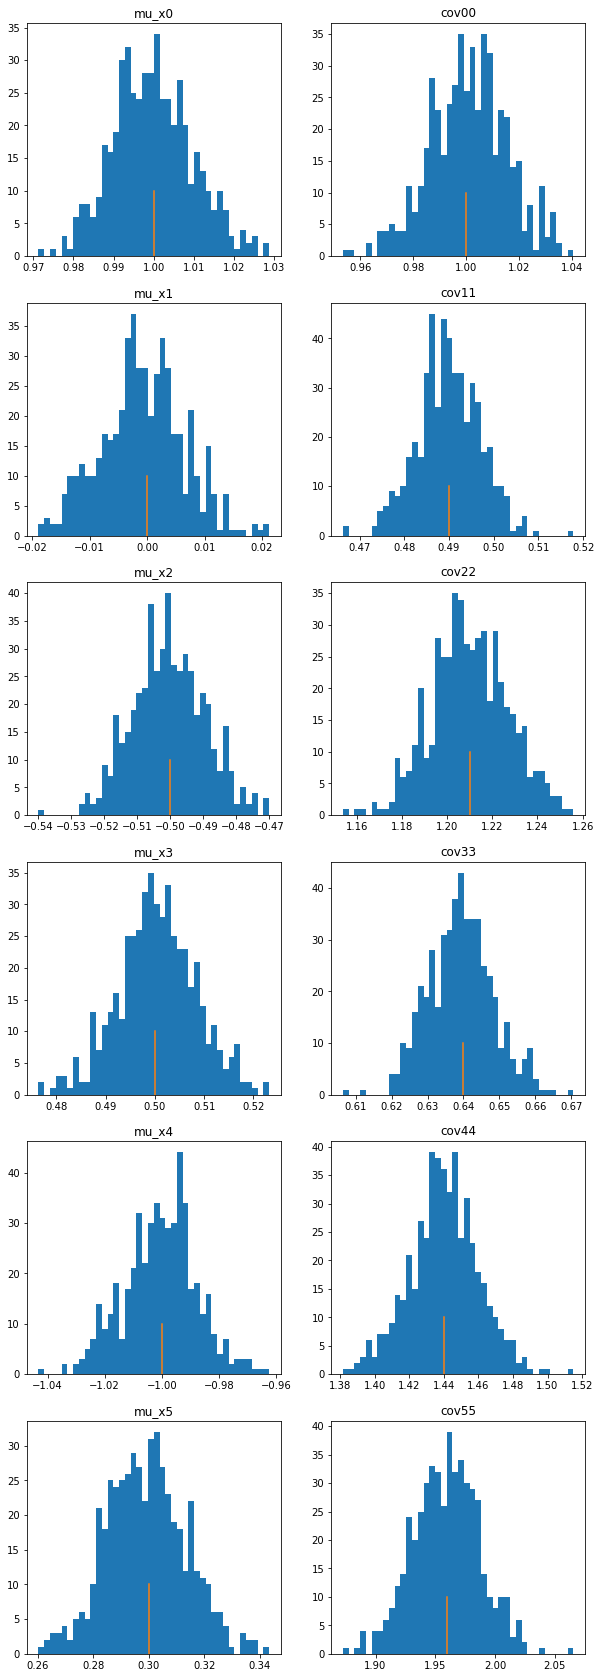

In [39]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    
    thisax.hist( fit_results_mean_val[i,:], bins=hbins)
    thisax.plot( [mc_mu[i], mc_mu[i]], [0,10])
    thisax.set_title( 'mu_x%d' % i )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    
    thisax.hist( fit_results_cov_val[i,i,:], bins=hbins)
    thisax.plot( [mc_sig[i]*mc_sig[i], mc_sig[i]*mc_sig[i]], [0,10])
    thisax.set_title( 'cov%d%d' % (i,i) )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

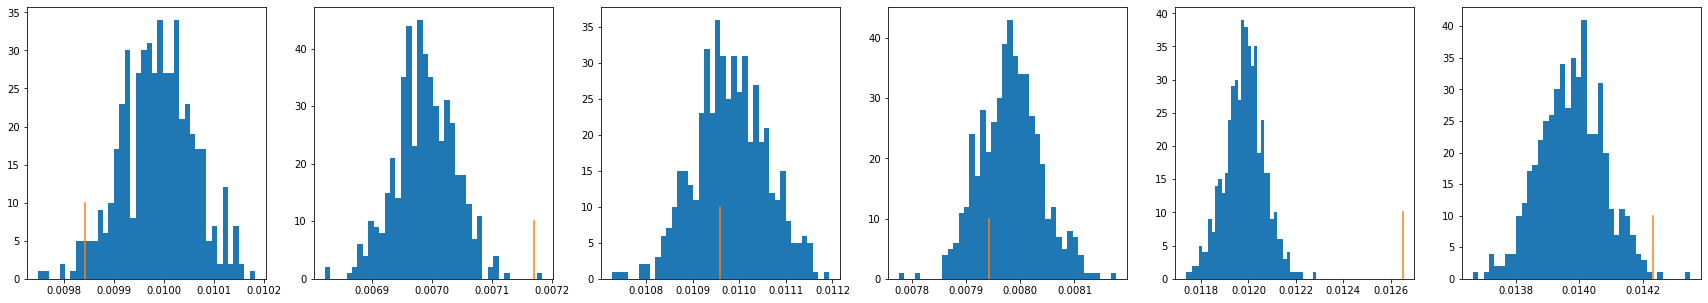

In [40]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    if ndim > 1 :
        thisax = ax[fi]
    else :
        thisax = ax
        
    thisax.hist( fit_results_mean_err[fi,:], bins=hbins )
    thisax.plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

In [43]:
fit_results_mean_err.shape

(6, 500)

In [44]:

print('\n\n')

for fi in range(ndim) :
    
    mean_ave_fit_err = np.mean( fit_results_mean_err[fi,:] )
    ratio = mean_ave_fit_err / rms_mean[fi]
    print('   --- Feature %3d :  mean fit err %.4f, RMS of simple calc %.4f,  ratio %.3f' % 
          (fi, mean_ave_fit_err, rms_mean[fi], ratio) )

print('\n\n')

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        
        cov_ave_fit_err = np.mean( fit_results_cov_err[fi1,fi2,:])
        ratio = cov_ave_fit_err / rms_cov[fi1,fi2]
        print(' --- Cov %2d, %2d :   ave fit err %.4f, RMS of simple calc %.4f,  ratio %.3f' % 
              (fi1,fi2, cov_ave_fit_err, rms_cov[fi1,fi2], ratio))

    
print('\n\n')




   --- Feature   0 :  mean fit err 0.0100, RMS of simple calc 0.0098,  ratio 1.015
   --- Feature   1 :  mean fit err 0.0070, RMS of simple calc 0.0072,  ratio 0.975
   --- Feature   2 :  mean fit err 0.0110, RMS of simple calc 0.0110,  ratio 1.002
   --- Feature   3 :  mean fit err 0.0080, RMS of simple calc 0.0079,  ratio 1.005
   --- Feature   4 :  mean fit err 0.0120, RMS of simple calc 0.0127,  ratio 0.947
   --- Feature   5 :  mean fit err 0.0140, RMS of simple calc 0.0142,  ratio 0.982



 --- Cov  0,  0 :   ave fit err 0.0141, RMS of simple calc 0.0144,  ratio 0.979
 --- Cov  0,  1 :   ave fit err 0.0070, RMS of simple calc 0.0072,  ratio 0.972
 --- Cov  0,  2 :   ave fit err 0.0112, RMS of simple calc 0.0107,  ratio 1.049
 --- Cov  0,  3 :   ave fit err 0.0083, RMS of simple calc 0.0082,  ratio 1.010
 --- Cov  0,  4 :   ave fit err 0.0120, RMS of simple calc 0.0119,  ratio 1.009
 --- Cov  0,  5 :   ave fit err 0.0140, RMS of simple calc 0.0138,  ratio 1.014
 --- Cov  1,  1 

In [45]:
fit_results_mean_val.shape

(6, 500)

In [48]:
mean_pull = np.zeros( shape=fit_results_mean_val.shape )
for fi in range( ndim ) :
    mean_pull[fi,:] = (fit_results_mean_val[fi,:] - mc_mu[fi]) / fit_results_mean_err[fi,:]

 Feature  0 mean pull:  ave  -0.024,  RMS   0.987 
 Feature  1 mean pull:  ave  -0.102,  RMS   1.027 
 Feature  2 mean pull:  ave  -0.027,  RMS   0.999 
 Feature  3 mean pull:  ave   0.058,  RMS   0.996 
 Feature  4 mean pull:  ave  -0.041,  RMS   1.057 
 Feature  5 mean pull:  ave  -0.060,  RMS   1.020 


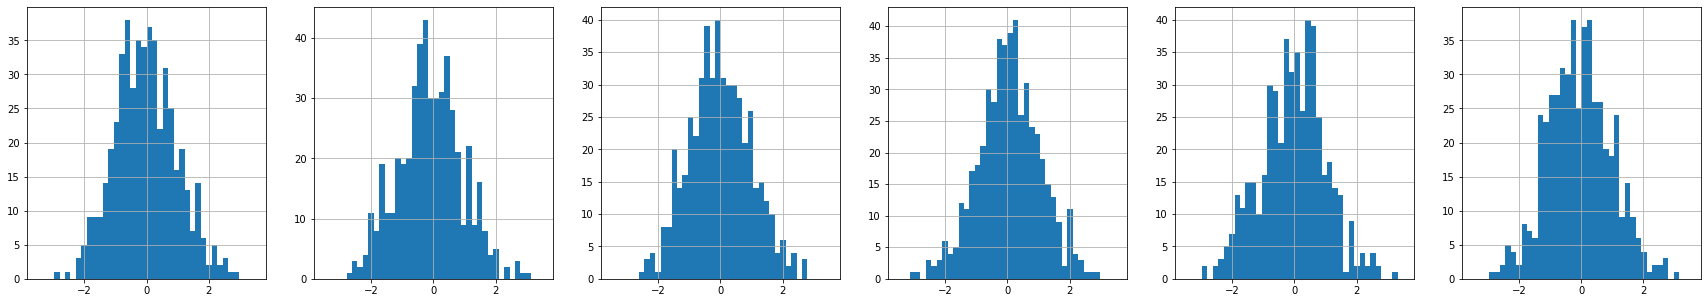

In [55]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40

for fi in range(ndim) :
    
    axi = ax[fi]
    axi.hist( mean_pull[fi,:], bins=hbins, range=[-3.5,3.5])
    
    ave = np.mean( mean_pull[fi,:] )
    rms = np.sqrt( np.cov( mean_pull[fi,:]) )
    print(' Feature %2d mean pull:  ave %7.3f,  RMS %7.3f ' % (fi, ave, rms ))
    axi.grid(True)

In [60]:
cov_pull = np.zeros( shape=fit_results_cov_val.shape )

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        
        cov_pull[fi1,fi2,:] = (fit_results_cov_val[fi1,fi2,:] - mc_cov[fi1,fi2]) / fit_results_cov_err[fi1,fi2,:]
        
        ave = np.mean( cov_pull[fi1,fi2,:] )
        rms = np.sqrt( np.cov( cov_pull[fi1,fi2,:]) )
        print(' Feature %2d,%2d cov pull:  ave %7.3f,  RMS %7.3f ' % (fi1,fi2, ave, rms ))


 Feature  0, 0 cov pull:  ave   0.054,  RMS   1.024 
 Feature  0, 1 cov pull:  ave  -0.031,  RMS   1.032 
 Feature  0, 2 cov pull:  ave  -0.035,  RMS   0.955 
 Feature  0, 3 cov pull:  ave   0.059,  RMS   0.994 
 Feature  0, 4 cov pull:  ave  -0.041,  RMS   0.993 
 Feature  0, 5 cov pull:  ave  -0.097,  RMS   0.988 
 Feature  1, 1 cov pull:  ave  -0.023,  RMS   1.010 
 Feature  1, 2 cov pull:  ave  -0.026,  RMS   0.980 
 Feature  1, 3 cov pull:  ave   0.037,  RMS   1.013 
 Feature  1, 4 cov pull:  ave  -0.012,  RMS   0.968 
 Feature  1, 5 cov pull:  ave  -0.037,  RMS   0.970 
 Feature  2, 2 cov pull:  ave  -0.014,  RMS   0.993 
 Feature  2, 3 cov pull:  ave   0.077,  RMS   1.018 
 Feature  2, 4 cov pull:  ave  -0.043,  RMS   0.965 
 Feature  2, 5 cov pull:  ave  -0.072,  RMS   0.989 
 Feature  3, 3 cov pull:  ave  -0.088,  RMS   1.002 
 Feature  3, 4 cov pull:  ave  -0.029,  RMS   1.042 
 Feature  3, 5 cov pull:  ave   0.031,  RMS   1.021 
 Feature  4, 4 cov pull:  ave  -0.004,  RMS   

<function matplotlib.pyplot.show(close=None, block=None)>

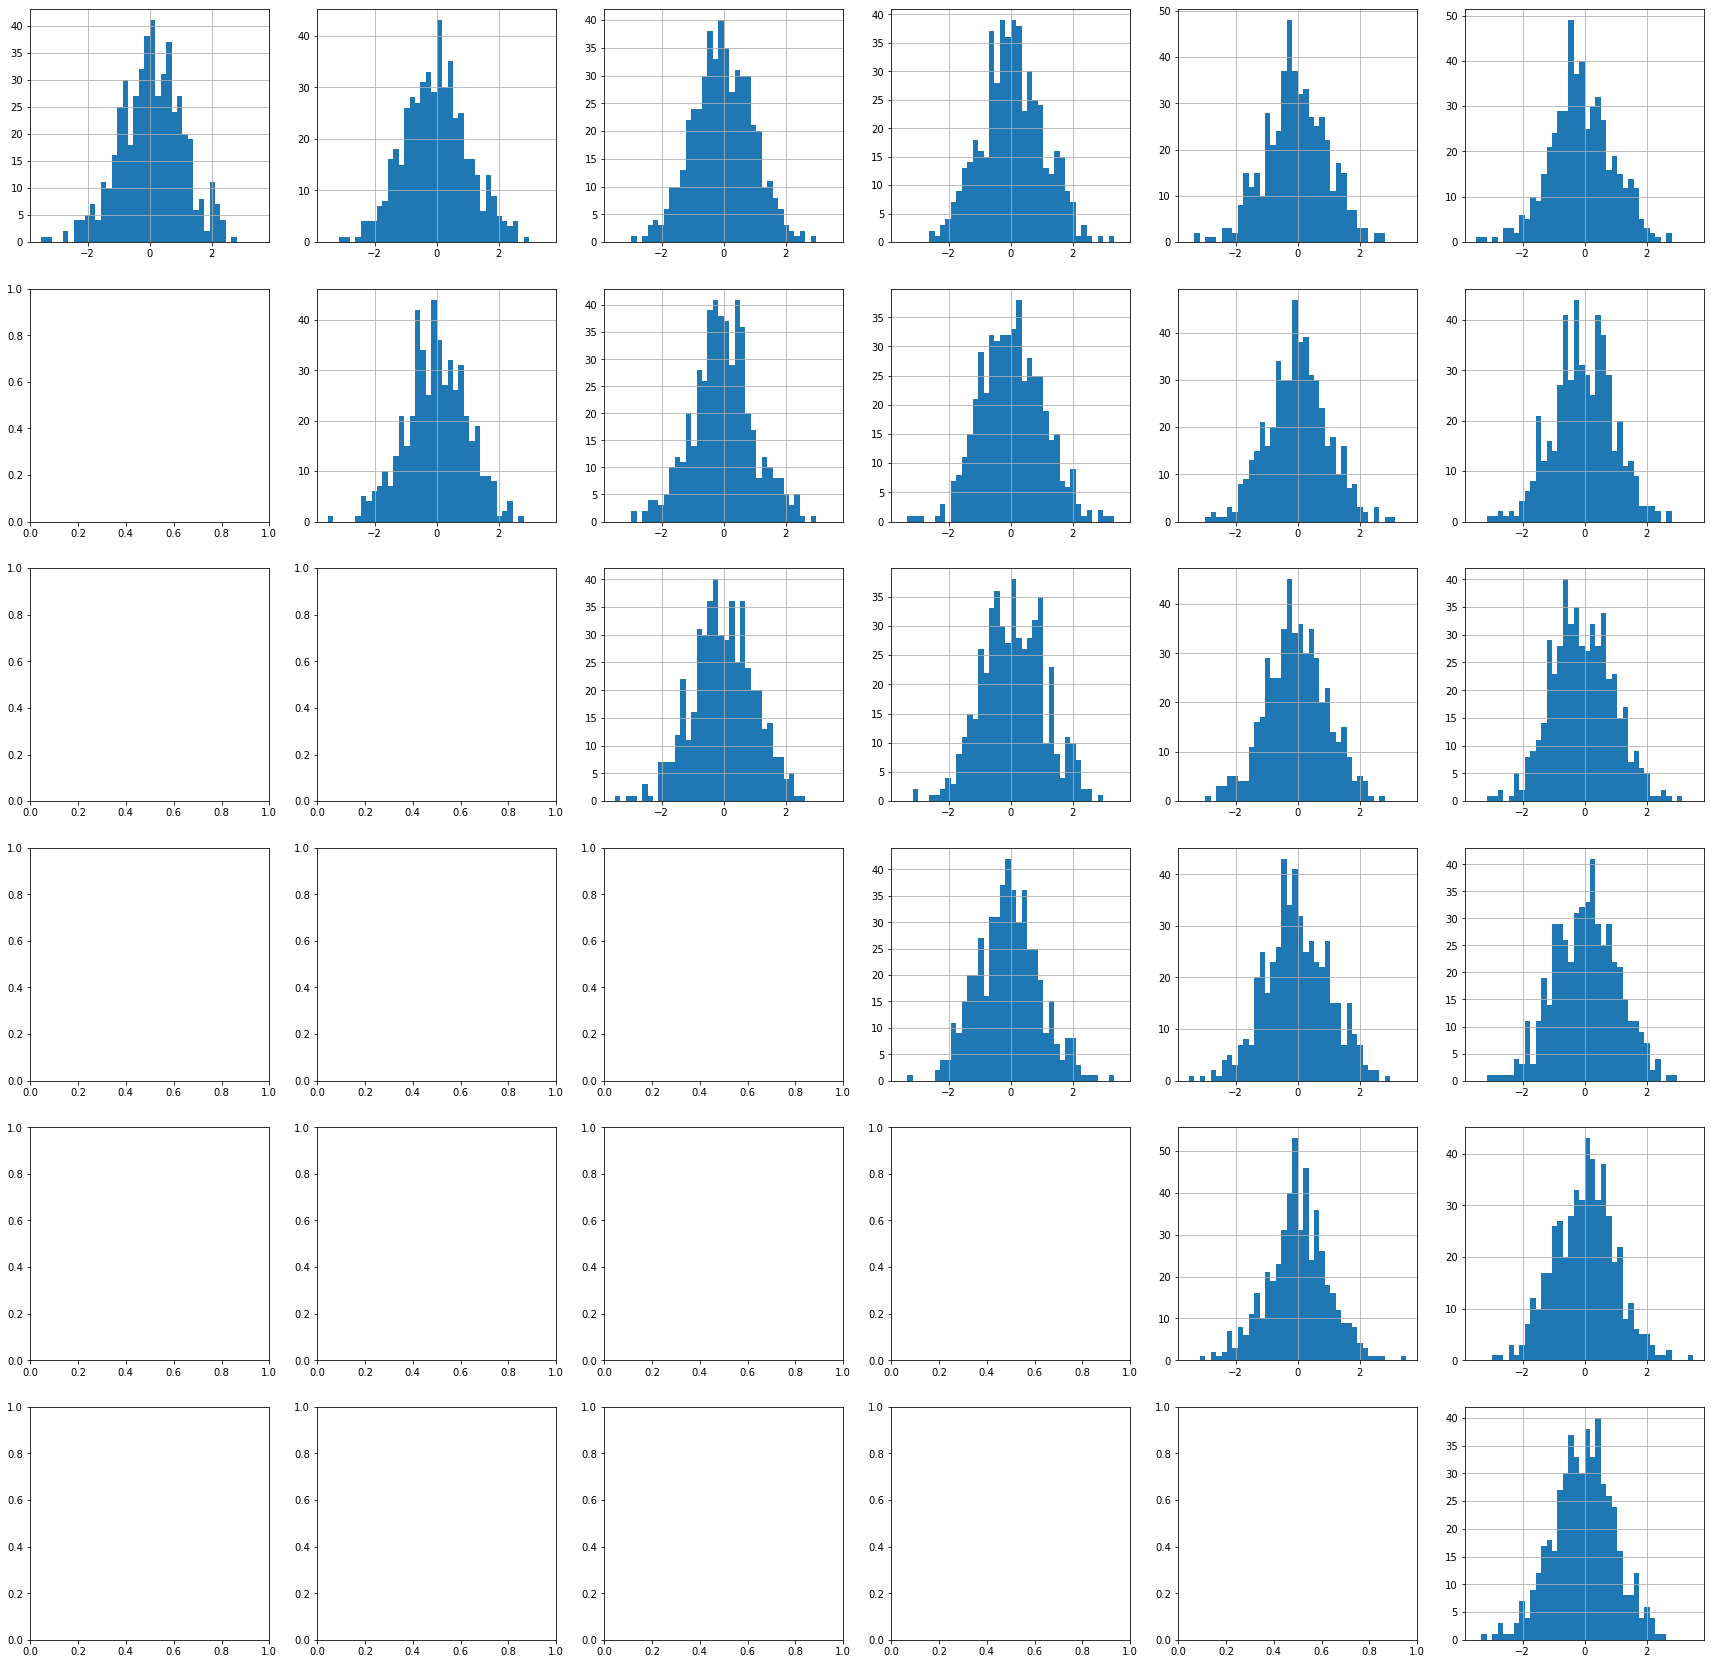

In [59]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

hbins=40
hmax=10

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :

        axi = ax[fi1][fi2]
        axi.hist( cov_pull[fi1,fi2,:], bins=hbins, range=[-3.5,3.5] )
        axi.grid(True)
        

    
plt.show